### **Loading The Libraries**

In [1322]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import requests
from io import StringIO
import calendar
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
from prophet import Prophet
import requests
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit


from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


In [1323]:
# to hide all warnings
import warnings
warnings.filterwarnings("ignore")

### **Loading all 4 csv's**

In [1324]:
# load all the csv files from 2021 to 2024

df_2021 = pd.read_csv('demanddata_2021.csv')
df_2022 = pd.read_csv('demanddata_2022.csv')
df_2023 = pd.read_csv('demanddata_2023.csv')
df_2024 = pd.read_csv('demanddata_2024.csv')

In [1325]:
# print all the columns in the dataframes
pd.set_option('display.max_columns', None)

---
### 📊 Dataset Description: National Grid ESO Demand Data

This dataset contains half-hourly electricity system data across Great Britain. Below is a summary of key columns and their meanings:

| Column | Description |
|--------|-------------|
| **SETTLEMENT_DATE** | The calendar date for each record (in ISO 8601 format). Each day has 48 half-hourly settlement periods. |
| **SETTLEMENT_PERIOD** | Represents each 30-minute window (1–48), starting at 00:00. |
| **ND** *(National Demand)* | The GB-wide generation requirement. Includes metered generation but excludes on-site station load, pump storage pumping, and interconnector exports. |
| **TSD** *(Transmission System Demand)* | National Demand **plus** additional generation required for station load, pump storage, and interconnectors. |
| **ENGLAND_WALES_DEMAND** | Same as ND, but restricted to England and Wales. |
| **EMBEDDED_WIND_GENERATION** | Estimated wind power from embedded generators (not directly metered by the transmission system). Reduces grid-visible demand during high wind. |
| **EMBEDDED_WIND_CAPACITY** | Estimated installed capacity of embedded wind farms. |
| **EMBEDDED_SOLAR_GENERATION** | Estimated solar PV generation from embedded sources. Reduces demand during daylight hours. |
| **EMBEDDED_SOLAR_CAPACITY** | Estimated installed capacity of embedded solar PV. |
| **NON_BM_STOR** | Short-term reserve that’s not part of the Balancing Mechanism (e.g., emergency backup, local generation, demand-side response). |
| **PUMP_STORAGE_PUMPING** | Demand from pumped hydro storage units (negative = pumping mode). |
| **SCOTTISH_TRANSFER** | Net electricity transfer between Scotland and England/Wales (negative = flow into Scotland). |

### ⚡ Interconnector Flow Columns:
Each interconnector column measures the power exchange between GB and neighboring countries:

| Column | Description |
|--------|-------------|
| **IFA_FLOW**, **IFA2_FLOW** | Interconnectors with France |
| **BRITNED_FLOW** | Connection with the Netherlands |
| **MOYLE_FLOW** | Northern Ireland link |
| **EAST_WEST_FLOW** | Link to Ireland |
| **NEMO_FLOW** | Link to Belgium |
| **NSL_FLOW** | North Sea Link to Norway |
| **ELECLINK_FLOW** | ElecLink through the Channel Tunnel |
| **VIKING_FLOW** | Viking link (likely Denmark) |
| **GREENLINK_FLOW** | Link to Ireland (Greenlink project) |

**Note:** Negative values in interconnector flows indicate **exports from GB**, and positive values indicate **imports into GB**.

---


### **Previewing the data**

In [1326]:
# previewing the data
print('Data from 2021:')
df_2021.head(2)

Data from 2021:


SETTLEMENT_DATE  SETTLEMENT_PERIOD     ND    TSD  ENGLAND_WALES_DEMAND  \
0     01-JAN-2021                  1  28354  28969                 26130   
1     01-JAN-2021                  2  28501  29114                 26281   

   EMBEDDED_WIND_GENERATION  EMBEDDED_WIND_CAPACITY  \
0                      1158                    6527   
1                      1208                    6527   

   EMBEDDED_SOLAR_GENERATION  EMBEDDED_SOLAR_CAPACITY  NON_BM_STOR  \
0                          0                    13471            0   
1                          0                    13471            0   

   PUMP_STORAGE_PUMPING  IFA_FLOW  IFA2_FLOW  BRITNED_FLOW  MOYLE_FLOW  \
0                    14      2003         -1             0         215   
1                    12      2004         -1             0         359   

   EAST_WEST_FLOW  NEMO_FLOW  NSL_FLOW  ELECLINK_FLOW  VIKING_FLOW  \
0             203        999         0              0            0   
1             203        999         0              0            0   

   GREENLINK_FLOW  
0               0  
1               0

In [1327]:
# previewing the data
print('Data from 2022:')
df_2022.head(2)

Data from 2022:


SETTLEMENT_DATE  SETTLEMENT_PERIOD     ND    TSD  ENGLAND_WALES_DEMAND  \
0     01-JAN-2022                  1  21940  23275                 20513   
1     01-JAN-2022                  2  22427  23489                 21021   

   EMBEDDED_WIND_GENERATION  EMBEDDED_WIND_CAPACITY  \
0                      2713                    6527   
1                      2755                    6527   

   EMBEDDED_SOLAR_GENERATION  EMBEDDED_SOLAR_CAPACITY  NON_BM_STOR  \
0                          0                    14008            0   
1                          0                    14008            0   

   PUMP_STORAGE_PUMPING  IFA_FLOW  IFA2_FLOW  BRITNED_FLOW  MOYLE_FLOW  \
0                   450      -181         -4           586         320   
1                   173      -181         -4           583         320   

   EAST_WEST_FLOW  NEMO_FLOW  NSL_FLOW  ELECLINK_FLOW  VIKING_FLOW  \
0             384       -100       210              0            0   
1             403       -104       176              0            0   

   GREENLINK_FLOW  
0               0  
1               0

In [1328]:
# previewing the data
print('Data from 2023:')
df_2023.head(2)

Data from 2023:


SETTLEMENT_DATE  SETTLEMENT_PERIOD     ND    TSD  ENGLAND_WALES_DEMAND  \
0       01-Jan-23                  1  21043  24680                 18995   
1       01-Jan-23                  2  21756  25289                 19730   

   EMBEDDED_WIND_GENERATION  EMBEDDED_WIND_CAPACITY  \
0                      2815                    6545   
1                      2793                    6545   

   EMBEDDED_SOLAR_GENERATION  EMBEDDED_SOLAR_CAPACITY  NON_BM_STOR  \
0                          0                    15037            0   
1                          0                    15037            0   

   PUMP_STORAGE_PUMPING  SCOTTISH_TRANSFER  IFA_FLOW  IFA2_FLOW  BRITNED_FLOW  \
0                  1161                  0       609        903          -896   
1                  1056                  0       596        904          -897   

   MOYLE_FLOW  EAST_WEST_FLOW  NEMO_FLOW  NSL_FLOW  ELECLINK_FLOW  \
0        -451            -529        253       235            998   
1        -451            -529        252       157            998   

   VIKING_FLOW  GREENLINK_FLOW  
0            0               0  
1            0               0

In [1329]:
# previewing the data
print('Data from 2024:')
df_2024.head(2)

Data from 2024:


SETTLEMENT_DATE  SETTLEMENT_PERIOD     ND    TSD  ENGLAND_WALES_DEMAND  \
0     01-JAN-2024                  1  21783  23466                 19539   
1     01-JAN-2024                  2  22521  24103                 20286   

   EMBEDDED_WIND_GENERATION  EMBEDDED_WIND_CAPACITY  \
0                      2804                    6488   
1                      2834                    6488   

   EMBEDDED_SOLAR_GENERATION  EMBEDDED_SOLAR_CAPACITY  NON_BM_STOR  \
0                          0                    16793            0   
1                          0                    16793            0   

   PUMP_STORAGE_PUMPING  SCOTTISH_TRANSFER  IFA_FLOW  IFA2_FLOW  BRITNED_FLOW  \
0                   808                -71       417         -4           666   
1                   895                288       430         -4           661   

   MOYLE_FLOW  EAST_WEST_FLOW  NEMO_FLOW  NSL_FLOW  ELECLINK_FLOW  \
0        -179             -92        905        62            998   
1         -60              -8        901       -15            998   

   VIKING_FLOW  GREENLINK_FLOW  
0          572               0  
1          575               0

----
**Observation**
* As we can see that all the columns in all four dataframes are the same. Except there is a issue with settlement date column 

----

### **Fixing the Settlement Date Issue with 2023 data**

In [1330]:
# first converting the 'SETTLEMENT_DATE' column to string type
df_2023['SETTLEMENT_DATE'] = df_2023['SETTLEMENT_DATE'].astype(str)

# Fix year: turn "01-Jan-23" into "01-Jan-2023"
df_2023['SETTLEMENT_DATE'] = df_2023['SETTLEMENT_DATE'].str.replace(
    r'(\d{2}-[A-Za-z]{3})-23', r'\1-2023', regex=True
)

# Convert to datetime
df_2023['SETTLEMENT_DATE'] = pd.to_datetime(df_2023['SETTLEMENT_DATE'], format='%d-%b-%Y', errors='coerce')

# Preview result
df_2023['SETTLEMENT_DATE'].head()

0   2023-01-01
1   2023-01-01
2   2023-01-01
3   2023-01-01
4   2023-01-01
Name: SETTLEMENT_DATE, dtype: datetime64[ns]

### **convert settlement date to datetime**

In [1331]:
# Convert settlement period to datatime for all dataframes
df_2021['SETTLEMENT_DATE'] = pd.to_datetime(df_2021['SETTLEMENT_DATE'], format='%d-%b-%Y', errors='coerce')
df_2022['SETTLEMENT_DATE'] = pd.to_datetime(df_2022['SETTLEMENT_DATE'], format='%d-%b-%Y', errors='coerce')
df_2023['SETTLEMENT_DATE'] = pd.to_datetime(df_2023['SETTLEMENT_DATE'], format='%d-%b-%Y', errors='coerce')
df_2024['SETTLEMENT_DATE'] = pd.to_datetime(df_2024['SETTLEMENT_DATE'], format='%d-%b-%Y', errors='coerce')

### **Combining all the data**

In [1332]:
# Combine all
combined_df = pd.concat([df_2021, df_2022, df_2023, df_2024], ignore_index=True)

In [1333]:
# Display the first few rows of the combined dataframe
combined_df.head()

SETTLEMENT_DATE  SETTLEMENT_PERIOD     ND    TSD  ENGLAND_WALES_DEMAND  \
0      2021-01-01                  1  28354  28969                 26130   
1      2021-01-01                  2  28501  29114                 26281   
2      2021-01-01                  3  27759  28376                 25557   
3      2021-01-01                  4  26912  27749                 24792   
4      2021-01-01                  5  26004  27178                 23933   

   EMBEDDED_WIND_GENERATION  EMBEDDED_WIND_CAPACITY  \
0                      1158                    6527   
1                      1208                    6527   
2                      1202                    6527   
3                      1226                    6527   
4                      1193                    6527   

   EMBEDDED_SOLAR_GENERATION  EMBEDDED_SOLAR_CAPACITY  NON_BM_STOR  \
0                          0                    13471            0   
1                          0                    13471            0   
2                          0                    13471            0   
3                          0                    13471            0   
4                          0                    13471            0   

   PUMP_STORAGE_PUMPING  IFA_FLOW  IFA2_FLOW  BRITNED_FLOW  MOYLE_FLOW  \
0                    14      2003         -1             0         215   
1                    12      2004         -1             0         359   
2                    16      2004         -1             0         362   
3                   236      2004         -1             0         361   
4                   573      2004         -1             0         304   

   EAST_WEST_FLOW  NEMO_FLOW  NSL_FLOW  ELECLINK_FLOW  VIKING_FLOW  \
0             203        999         0              0            0   
1             203        999         0              0            0   
2             202        999         0              0            0   
3             203       1000         0              0            0   
4             203       1000         0              0            0   

   GREENLINK_FLOW  SCOTTISH_TRANSFER  
0               0                NaN  
1               0                NaN  
2               0                NaN  
3               0                NaN  
4               0                NaN

### **Renaming the columns**

In [1334]:
# Rename columns for clarity in the merged DataFrame
combined_df.rename(columns={
    "SETTLEMENT_DATE": "settlement_date",
    "SETTLEMENT_PERIOD": "settlement_period",
    "ND": "national_demand_mw",
    "TSD": "transmission_demand_mw",
    "ENGLAND_WALES_DEMAND": "england_wales_demand_mw",
    "EMBEDDED_WIND_GENERATION": "embedded_wind_gen_mw",
    "EMBEDDED_WIND_CAPACITY": "embedded_wind_cap_mw",
    "EMBEDDED_SOLAR_GENERATION": "embedded_solar_gen_mw",
    "EMBEDDED_SOLAR_CAPACITY": "embedded_solar_cap_mw",
    "NON_BM_STOR": "non_bm_stor_mw",
    "PUMP_STORAGE_PUMPING": "pump_storage_pumping_mw",
    "SCOTTISH_TRANSFER": "scottish_transfer_mw",
    "IFA_FLOW": "ifa_flow_mw",
    "IFA2_FLOW": "ifa2_flow_mw",
    "BRITNED_FLOW": "britned_flow_mw",
    "MOYLE_FLOW": "moyle_flow_mw",
    "EAST_WEST_FLOW": "east_west_flow_mw",
    "NEMO_FLOW": "nemo_flow_mw",
    "NSL_FLOW": "nsl_flow_mw",
    "ELECLINK_FLOW": "eleclink_flow_mw",
    "VIKING_FLOW": "viking_flow_mw",
    "GREENLINK_FLOW": "greenlink_flow_mw",

    
}, inplace=True)

### **Getting know about the combined dataframe**

In [1335]:
# number of rows and columns 
print(f"Number of rows: {combined_df.shape[0]} \n  \n Number of columns: {combined_df.shape[1]} \n")

Number of rows: 70128 
  
 Number of columns: 22 



In [1336]:
# Display the info of the combined dataframe
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   settlement_date          70128 non-null  datetime64[ns]
 1   settlement_period        70128 non-null  int64         
 2   national_demand_mw       70128 non-null  int64         
 3   transmission_demand_mw   70128 non-null  int64         
 4   england_wales_demand_mw  70128 non-null  int64         
 5   embedded_wind_gen_mw     70128 non-null  int64         
 6   embedded_wind_cap_mw     70128 non-null  int64         
 7   embedded_solar_gen_mw    70128 non-null  int64         
 8   embedded_solar_cap_mw    70128 non-null  int64         
 9   non_bm_stor_mw           70128 non-null  int64         
 10  pump_storage_pumping_mw  70128 non-null  int64         
 11  ifa_flow_mw              70128 non-null  int64         
 12  ifa2_flow_mw             70128 n

In [1337]:
# check for any invalid dates
print("Invalid dates:", combined_df['settlement_date'].isna().sum())

Invalid dates: 0


### **Data Integrity Check**

In [1338]:
# count of the rows where settlement period is greater than 48 for a single day
rows_greater_than_48 = combined_df[combined_df['settlement_period'] > 48].shape[0]
print(f"Number of rows with settlement period greater than 48: {rows_greater_than_48}")

Number of rows with settlement period greater than 48: 8


In [1339]:
# count of the rows where settlement period is less than 1 for a single day
rows_less_than_1 = combined_df[combined_df['settlement_period'] < 1].shape[0]
print(f"Number of rows with settlement period less than 1: {rows_less_than_1}")

Number of rows with settlement period less than 1: 0


#### ***Adding a new column for the weekday name***

In [1340]:
# Add a new column for the weekday name
combined_df['weekday_name'] = combined_df['settlement_date'].dt.day_name()

In [1341]:
# print only those 8 rows where settlement period is greater than 48
print("Rows with settlement period greater than 48:")
print(combined_df[combined_df['settlement_period'] > 48][['settlement_date', 'weekday_name']].head(8))

Rows with settlement period greater than 48:
      settlement_date weekday_name
14590      2021-10-31       Sunday
14591      2021-10-31       Sunday
32062      2022-10-30       Sunday
32063      2022-10-30       Sunday
49534      2023-10-29       Sunday
49535      2023-10-29       Sunday
67006      2024-10-27       Sunday
67007      2024-10-27       Sunday



----

**Observation**
* This means every year in october at sunday we have more than 48 settlement periods which is due to time change.

----

In [1342]:
# check for duplicates
duplicates = combined_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [1343]:
# check for any NaN values in the combined dataframe
nan_counts = combined_df.isna().sum()
# Filter to show only columns with NaN values
nan_counts = nan_counts[nan_counts > 0]  
print("Number of NaN values in each column:")
print(nan_counts)

Number of NaN values in each column:
scottish_transfer_mw    35040
dtype: int64


#### ***Exploring the SCOTTISH_TRANSFER column***

In [1344]:
# find the year when scottish transfer is NaN
scottish_transfer_nan_years = combined_df[combined_df['scottish_transfer_mw'].isna()]['settlement_date'].dt.year.unique()
print(f"Years with NaN values in SCOTTISH_TRANSFER: {scottish_transfer_nan_years}")

Years with NaN values in SCOTTISH_TRANSFER: [2021 2022]


----

**Observation**
* This indicates that scottish transfer is not available for 2021 and 2022 years

----

### **Integrating Weather Data**

In [1345]:
# Defining coordinates for representative cities in the UK
city_coords = {
    "London": (51.50, -0.10),
    "Cardiff": (51.48, -3.18),
    "Birmingham": (52.49, -1.89),
    "Manchester": (53.48, -2.24)
}

In [1346]:
# # Use Open-Meteo archive endpoint to get 2021-2024 historical weather
# archive_base = "https://archive-api.open-meteo.com/v1/archive"
# weather_dataframes = []

# for city, (lat, lon) in city_coords.items():
#     url = (
#         f"{archive_base}?latitude={lat}&longitude={lon}"
#         f"&start_date=2021-01-01&end_date=2024-12-31"
#         f"&hourly=temperature_2m,precipitation,cloudcover,windspeed_10m"
#         f"&format=csv"
#     )

#     # Fetch the weather data
#     print(f"Fetching archived data for {city}...")

#     response = requests.get(url)

#     df = pd.read_csv(StringIO(response.text), skiprows=2)

#     # Rename columns for clarity
#     df.columns = ["timestamp", "temperature_C", "precip_mm", "cloudcover_pct", "windspeed_kmh"]
#     # Convert timestamp to datetime and other columns to appropriate types
#     df["timestamp"] = pd.to_datetime(df["timestamp"])
#     df["temperature_C"] = df["temperature_C"].astype(float)
#     df["precip_mm"] = df["precip_mm"].astype(float)
#     df["cloudcover_pct"] = df["cloudcover_pct"].astype(float)
#     df["windspeed_kmh"] = df["windspeed_kmh"].astype(float)
#     df["city"] = city
#     weather_dataframes.append(df)


In [1347]:
# # Combine all weather data
# weather_all = pd.concat(weather_dataframes)
# # removing the columns that are not needed
# weather_all.drop(columns=['city'], inplace=True)
# weather_all.head()

In [1348]:
weather_all = pd.read_csv('uk_weather_data_2021_2024.csv')

weather_all.head()

timestamp  temperature_C  precip_mm  cloudcover_pct  \
0  2021-01-01 00:00:00           -0.1        0.0            65.0   
1  2021-01-01 01:00:00           -0.7        0.0            59.0   
2  2021-01-01 02:00:00           -1.1        0.0            50.0   
3  2021-01-01 03:00:00           -1.7        0.0            28.0   
4  2021-01-01 04:00:00           -2.3        0.0            46.0   

   windspeed_kmh  
0            3.8  
1            4.7  
2            5.0  
3            6.1  
4            6.9

In [1349]:
# check for descriptive statistics of the weather data
weather_all.drop(columns=['timestamp']).describe()

temperature_C      precip_mm  cloudcover_pct  windspeed_kmh
count  140256.000000  140256.000000   140256.000000  140256.000000
mean       10.971820       0.120393       71.388012      14.427766
std         5.819009       0.436645       36.914519       7.602164
min       -10.200000       0.000000        0.000000       0.000000
25%         7.000000       0.000000       40.000000       8.500000
50%        10.900000       0.000000       97.000000      13.300000
75%        15.000000       0.000000      100.000000      19.200000
max        38.000000      14.700000      100.000000      68.000000

In [1350]:
# Ensure weather_all['timestamp'] is datetime
weather_all['timestamp'] = pd.to_datetime(weather_all['timestamp'])

---

As we can see that `temperature_C` on average is 10.971 degree celcius and its deviates 5 degree from its mean. Whereas the minimum temperature is -10 degree celcius.
Whereas the maximum windspeed is 68 km per hour.

---

### Dealing the demand data which is collected every 30 minutes


---
As weather data is collected hourly and national electricity demand is every 30 minutes so to merge the dataframe we first delete the every 30 minutes data from the weather data and then merge it with weather data on basis of nearest timestamp.

---

In [1351]:
# Each settlement period is 30 minutes, period 1 starts at 00:00

combined_df['timestamp'] = combined_df['settlement_date'] + pd.to_timedelta((combined_df['settlement_period'] - 1) * 30, unit='m')
combined_df[['settlement_date', 'settlement_period', 'timestamp']].head()

settlement_date  settlement_period           timestamp
0      2021-01-01                  1 2021-01-01 00:00:00
1      2021-01-01                  2 2021-01-01 00:30:00
2      2021-01-01                  3 2021-01-01 01:00:00
3      2021-01-01                  4 2021-01-01 01:30:00
4      2021-01-01                  5 2021-01-01 02:00:00

In [1352]:
# Create 'hour_flag' for grouping to full hours
combined_df['hour_flag'] = combined_df['timestamp'].dt.floor('H')

In [1353]:
combined_df.head(2)

settlement_date  settlement_period  national_demand_mw  \
0      2021-01-01                  1               28354   
1      2021-01-01                  2               28501   

   transmission_demand_mw  england_wales_demand_mw  embedded_wind_gen_mw  \
0                   28969                    26130                  1158   
1                   29114                    26281                  1208   

   embedded_wind_cap_mw  embedded_solar_gen_mw  embedded_solar_cap_mw  \
0                  6527                      0                  13471   
1                  6527                      0                  13471   

   non_bm_stor_mw  pump_storage_pumping_mw  ifa_flow_mw  ifa2_flow_mw  \
0               0                       14         2003            -1   
1               0                       12         2004            -1   

   britned_flow_mw  moyle_flow_mw  east_west_flow_mw  nemo_flow_mw  \
0                0            215                203           999   
1                0            359                203           999   

   nsl_flow_mw  eleclink_flow_mw  viking_flow_mw  greenlink_flow_mw  \
0            0                 0               0                  0   
1            0                 0               0                  0   

   scottish_transfer_mw weekday_name           timestamp  hour_flag  
0                   NaN       Friday 2021-01-01 00:00:00 2021-01-01  
1                   NaN       Friday 2021-01-01 00:30:00 2021-01-01

In [1354]:
# Define columns to sum
cols_to_sum = [
    'national_demand_mw', 'transmission_demand_mw', 'england_wales_demand_mw', 'embedded_wind_gen_mw',
    'embedded_solar_gen_mw', 'non_bm_stor_mw', 'pump_storage_pumping_mw',
    'ifa_flow_mw', 'ifa2_flow_mw', 'britned_flow_mw', 'moyle_flow_mw', 'east_west_flow_mw',
    'nemo_flow_mw', 'nsl_flow_mw', 'eleclink_flow_mw', 'viking_flow_mw', 'greenlink_flow_mw',
    'scottish_transfer_mw'
]

In [1355]:
# Only keep columns that exist in the dataframe (for compatibility)
cols_to_sum = [col for col in cols_to_sum if col in combined_df.columns]


cols_to_forward = [
    'embedded_wind_cap_mw', 'embedded_solar_gen_mw'
]

In [1356]:
all_columns_needed = cols_to_sum + cols_to_forward

In [1357]:
# Check if all columns are available in the combined dataframe
available_columns = [col for col in all_columns_needed if col in combined_df.columns]

In [1358]:
# Create aggregation dictionary
# Sum for demand and flow columns, max for capacity columns
agg_dict = {col: 'sum' for col in cols_to_sum if col in available_columns}
agg_dict.update({col: 'max' for col in cols_to_forward if col in available_columns})

In [1359]:
# Group by hour_flag and aggregate using agg_dict
hourly_df = combined_df.groupby('hour_flag').agg(agg_dict).reset_index().rename(columns={'hour_flag': 'timestamp'})

In [1360]:
hourly_df.head(2)

timestamp  national_demand_mw  transmission_demand_mw  \
0 2021-01-01 00:00:00               56855                   58083   
1 2021-01-01 01:00:00               54671                   56125   

   england_wales_demand_mw  embedded_wind_gen_mw  embedded_solar_gen_mw  \
0                    52411                  2366                      0   
1                    50349                  2428                      0   

   non_bm_stor_mw  pump_storage_pumping_mw  ifa_flow_mw  ifa2_flow_mw  \
0               0                       26         4007            -2   
1               0                      252         4008            -2   

   britned_flow_mw  moyle_flow_mw  east_west_flow_mw  nemo_flow_mw  \
0                0            574                406          1998   
1                0            723                405          1999   

   nsl_flow_mw  eleclink_flow_mw  viking_flow_mw  greenlink_flow_mw  \
0            0                 0               0                  0   
1            0                 0               0                  0   

   scottish_transfer_mw  embedded_wind_cap_mw  
0                   0.0                  6527  
1                   0.0                  6527

### **Merging the demand data with weather data on basis of nearest timestamp**

In [1361]:


# Merge using nearest timestamp
df = pd.merge_asof(
    hourly_df.sort_values("timestamp"),
    weather_all.sort_values("timestamp"),
    on="timestamp",
    direction="nearest"
)

### **Feature Engineering**

In [1362]:
### Add column like Day, Month, Day of the Week

# Ensure SETTLEMENT_DATE is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Add column like Day, Month, Day of the Week
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['day_of_week'] = df['timestamp'].dt.day_name()
df['year'] = df['timestamp'].dt.year
df['is_weekend'] = df['timestamp'].dt.dayofweek >= 5

In [1363]:
# adding rolling mean for demand and temperature
df['demand_roll_mean_6h'] = df['national_demand_mw'].rolling(window=6, min_periods=1).mean()

df["temp_roll_mean_6h"] = df['temperature_C'].rolling(window=6, min_periods=1).mean()

### **Time Range**




In [1364]:
# time range of the data
print("Time range of the data:")
print(df['timestamp'].min(), "to", df['timestamp'].max())

Time range of the data:
2021-01-01 00:00:00 to 2024-12-31 23:00:00


### **Summary Statistics**

In [1365]:
# Basic numeric overview
display(df.describe().T)

count                           mean  \
timestamp                  35060  2023-01-01 11:45:44.050199552   
national_demand_mw       35060.0                    53658.42818   
transmission_demand_mw   35060.0                   57743.921848   
england_wales_demand_mw  35060.0                   49172.277867   
embedded_wind_gen_mw     35060.0                    3647.805933   
embedded_solar_gen_mw    35060.0                    1602.805391   
non_bm_stor_mw           35060.0                       0.064318   
pump_storage_pumping_mw  35060.0                      401.49672   
ifa_flow_mw              35060.0                     1275.03243   
ifa2_flow_mw             35060.0                     440.826868   
britned_flow_mw          35060.0                     569.332573   
moyle_flow_mw            35060.0                    -291.944324   
east_west_flow_mw        35060.0                    -242.389276   
nemo_flow_mw             35060.0                     836.644723   
nsl_flow_mw              35060.0                    1275.059441   
eleclink_flow_mw         35060.0                       338.5002   
viking_flow_mw           35060.0                     211.727239   
greenlink_flow_mw        35060.0                      -0.032516   
scottish_transfer_mw     35060.0                    1657.942527   
embedded_wind_cap_mw     35060.0                     6544.30251   
temperature_C            35060.0                      10.971825   
precip_mm                35060.0                       0.119278   
cloudcover_pct           35060.0                      71.237079   
windspeed_kmh            35060.0                       14.43273   
day                      35060.0                      15.728237   
month                    35060.0                       6.523331   
year                     35060.0                    2022.501027   
demand_roll_mean_6h      35060.0                   53659.066562   
temp_roll_mean_6h        35060.0                      10.970968   

                                         min                  25%  \
timestamp                2021-01-01 00:00:00  2022-01-01 05:45:00   
national_demand_mw                   27256.0              44140.0   
transmission_demand_mw               33104.0             49098.75   
england_wales_demand_mw              25713.0              40497.0   
embedded_wind_gen_mw                   297.0               1774.0   
embedded_solar_gen_mw                    0.0                  0.0   
non_bm_stor_mw                           0.0                  0.0   
pump_storage_pumping_mw                  0.0                 13.0   
ifa_flow_mw                          -4139.0               -242.0   
ifa2_flow_mw                         -2564.0              -218.25   
britned_flow_mw                      -3406.0                 -2.0   
moyle_flow_mw                        -1547.0               -881.0   
east_west_flow_mw                    -2107.0               -825.0   
nemo_flow_mw                         -2047.0                  0.0   
nsl_flow_mw                          -2910.0                  0.0   
eleclink_flow_mw                     -3977.0                  0.0   
viking_flow_mw                       -2912.0                  0.0   
greenlink_flow_mw                     -162.0                  0.0   
scottish_transfer_mw                 -5604.0                  0.0   
embedded_wind_cap_mw                  6488.0               6527.0   
temperature_C                          -10.2                  7.0   
precip_mm                                0.0                  0.0   
cloudcover_pct                           0.0                 39.0   
windspeed_kmh                            0.0                  8.5   
day                                      1.0                  8.0   
month                                    1.0                  4.0   
year                                  2021.0               2022.0   
demand_roll_mean_6h             28579.166667         45251.458333   
temp_roll_mean_

### **Correlation Matrix of Demand and Weather Variables**

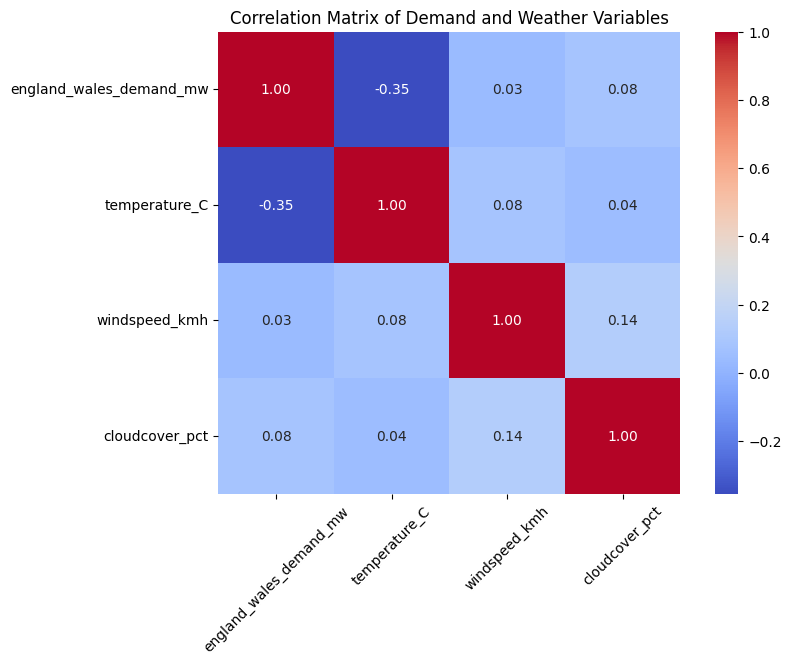

In [1366]:
df[['england_wales_demand_mw', 'temperature_C', 'windspeed_kmh', 'cloudcover_pct']].corr()

# Plotting the correlation matrix
plt.figure(figsize=(9, 6))
sns.heatmap(
    df[['england_wales_demand_mw', 'temperature_C', 'windspeed_kmh', 'cloudcover_pct']].corr(),
    annot=True, fmt=".2f", cmap='coolwarm', square=True
)
plt.xticks(rotation=45)
plt.title("Correlation Matrix of Demand and Weather Variables")
plt.show()


----

**Observation:**
* As we can see that none of the other weather parameter shows strong correlation except the temperature which has inverse relationship with the demand.

----

### **Yearly Demand Statistics**

In [1367]:
summary = df.groupby('year')['england_wales_demand_mw'].describe().drop(columns=['25%', '50%', '75%', 'count']).round(2)
print('Yearly demand statistics :')
display(summary)


Yearly demand statistics :


mean       std      min      max
year                                      
2021  51806.06  11098.90  29179.0  84654.0
2022  48836.50  11204.74  27881.0  83106.0
2023  47721.25  10965.32  25713.0  80816.0
2024  48327.61  10868.18  27646.0  82125.0

----
As we can see that average demand decrease over the years.

----

### **Weekday Statistics**

In [1368]:
# Grouped descriptive statistics by weekday, removing quartiles
stats = df.groupby('day_of_week')['england_wales_demand_mw'].describe().drop(columns=['25%', '50%', '75%', 'count', 'std']).round(2)

# Apply color gradient for better readability
styled_stats = stats.style.background_gradient(cmap='coolwarm', axis=0).set_caption("Demand Statistics by Weekday")

# Display the styled DataFrame
styled_stats

## **Exploratory Data Analysis**

### **Yearly Total Demand**

In [1369]:
# Calculate yearly demand
yearly_demand = df.groupby('year', as_index=False)['england_wales_demand_mw'].sum()
yearly_demand['Total Demand (MMW)'] = (yearly_demand['england_wales_demand_mw'] / 1e6).round(2)
display(yearly_demand[['year', 'Total Demand (MMW)']])


year  Total Demand (MMW)
0  2021              453.77
1  2022              427.76
2  2023              417.99
3  2024              424.46

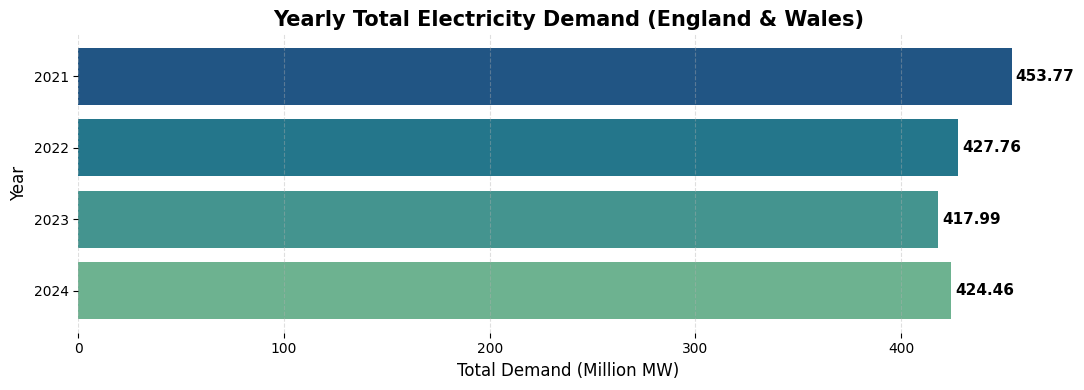

In [1370]:
plt.figure(figsize=(11, 4))
sorted_yearly = yearly_demand.sort_values('year', ascending=False)

bars = plt.barh(
    sorted_yearly['year'].astype(str),
    sorted_yearly['Total Demand (MMW)'],
    color=sns.color_palette("crest", len(sorted_yearly))
)

plt.title('Yearly Total Electricity Demand (England & Wales)', fontsize=15, weight='bold')
plt.xlabel('Total Demand (Million MW)', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Add labels to each bar
for bar in bars:
    plt.text(
        bar.get_width() + 2, bar.get_y() + bar.get_height() / 2,
        f"{bar.get_width():.2f}",
        va='center', fontsize=11, color='black', weight='bold'
    )

plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.show()


---

**Observation:**


As from above graph we can see that demand is decreasing over the years from 2021 to 2023 having slightly increase in demand in 2024.

--- 

### Avg Monthly Total Demand In whole time period

In [1371]:
# calculate monthly demand 
monthly_demand = df.groupby('month', as_index=False)['england_wales_demand_mw'].sum()
monthly_demand['Total Demand (MMW)'] = (monthly_demand['england_wales_demand_mw'] / 1e6).round(2)
display(monthly_demand[['month', 'Total Demand (MMW)']])

month  Total Demand (MMW)
0       1              176.70
1       2              151.81
2       3              157.39
3       4              136.83
4       5              130.33
5       6              121.58
6       7              126.48
7       8              125.09
8       9              129.26
9      10              143.05
10     11              158.20
11     12              167.26

---

**Observation:**\
As from above graph we can see that demand is decreasing over the years from 2021 to 2023 having slightly increase in demand in 2024.

--- 

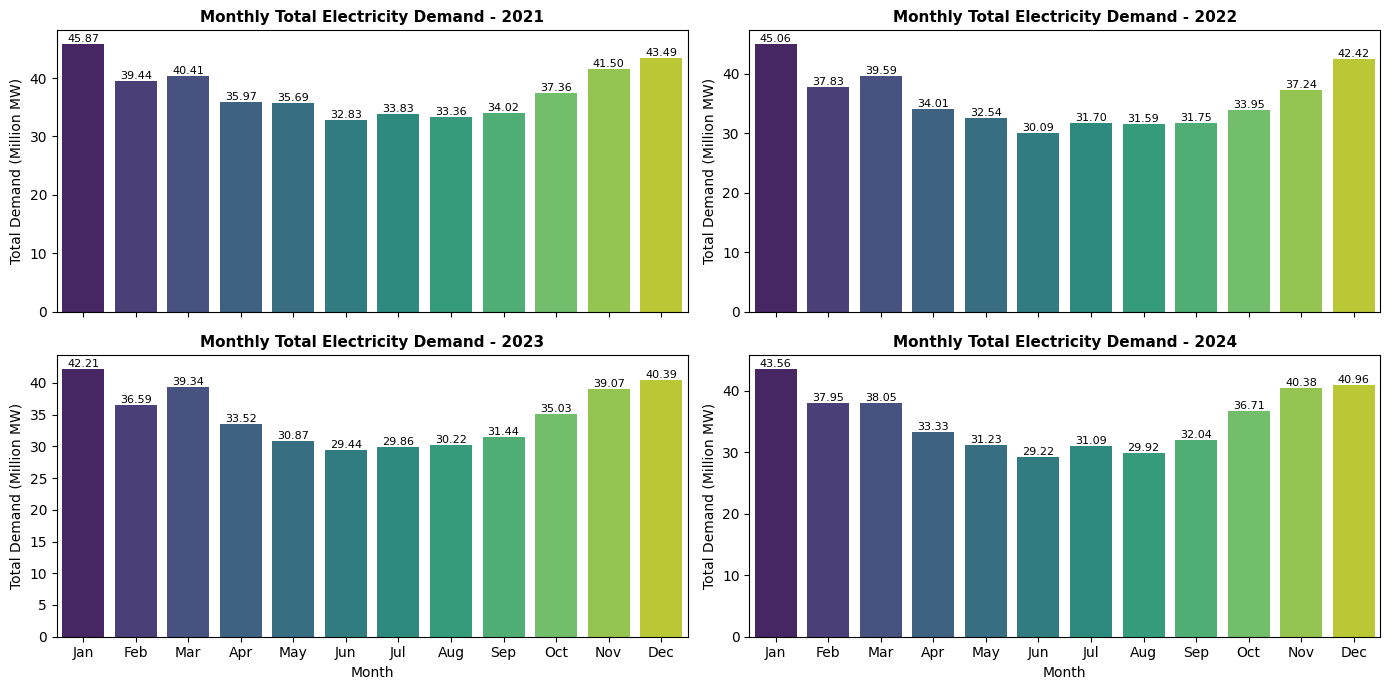

In [1372]:
import calendar

years = df['year'].unique()
fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=True)
axes = axes.flatten()

for i, year in enumerate(sorted(years)):
    ax = axes[i]
    data = df[df['year'] == year].groupby('month', as_index=False)['england_wales_demand_mw'].sum()
    data['Total Demand (MMW)'] = (data['england_wales_demand_mw'] / 1e6).round(2)

    sns.barplot(data=data, x='month', y='Total Demand (MMW)', palette='viridis', ax=ax)

    ax.set_title(f'Monthly Total Electricity Demand - {year}', fontsize=11, weight='bold')
    ax.set_xlabel('Month')
    ax.set_ylabel('Total Demand (Million MW)')

    # Use abbreviated month names
    ax.set_xticks(range(12))
    ax.set_xticklabels([calendar.month_abbr[m] for m in range(1, 13)], rotation=0)

    for index, row in data.iterrows():
        ax.text(row['month'] - 1, row['Total Demand (MMW)'], f"{row['Total Demand (MMW)']:.2f}", 
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


----
**Observation**
* A similar trend can be scene from above graph that shows the monthly demand for each year.
* In Dec and Jan we have more demand than other months.
* In feb and Mar a same slightly increaing demad can be seen.
* In all four years demand goes all time low in june, july and aug.

----


### **Wind Generation and Installed Capacity**

#### **Yearly Wind Generation**

In [1373]:
# total energy generation from wind in each yaer
wind_generation = df.groupby('year', as_index=False)['embedded_wind_gen_mw'].sum()
wind_generation['Total Wind Generation (MMW)'] = (wind_generation['embedded_wind_gen_mw'] / 1e6).round(2)
display(wind_generation[['year', 'Total Wind Generation (MMW)']])


year  Total Wind Generation (MMW)
0  2021                        29.65
1  2022                        33.16
2  2023                        31.13
3  2024                        33.94

#### **Yearly Wind Installed Capacity**

In [1374]:
# total installed capacity of wind and solar in each year (in million MW)
wind_capacity = df.groupby('year', as_index=False)['embedded_wind_cap_mw'].sum()
wind_capacity['Total Wind Capacity (million MW)'] = (wind_capacity['embedded_wind_cap_mw'] / 1e6).round(2)
display(wind_capacity[['year', 'Total Wind Capacity (million MW)']])

year  Total Wind Capacity (million MW)
0  2021                             57.17
1  2022                             57.31
2  2023                             57.19
3  2024                             57.78

----

**Observation**

* In 2021 the total generation for wind is 29.65 million MW and 2033 and 2024 its almost same 33 million MW.

* As we can there is not such difference in wind installed capaicty between 2021 and 2024
    
---

### **Monthly Wind Generation In each year**

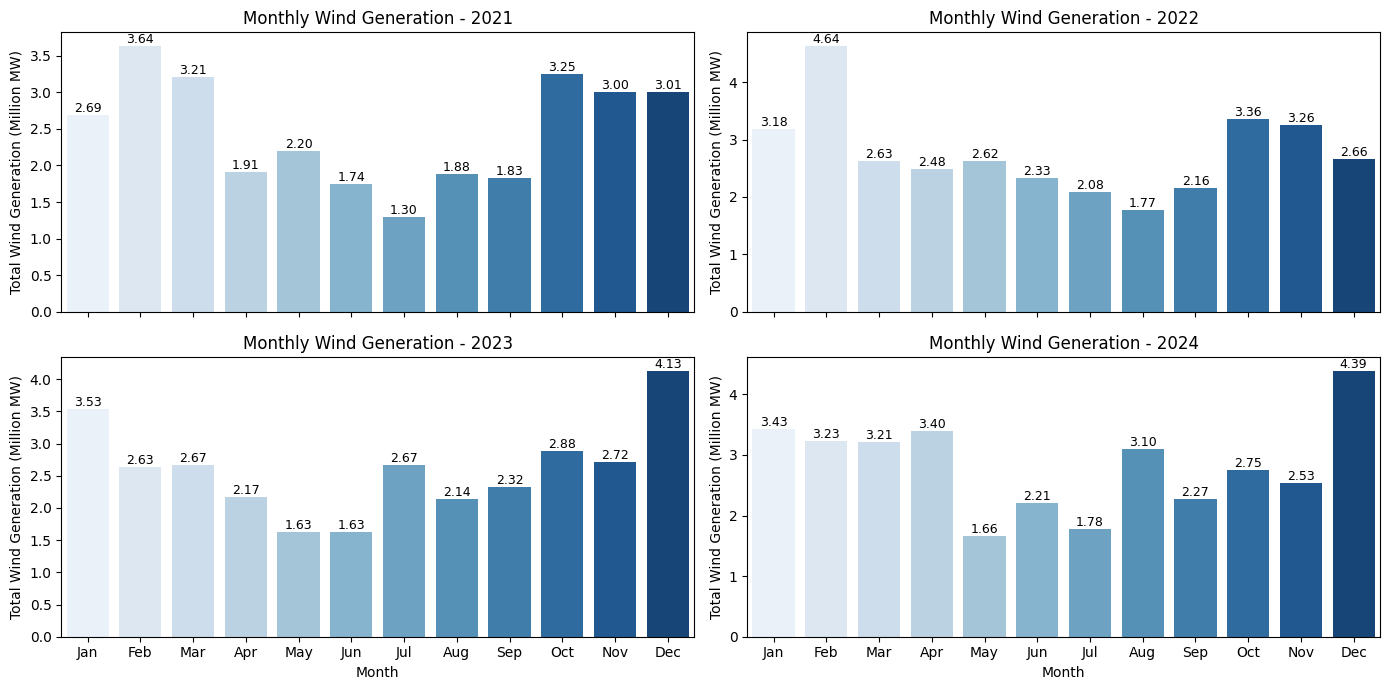

In [1375]:

# plot the most wise generation from wind in each year
# Calculate month-wise wind generation for each year
month_wise_wind = df.groupby(['year', 'month'], as_index=False)['embedded_wind_gen_mw'].sum()
month_wise_wind['Total Wind Generation (MMW)'] = (month_wise_wind['embedded_wind_gen_mw'] / 1e6).round(2)


years = sorted(month_wise_wind['year'].unique())
fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=True)
axes = axes.flatten()

for i, year in enumerate(years):
    ax = axes[i]
    data = month_wise_wind[month_wise_wind['year'] == year]
    sns.barplot(data=data, x='month', y='Total Wind Generation (MMW)', palette='Blues', ax=ax)
    ax.set_title(f'Monthly Wind Generation - {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Total Wind Generation (Million MW)')
    ax.set_xticks(range(12))
    ax.set_xticklabels([calendar.month_abbr[m] for m in data['month']])
    for index, row in data.iterrows():
        ax.text(row['month']-1, row['Total Wind Generation (MMW)'], f"{row['Total Wind Generation (MMW)']:.2f}", 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

---

**Observation**

* If we look at monthly break down for wind generation in each year we got the all time high generation through wind in feb for 2021 which is 3.64 million MW.
*  A similar trend can be seen for 2022 as well.

* But for 2023 and 2024 the trend is totally different the time the wind generation is higher in Dec and Jan with 4 and 3 million MW approximately.


* From here we can get and idea that in winter month from Dec to Feb we can generate more energy from wind according to the UK climate conditions


---

### **Monthy Solar Generation**

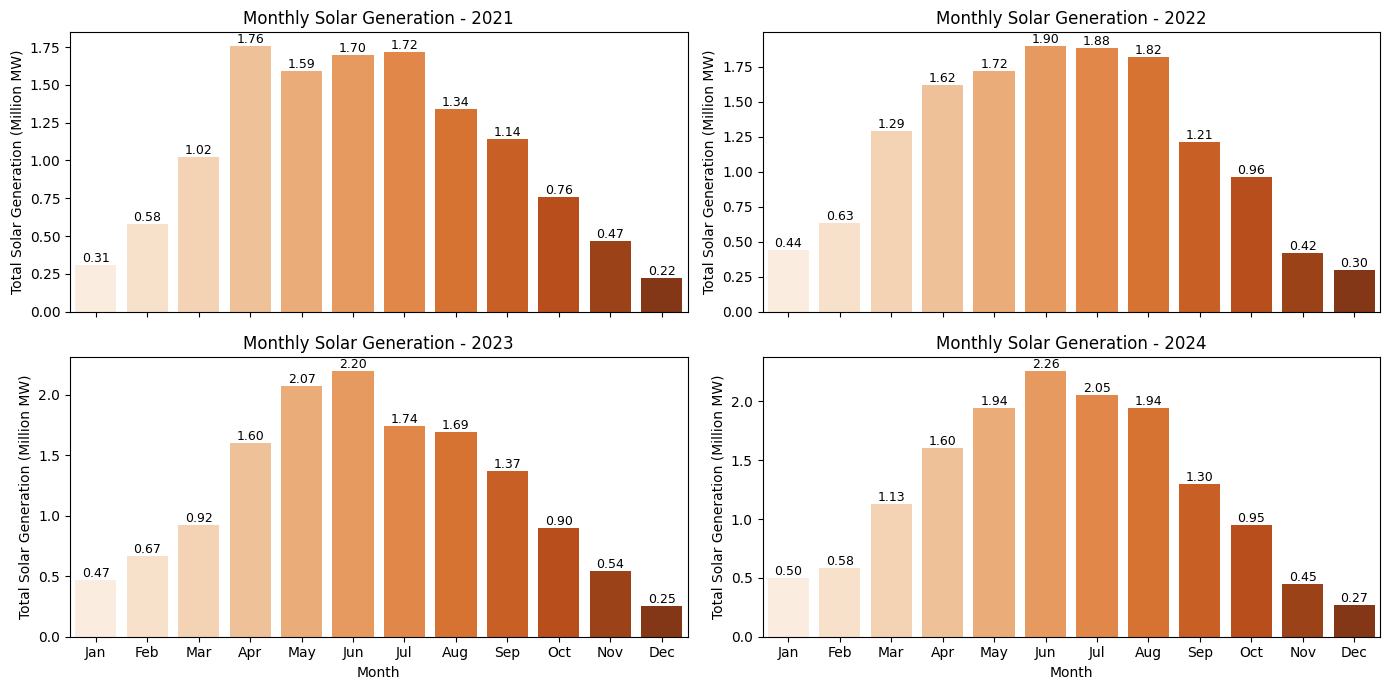

In [1376]:
# plot the monthly solar generation in each year
# Calculate month-wise solar generation for each year
month_wise_solar = df.groupby(['year', 'month'], as_index=False)['embedded_solar_gen_mw'].sum()
month_wise_solar['Total Solar Generation (MMW)'] = (month_wise_solar['embedded_solar_gen_mw'] / 1e6).round(2)
years = sorted(month_wise_solar['year'].unique())
fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=True)
axes = axes.flatten()
for i, year in enumerate(years):
    ax = axes[i]
    data = month_wise_solar[month_wise_solar['year'] == year]
    sns.barplot(data=data, x='month', y='Total Solar Generation (MMW)', palette='Oranges', ax=ax)
    ax.set_title(f'Monthly Solar Generation - {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Total Solar Generation (Million MW)')
    ax.set_xticks(range(12))
    ax.set_xticklabels([calendar.month_abbr[m] for m in data['month']])
    for index, row in data.iterrows():
        ax.text(row['month']-1, row['Total Solar Generation (MMW)'], f"{row['Total Solar Generation (MMW)']:.2f}",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

----
**Observation**

* From the above graph of solar generation which shows monthly breakdown of solar generation in each year we can get an idea that in summer months like April to August we can generate more energy from solar according to the UK climate conditions

---

### **Stacked Bar Plot which depicts Generation and Demand**

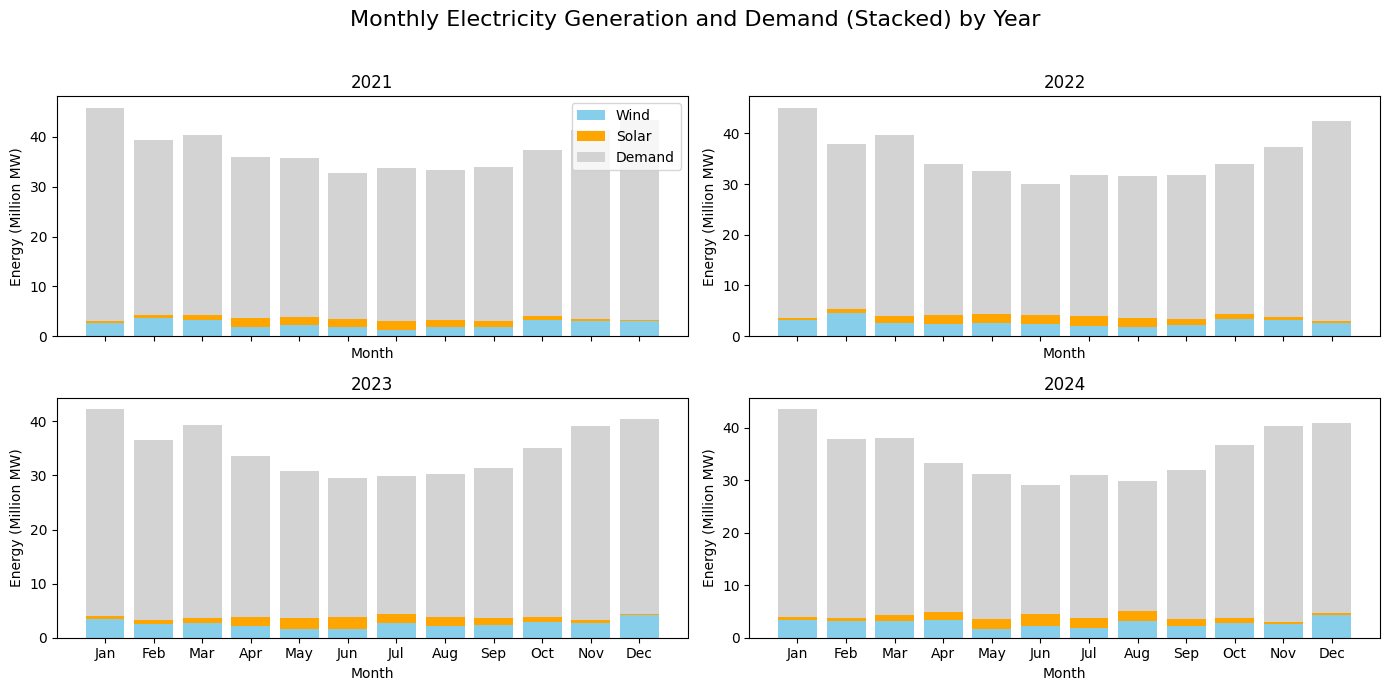

In [1377]:
# Create monthly_data if not already defined
monthly_data = df.groupby(['year', 'month'], as_index=False)[
    ['england_wales_demand_mw', 'embedded_wind_gen_mw', 'embedded_solar_gen_mw']
].sum()

fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=True)
axes = axes.flatten()
years = sorted(monthly_data['year'].unique())

for i, year in enumerate(years):
    ax = axes[i]
    data = monthly_data[monthly_data['year'] == year].copy()
    demand = data['england_wales_demand_mw'] / 1e6
    wind = data['embedded_wind_gen_mw'] / 1e6
    solar = data['embedded_solar_gen_mw'] / 1e6
    other = demand - wind - solar

    ax.bar(data['month'], wind, label='Wind', color='skyblue')
    ax.bar(data['month'], solar, bottom=wind, label='Solar', color='orange')
    ax.bar(data['month'], other, bottom=wind+solar, label='Other Demand', color='lightgrey')
    ax.set_title(f'{year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Energy (Million MW)')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels([calendar.month_abbr[m] for m in range(1, 13)])
    if i == 0:
        ax.legend(['Wind', 'Solar', 'Demand'])

plt.suptitle('Monthly Electricity Generation and Demand (Stacked) by Year', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### **Imports through Interconnectors**

In [1378]:
interconnectors = [
	'ifa_flow_mw', 'ifa2_flow_mw', 'britned_flow_mw', 'moyle_flow_mw',
	'east_west_flow_mw', 'nemo_flow_mw', 'nsl_flow_mw', 'eleclink_flow_mw',
	'viking_flow_mw', 'greenlink_flow_mw'
]

In [1379]:
# Yearly breakdown of total imports (positive values) across all interconnectors (in million MW), rounded to 2 decimals
yearly_imports = df.groupby('year')[interconnectors].apply(lambda x: x.clip(lower=0).sum(axis=0)).sum(axis=1) / 1e6
yearly_imports = yearly_imports.round(2)
print("Yearly total imports across all interconnectors (million MW):")
display(yearly_imports)


Yearly total imports across all interconnectors (million MW):


year
2021    58.51
2022    32.47
2023    67.07
2024    87.81
dtype: float64

---

**Observation**

* Here we can see that in 2022 UK has imported very less energy from all the interconnectors which is around 32 Million MW
* Where as the highest imports are in 2024 which is around 88 Million MW.

---

In [1380]:
# how much energy is imported from each interconnector in each year (positive values = imports)
interconnectors = [
	'ifa_flow_mw', 'ifa2_flow_mw', 'britned_flow_mw', 'moyle_flow_mw',
	'east_west_flow_mw', 'nemo_flow_mw', 'nsl_flow_mw', 'eleclink_flow_mw',
	'viking_flow_mw', 'greenlink_flow_mw'
]
# Only sum positive values (imports) for each interconnector per year
interconnector_imports = df.groupby('year')[interconnectors].apply(lambda x: x.clip(lower=0).sum()).reset_index()
interconnector_imports[interconnectors] = interconnector_imports[interconnectors].div(1e6).round(2)
display(interconnector_imports)

year  ifa_flow_mw  ifa2_flow_mw  britned_flow_mw  moyle_flow_mw  \
0  2021        20.28         10.03             8.68           1.53   
1  2022         2.23          2.49             7.22           2.14   
2  2023        14.33          7.61             8.53           0.84   
3  2024        21.31          8.62             6.46           0.49   

   east_west_flow_mw  nemo_flow_mw  nsl_flow_mw  eleclink_flow_mw  \
0               1.07         13.99         2.91              0.02   
1               1.98          6.46         9.09              0.86   
2               0.48          7.97        17.90              9.30   
3               0.27         10.14        19.81             10.62   

   viking_flow_mw  greenlink_flow_mw  
0            0.00                0.0  
1            0.00                0.0  
2            0.13                0.0  
3           10.10                0.0

---

**Observation**
* In all year the major source of import are interconnectors from france and netherland.
* No energy is imported from greenlink project in all years.

---



In [1381]:
# For each year, find the month with the highest total import (sum across all interconnectors)
results = []
for year in df['year'].unique():
    df_year = df[df['year'] == year]
    # Sum positive (import) values across all interconnectors for each row
    df_year['total_import'] = df_year[interconnectors].clip(lower=0).sum(axis=1)
    max_import = df_year['total_import'].max()
    row = df_year[df_year['total_import'] == max_import].iloc[0]
    results.append({
        'Year': year,
        'Month': row['month'],
        'Import_MW': max_import
    })

pd.DataFrame(results)

Year  Month  Import_MW
0  2021      2      11632
1  2022     12      13251
2  2023      2      16107
3  2024      3      18271

---

**Observation**

* In 2021 the higest imports in feb which is 11632 MW  for 2023 the month with highest imports were also feb which is 16107.
* For 2024 this month is march with all time highest imports of 18271 MW.

---

### **Exports through Interconnectors**

In [1382]:
yearly_exports = df.groupby('year')[interconnectors].apply(lambda x: x.clip(upper=0).sum()).sum(axis=1) / 1e6
yearly_exports = yearly_exports.round(2)
print("Yearly total exports across all interconnectors (million MW):")
display(yearly_exports)


Yearly total exports across all interconnectors (million MW):


year
2021    -8.81
2022   -40.88
2023   -20.25
2024   -21.21
dtype: float64

In [1383]:
# Only sum negative values (exports) for each interconnector per year
interconnector_exports = df.groupby('year')[interconnectors].apply(lambda x: x.clip(upper=0).sum().abs()).reset_index()
interconnector_exports[interconnectors] = interconnector_exports[interconnectors].div(1e6).round(2)
display(interconnector_exports)


year  ifa_flow_mw  ifa2_flow_mw  britned_flow_mw  moyle_flow_mw  \
0  2021         1.58          1.38             0.15           3.26   
1  2022         8.25         10.25             4.32           1.58   
2  2023         2.53          1.35             3.17           4.90   
3  2024         1.10          0.31             3.29           5.49   

   east_west_flow_mw  nemo_flow_mw  nsl_flow_mw  eleclink_flow_mw  \
0               2.07          0.28         0.09              0.01   
1               0.76          5.14         3.52              7.06   
2               3.83          2.00         0.83              1.62   
3               5.64          1.81         0.56              0.24   

   viking_flow_mw  greenlink_flow_mw  
0            0.00                0.0  
1            0.00                0.0  
2            0.03                0.0  
3            2.78                0.0

---

**Observation**

* In 2022 major export is to france it is also the year with highest number of exports.
* While 2021 is the year with lowest number of exports which is almost 9 Million MW.
* For 2023 it is 20 Million MW and in 2024 it is almost increased by 1 Million MW.

---

### **Top 5 imports and exports by interconnector**

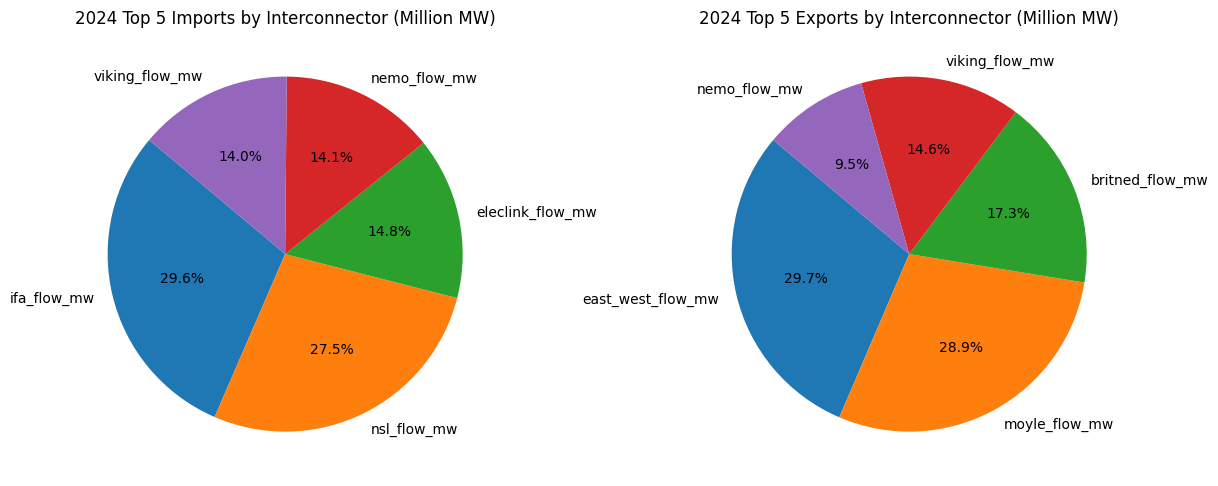

In [1384]:
# Pie chart for top 5 2024 imports and exports by interconnector

# Get 2024 row from interconnector_imports and interconnector_exports
imports_2024 = interconnector_imports[interconnector_imports['year'] == 2024].iloc[0, 1:]
exports_2024 = interconnector_exports[interconnector_exports['year'] == 2024].iloc[0, 1:]

# Get top 5 imports and exports for 2024
top5_imports_2024 = imports_2024.sort_values(ascending=False).head(5)
top5_exports_2024 = exports_2024.sort_values(ascending=False).head(5)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Imports pie
axes[0].pie(top5_imports_2024, labels=top5_imports_2024.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title('2024 Top 5 Imports by Interconnector (Million MW)')

# Exports pie
axes[1].pie(top5_exports_2024, labels=top5_exports_2024.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title('2024 Top 5 Exports by Interconnector (Million MW)')

plt.tight_layout()
plt.show()


### **Quaterly trend of demand in each year**

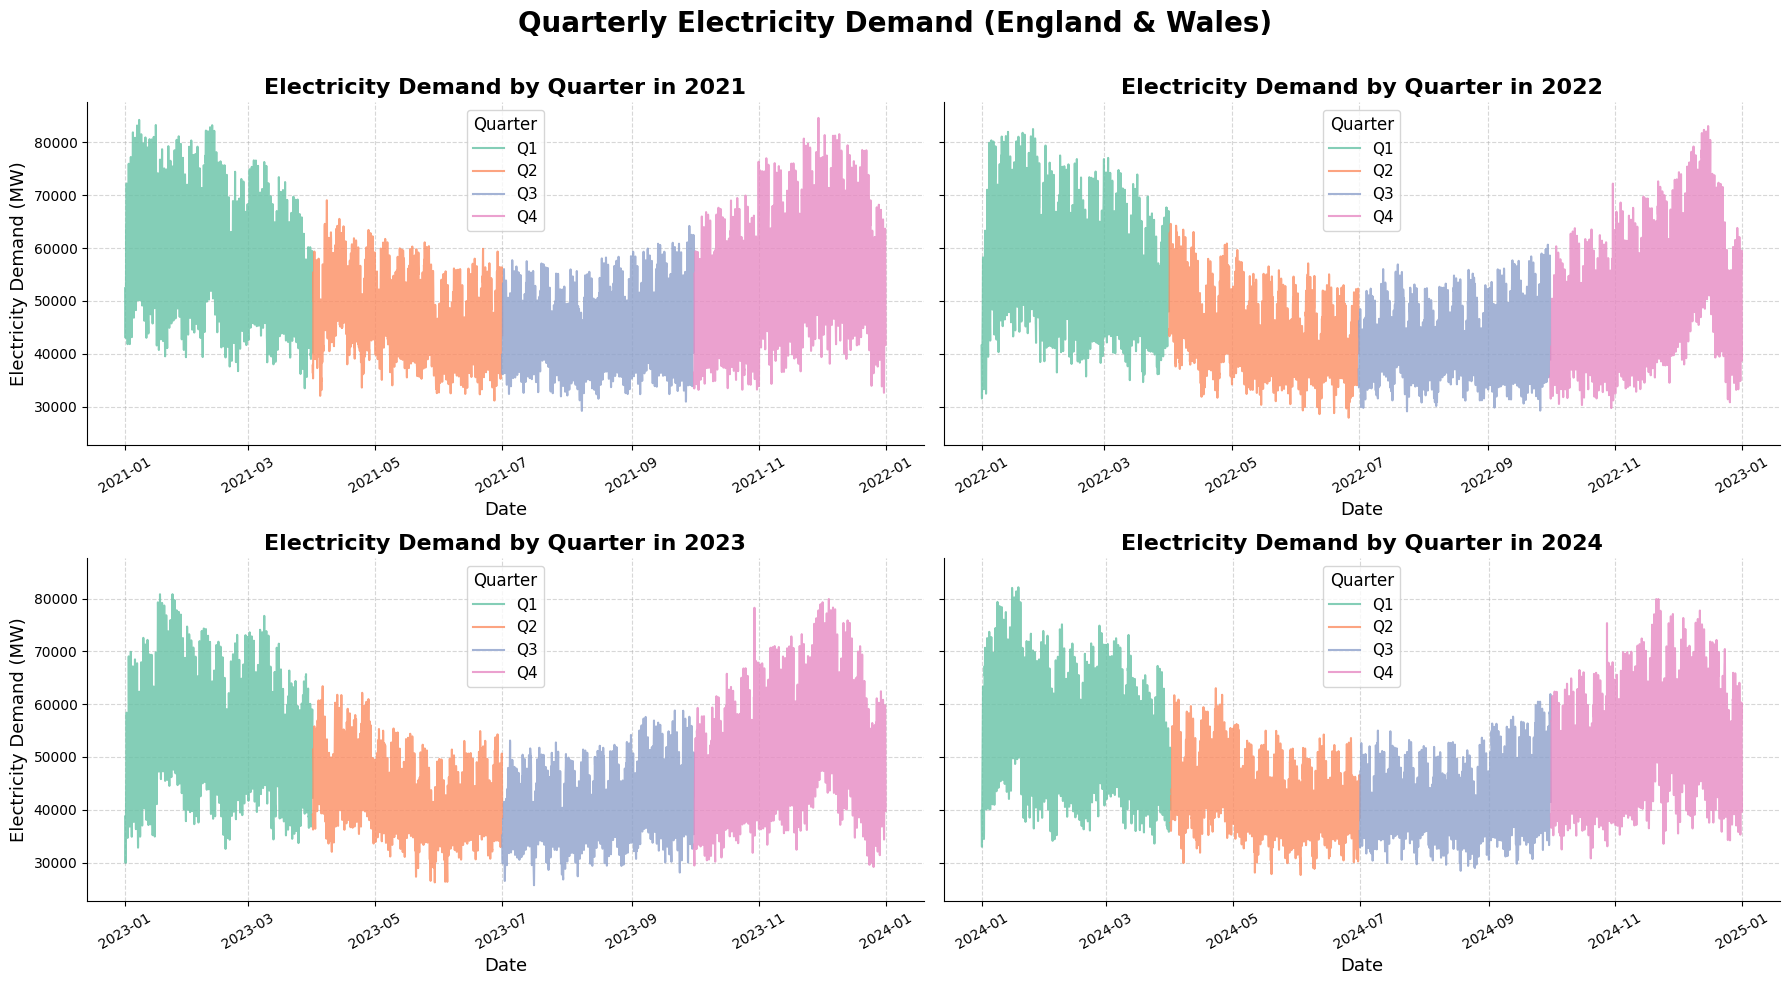

In [1385]:
quarter_palette = sns.color_palette("Set2", 4)
fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharey=True)
axes = axes.flatten()

for idx, y in enumerate(sorted(df['year'].unique())):
    ax = axes[idx]
    for q in range(1, 5):
        quarter_data = df[(df['year'] == y) & (df['timestamp'].dt.quarter == q)]
        if not quarter_data.empty:
            sns.lineplot(
                data=quarter_data,
                x='timestamp',
                y='england_wales_demand_mw',
                label=f'Q{q}',
                color=quarter_palette[q-1],
                alpha=0.8,
                ax=ax
            )
    ax.set_title(f'Electricity Demand by Quarter in {y}', fontsize=16, weight='bold')
    ax.set_xlabel('Date', fontsize=13)
    ax.set_ylabel('Electricity Demand (MW)', fontsize=13)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(axis='x', rotation=30)
    ax.legend(title='Quarter', fontsize=11, title_fontsize=12)
    # Show legend only for the first subplot
    #if idx == 0:
    #    ax.legend(title='Quarter', fontsize=11, title_fontsize=12)
    #else:
    #    ax.get_legend().remove()

plt.suptitle('Quarterly Electricity Demand (England & Wales)', fontsize=20, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
sns.despine()
plt.show()



---
**Observation:**
* From the above graphs it is clear that overall peaks are same in each year. Demand slightly lower in first quater of 2024 as compared to 2021.

* Another interesting factor is that a clear seasonality is visible in the data, with peaks in the winter months and valleys in the summer months for all years.

* As we can see that there is a sharp drop in Q4 at the end of december this is beacuse of public holidays (Christmas) in the last two weeks of the december which means reducion in commercial activity as well as industrial activity.

----

### **checking the relation between the temperature and demand**


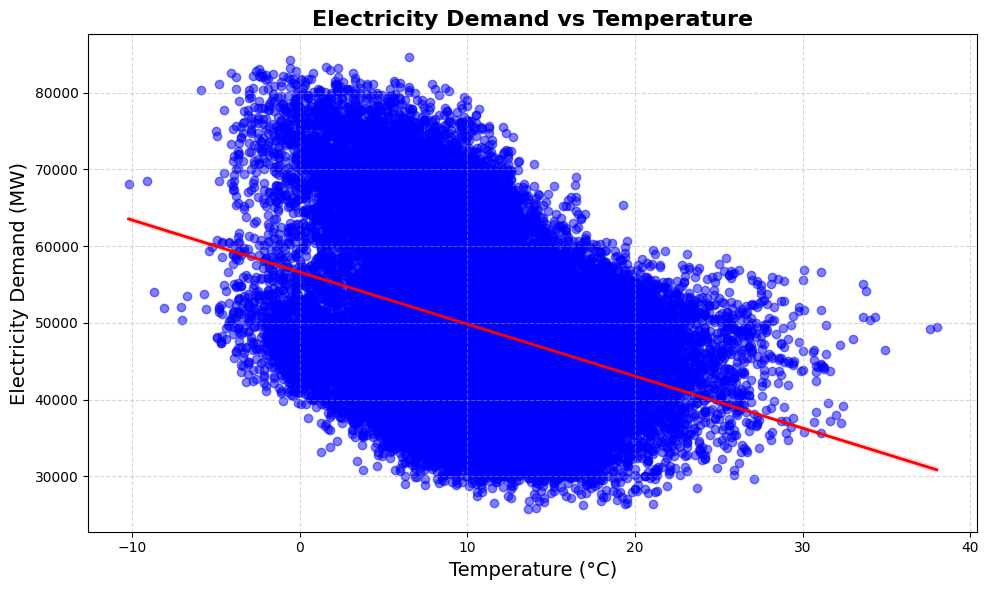

In [1386]:
# plotting the regplot of demand vs temperature
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df,
    x='temperature_C',
    y='england_wales_demand_mw',
    scatter_kws={'alpha': 0.5, 'color': 'blue'},
    line_kws={'color': 'red', 'linewidth': 2}
)
plt.title('Electricity Demand vs Temperature', fontsize=16, weight='bold')
plt.xlabel('Temperature (°C)', fontsize=14)
plt.ylabel('Electricity Demand (MW)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show() 

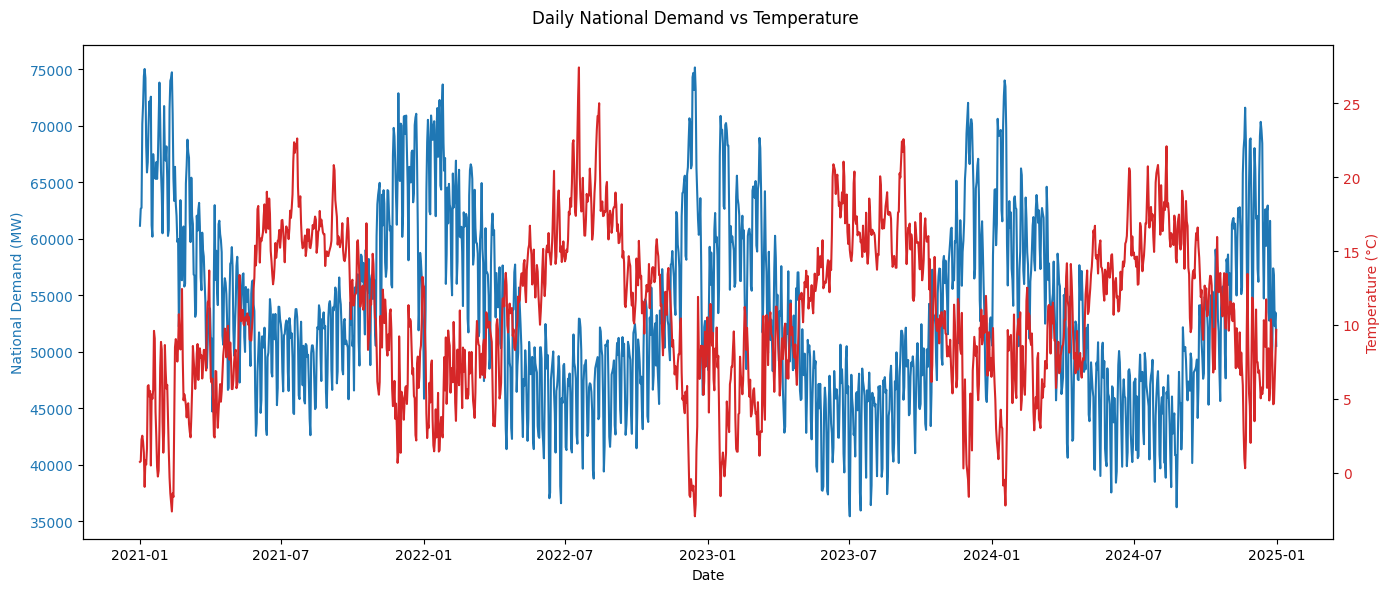

In [1387]:

# Set the index to the datetime column before resampling
df_daily = df.set_index('timestamp')

# Create daily combined DataFrame with mean demand and temperature
combined = df_daily.resample('D').agg({
	'national_demand_mw': 'mean',
	'temperature_C': 'mean'
}).rename(columns={'temperature_C': 'temperature_celsius'})

fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot demand
ax1.plot(combined.index, combined['national_demand_mw'], color='tab:blue', label='National Demand (MW)')
ax1.set_xlabel('Date')
ax1.set_ylabel('National Demand (MW)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot temperature on secondary axis
ax2 = ax1.twinx()
ax2.plot(combined.index, combined['temperature_celsius'], color='tab:red', label='Temperature (°C)')
ax2.set_ylabel('Temperature (°C)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.suptitle('Daily National Demand vs Temperature')
fig.tight_layout()
plt.show()


---
**Observation:**
* As from the above graph we can clearly see that with an increase in temperture there is huge decrease in demand.

* Actually, the temperature and demand are following inverse correlation.

---

### **Different Weather Factors Impact on Demand**

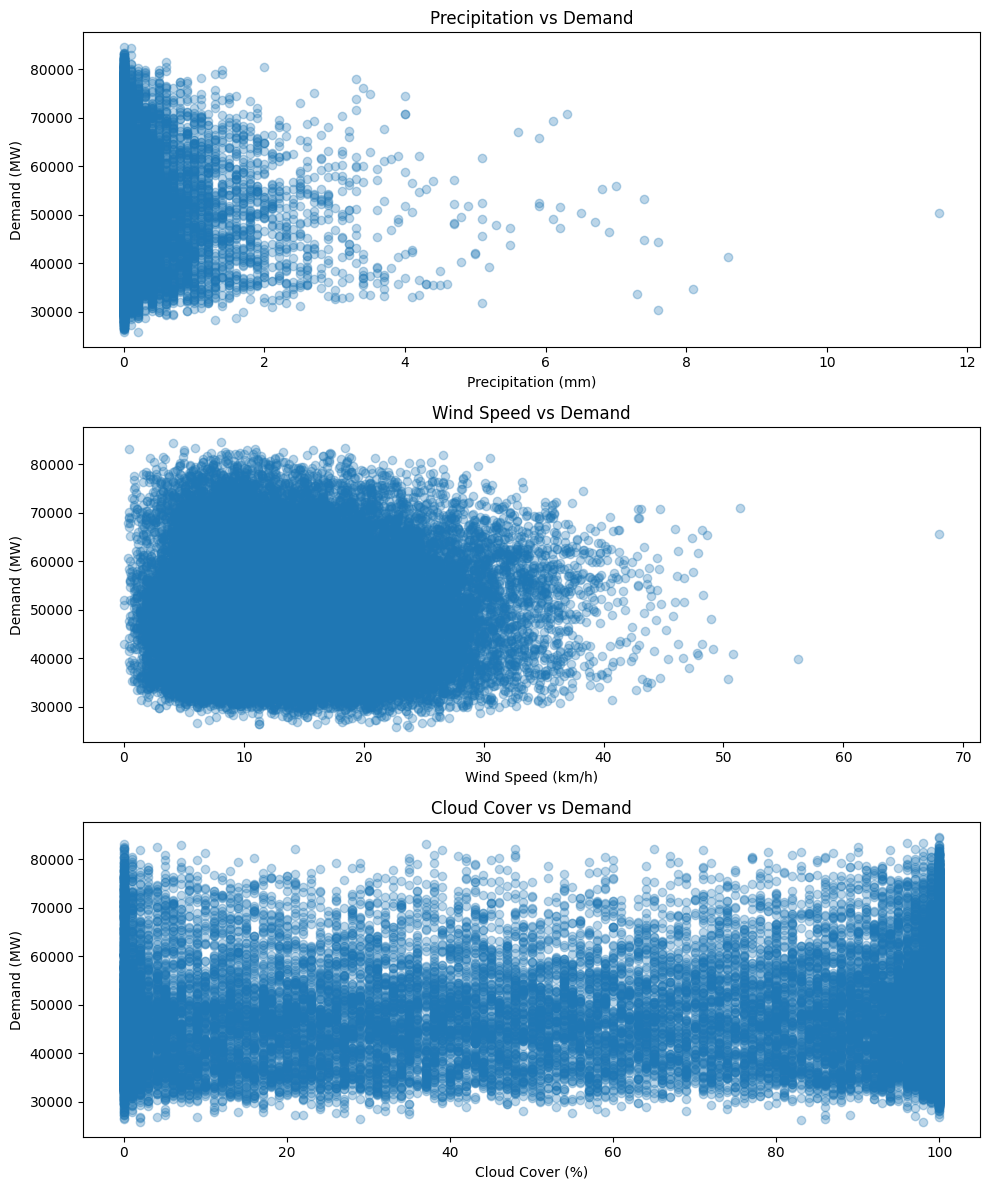

In [1388]:
# Weather impact: Precipitation, Wind, Cloudcover
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

axs[0].scatter(df["precip_mm"], df["england_wales_demand_mw"], alpha=0.3)
axs[0].set_title("Precipitation vs Demand")
axs[0].set_xlabel("Precipitation (mm)")
axs[0].set_ylabel("Demand (MW)")

axs[1].scatter(df["windspeed_kmh"], df["england_wales_demand_mw"], alpha=0.3)
axs[1].set_title("Wind Speed vs Demand")
axs[1].set_xlabel("Wind Speed (km/h)")
axs[1].set_ylabel("Demand (MW)")

axs[2].scatter(df["cloudcover_pct"], df["england_wales_demand_mw"], alpha=0.3)
axs[2].set_title("Cloud Cover vs Demand")
axs[2].set_xlabel("Cloud Cover (%)")
axs[2].set_ylabel("Demand (MW)")

plt.tight_layout()
plt.show()


---

**Observation:**

* Although the percepitation and demand shows some correlation as the percipitation increases the demand decrease. However, the wind speed and cloud cover does not show any correlation with the demand.   

---

### **Demand by Day of Week**

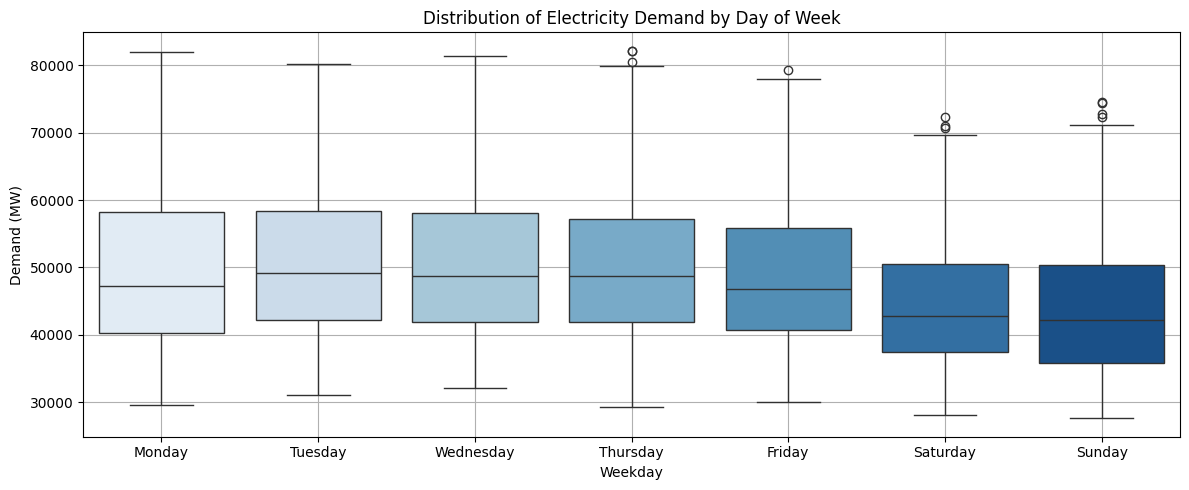

In [1389]:
plt.figure(figsize=(12, 5))
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Assign weekday names from timestamp
df_year['weekday'] = df_year['timestamp'].dt.day_name()
df_year['weekday'] = pd.Categorical(df_year['weekday'], categories=weekday_order, ordered=True)

sns.boxplot(
	x='weekday',
	y='england_wales_demand_mw',
	data=df_year,
	order=weekday_order,
	palette="Blues",
)
plt.title("Distribution of Electricity Demand by Day of Week")
plt.xlabel("Weekday")
plt.ylabel("Demand (MW)")
plt.grid(True)
plt.tight_layout()
plt.show()


---
**Observation:**

* In the above graph we can see that the demand is highest on Monday and lowest on Sunday.
Tuesday and Wednesday demand is same.

----

### **Hourly Demand Distribution**


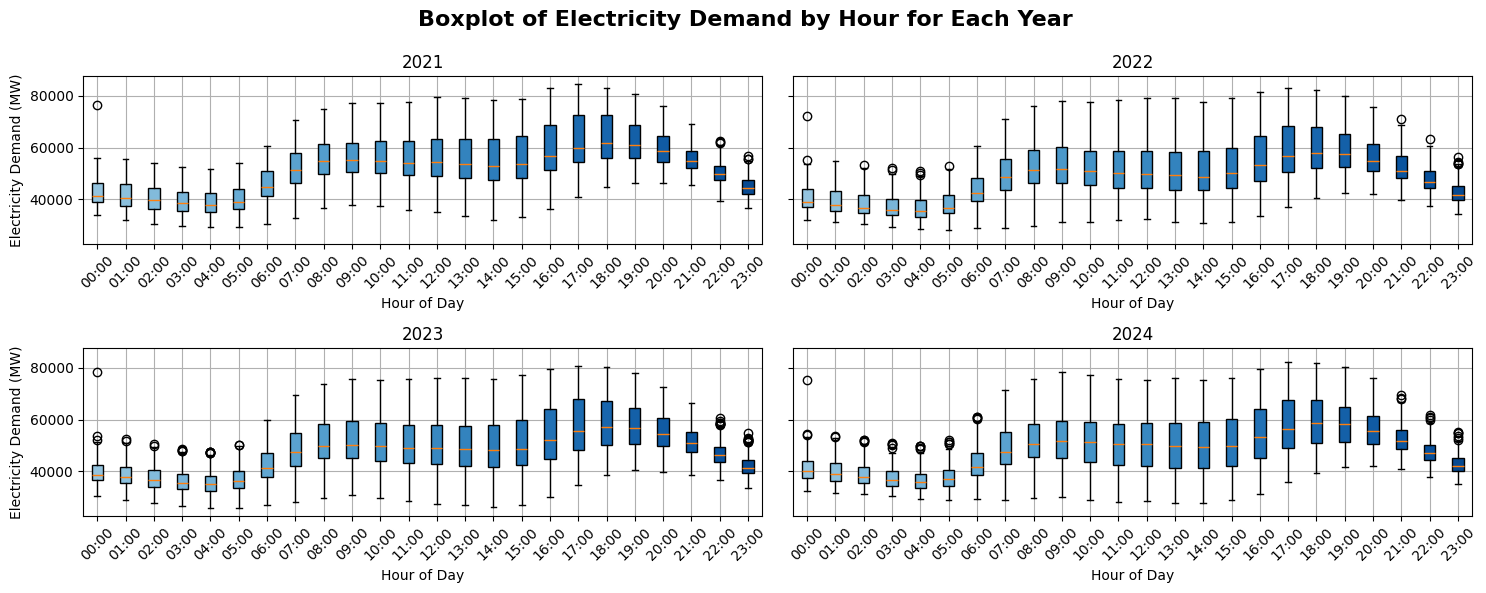

In [1390]:
import matplotlib.cm as cm

years = sorted(df['year'].unique())
fig, axes = plt.subplots(2, 2, figsize=(15, 6), sharey=True)
axes = axes.flatten()

# Natural 24-hour day: 00:00 to 23:00
hour_order = list(range(0, 24))
hour_labels = [f"{h:02d}:00" for h in hour_order]

for i, year in enumerate(years):
    ax = axes[i]
    df_y = df[df['year'] == year].copy()
    df_y['hour'] = df_y['timestamp'].dt.hour
    grouped = df_y.groupby('hour')['england_wales_demand_mw']
    
    # Reorder demand data to match natural hour order
    hourly_demand_lists = [grouped.get_group(h).tolist() for h in hour_order]
    
    # Color map from light to dark blue
    colors = cm.Blues(np.linspace(0.4, 0.9, len(hour_labels)))
    
    # Boxplot
    box = ax.boxplot(hourly_demand_lists, positions=range(24), widths=0.4, patch_artist=True)
    
    # Color each box
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_xticks(range(24))
    ax.set_xticklabels(hour_labels, rotation=45)
    ax.set_xlabel("Hour of Day")
    ax.set_title(f"{year}")
    
    if i % 2 == 0:
        ax.set_ylabel("Electricity Demand (MW)")
    ax.grid(True)

fig.suptitle("Boxplot of Electricity Demand by Hour for Each Year", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


In [1391]:
# Find out the highest national demand for 00:00 hour in each year, and print the hour and day as well
idx = df[df['timestamp'].dt.hour == 0].groupby('year')['england_wales_demand_mw'].idxmax()
highest_demand_00 = df.loc[idx, ['year', 'timestamp', 'england_wales_demand_mw']]
highest_demand_00['hour'] = highest_demand_00['timestamp'].dt.hour
highest_demand_00['day'] = highest_demand_00['timestamp'].dt.date
print("Highest National Demand at 00:00 for each year (with hour and day):")
display(highest_demand_00[['year', 'england_wales_demand_mw', 'hour', 'day']])

Highest National Demand at 00:00 for each year (with hour and day):


year  england_wales_demand_mw  hour         day
7295   2021                    76352     0  2021-11-01
16030  2022                    72212     0  2022-10-31
24765  2023                    78244     0  2023-10-30
33500  2024                    75338     0  2024-10-28

---
**Observation:**

* As we can see that from 12 A.M. to 5 A.M. the demand is lowest in all , and from 4 P.M. to 8 P.M. the demand is highest and to my surprise the peaks are same in all four years.
There are some days in each year where demand is highest at 12 A.M.

---

In [1392]:
df.head(2)

timestamp  national_demand_mw  transmission_demand_mw  \
0 2021-01-01 00:00:00               56855                   58083   
1 2021-01-01 01:00:00               54671                   56125   

   england_wales_demand_mw  embedded_wind_gen_mw  embedded_solar_gen_mw  \
0                    52411                  2366                      0   
1                    50349                  2428                      0   

   non_bm_stor_mw  pump_storage_pumping_mw  ifa_flow_mw  ifa2_flow_mw  \
0               0                       26         4007            -2   
1               0                      252         4008            -2   

   britned_flow_mw  moyle_flow_mw  east_west_flow_mw  nemo_flow_mw  \
0                0            574                406          1998   
1                0            723                405          1999   

   nsl_flow_mw  eleclink_flow_mw  viking_flow_mw  greenlink_flow_mw  \
0            0                 0               0                  0   
1            0                 0               0                  0   

   scottish_transfer_mw  embedded_wind_cap_mw  temperature_C  precip_mm  \
0                   0.0                  6527           -1.4        0.0   
1                   0.0                  6527           -0.7        0.0   

   cloudcover_pct  windspeed_kmh  day  month day_of_week  year  is_weekend  \
0           100.0            2.5    1      1      Friday  2021       False   
1            59.0            4.7    1      1      Friday  2021       False   

   demand_roll_mean_6h  temp_roll_mean_6h  
0              56855.0              -1.40  
1              55763.0              -1.05

### **Heatmap of Avg Demand by Weekday and Hour of Day**

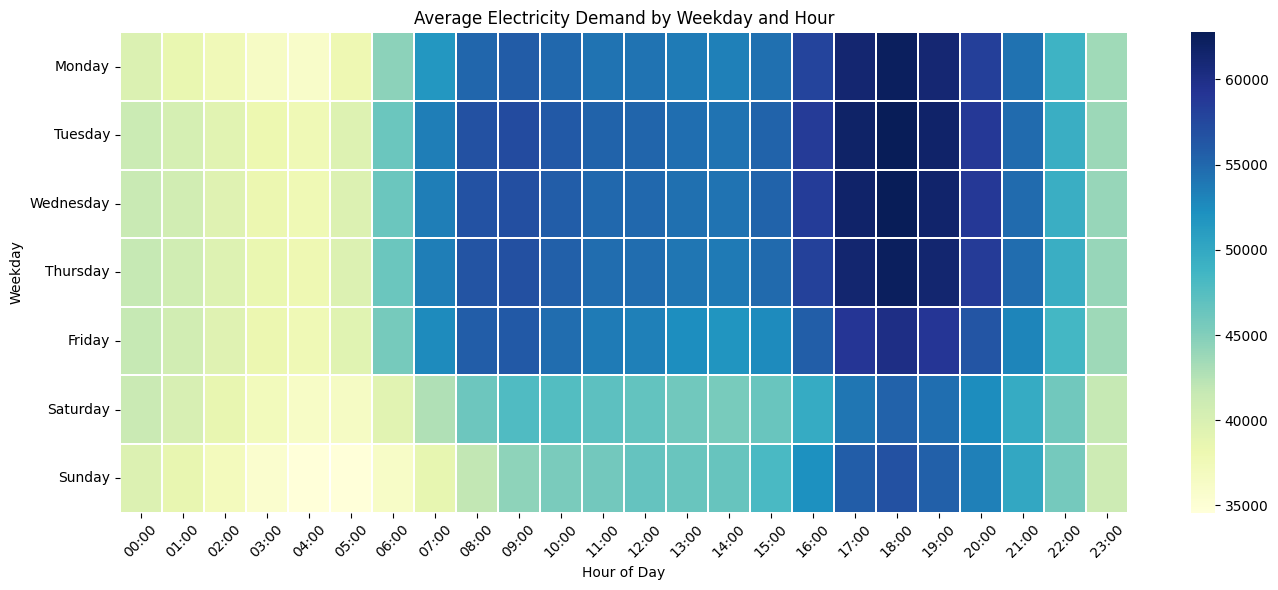

In [1393]:
# Ensure 'hour' column is created
df['hour'] = df['timestamp'].dt.hour

# Pivot table
heatmap_data = df.pivot_table(index='day_of_week', columns='hour', values='england_wales_demand_mw', aggfunc='mean')

# Ensure correct weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(weekday_order)

# Set hour labels so that 0 = 12am midnight is first
hour_labels = [f"{h:02d}:00" for h in range(24)]

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=0.3, annot=False)
plt.title("Average Electricity Demand by Weekday and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Weekday")
plt.xticks(ticks=np.arange(24) + 0.5, labels=hour_labels, rotation=45)
plt.tight_layout()
plt.show()

----
**Observation:**
* Above graph shows the heatmap of hourly average energy usage across all week days.
* In all days of the week demand from 12 to 5 A.M. is lowest and from 4 P.M. to 5 P.M. is highest in weekdays but in weekends it is at mid levels.

---

### **Demand by Month**

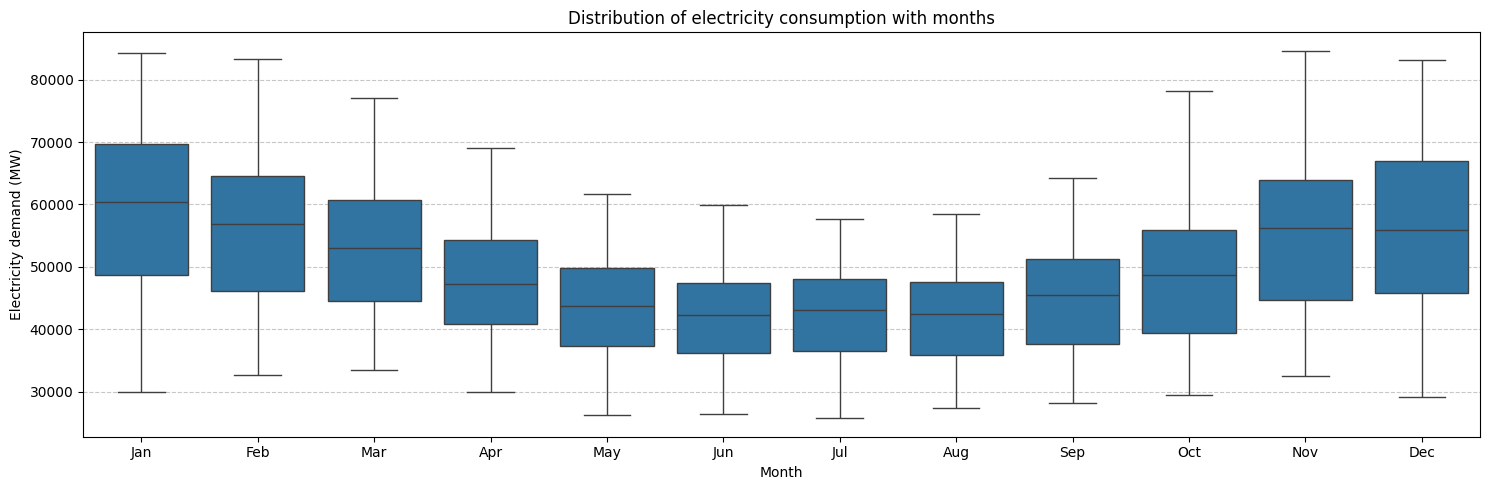

In [1394]:

fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="england_wales_demand_mw", data=df)

ax.set_xlabel("Month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with months")
ax.set_xticks(range(12))
ax.set_xticklabels([calendar.month_abbr[m] for m in range(1, 13)])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

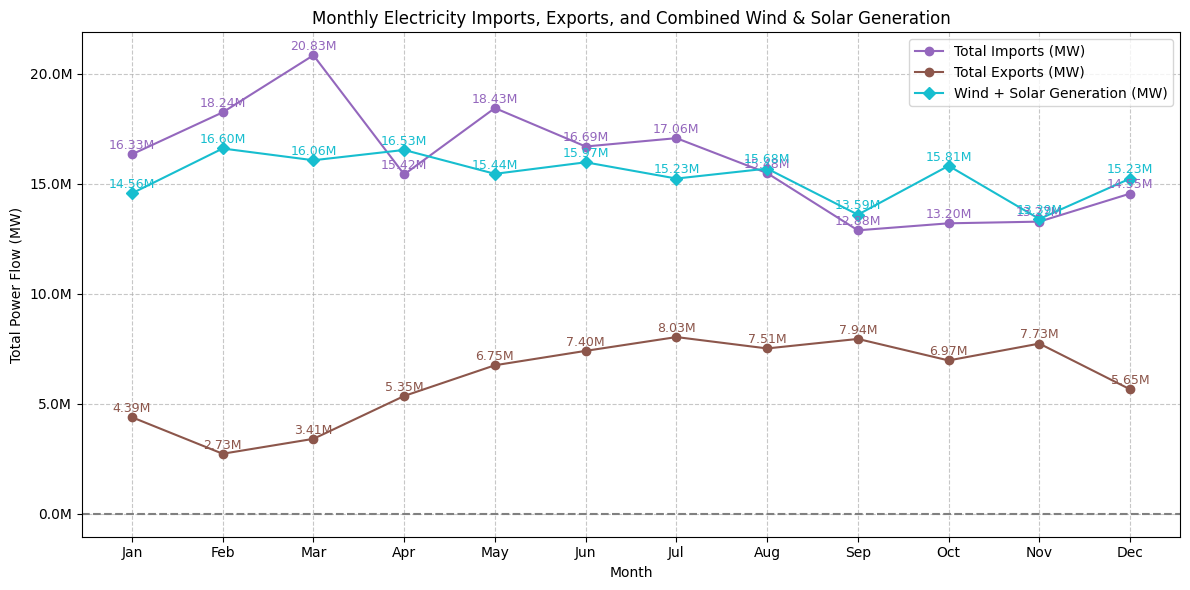

In [1395]:
from matplotlib.ticker import FuncFormatter

# Calculate monthly imports and exports
interconnector_cols = [
    "ifa_flow_mw", "ifa2_flow_mw", "britned_flow_mw", "moyle_flow_mw",
    "nemo_flow_mw", "eleclink_flow_mw", "viking_flow_mw", "greenlink_flow_mw"
]

# Use 'Month' column for grouping (already present in df)
# Imports: sum of positive values per month
import_monthly = df.groupby('month')[interconnector_cols].apply(lambda x: x.clip(lower=0).sum(axis=1)).groupby('month').sum()
# Exports: sum of negative values per month (as positive numbers)
export_monthly = -df.groupby('month')[interconnector_cols].apply(lambda x: x.clip(upper=0).sum(axis=1)).groupby('month').sum()

# Monthly wind and solar generation (combined)
monthly_gen = df.groupby('month')[['embedded_wind_gen_mw', 'embedded_solar_gen_mw']].sum()
monthly_gen['total_renewable_gen_mw'] = monthly_gen['embedded_wind_gen_mw'] + monthly_gen['embedded_solar_gen_mw']

def millions(x, pos):
    return f'{x*1e-6:.1f}M'

plt.figure(figsize=(12, 6))
plt.plot(import_monthly.index, import_monthly.values, label='Total Imports (MW)', color='tab:purple', marker='o')
plt.plot(export_monthly.index, export_monthly.values, label='Total Exports (MW)', color='tab:brown', marker='o')
plt.plot(monthly_gen.index, monthly_gen['total_renewable_gen_mw'].values, label='Wind + Solar Generation (MW)', color='tab:cyan', marker='D')

# Annotate values for each line
for i, v in enumerate(import_monthly.values):
    plt.text(import_monthly.index[i], v + 1e5, f"{v/1e6:.2f}M", color='tab:purple', ha='center', va='bottom', fontsize=9)
for i, v in enumerate(export_monthly.values):
    plt.text(export_monthly.index[i], v + 1e5, f"{v/1e6:.2f}M", color='tab:brown', ha='center', va='bottom', fontsize=9)
for i, v in enumerate(monthly_gen['total_renewable_gen_mw'].values):
    plt.text(monthly_gen.index[i], v + 1e5, f"{v/1e6:.2f}M", color='tab:cyan', ha='center', va='bottom', fontsize=9)

plt.xticks(import_monthly.index, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title("Monthly Electricity Imports, Exports, and Combined Wind & Solar Generation")
plt.xlabel("Month")
plt.ylabel("Total Power Flow (MW)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()


### **Temperature Distribution**

In [1396]:
# checking the temperature range
temp_range = df['temperature_C'].describe()
temp_range

count    35060.000000
mean        10.971825
std          5.822325
min        -10.200000
25%          7.000000
50%         10.900000
75%         15.000000
max         38.000000
Name: temperature_C, dtype: float64

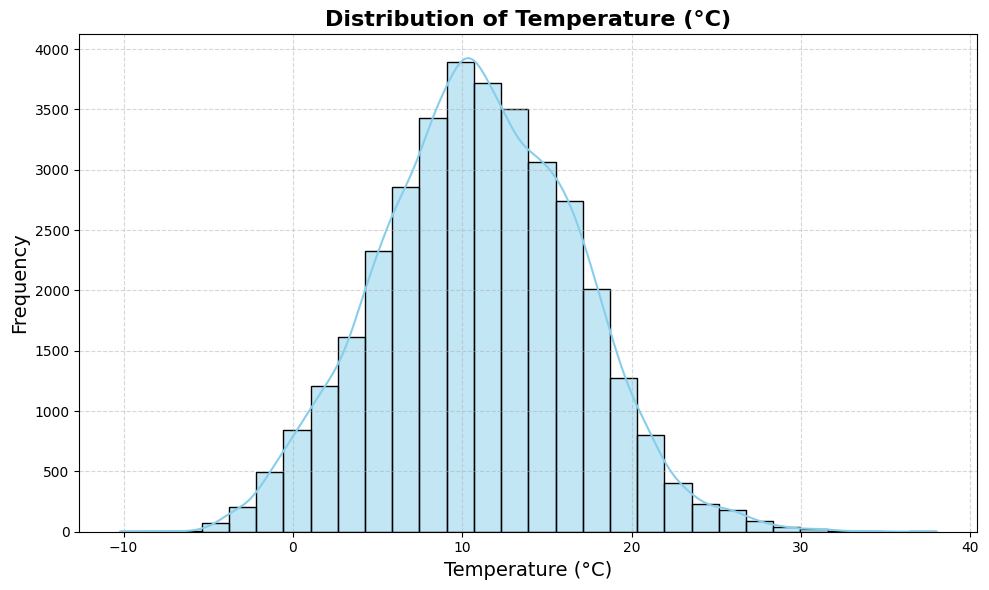

In [1397]:
# plotting the histogram of temperature
plt.figure(figsize=(10, 6))
sns.histplot(df['temperature_C'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Temperature (°C)', fontsize=16, weight='bold')
plt.xlabel('Temperature (°C)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### **Temperature Binning (Categorization)**

In [1398]:
bins = [-10, 0, 5, 10, 15, 20, 25, 35]
labels = [
    'Very Cold (<0°C)',
    'Cold (0–5°C)',
    'Cool (5–10°C)',
    'Moderate (10–15°C)',
    'Warm (15–20°C)',
    'Hot (20–25°C)',
    'Very Hot (>25°C)'
]

df['temp_binned'] = pd.cut(df['temperature_C'], bins=bins, labels=labels)

In [1399]:
df['temp_binned'].value_counts().sort_index()

temp_binned
Very Cold (<0°C)       1055
Cold (0–5°C)           4472
Cool (5–10°C)          9915
Moderate (10–15°C)    10875
Warm (15–20°C)         6761
Hot (20–25°C)          1621
Very Hot (>25°C)        358
Name: count, dtype: int64

----
**Observation:**

* Most of the time temperature remains between 5 to 15 degrees celsius.

---

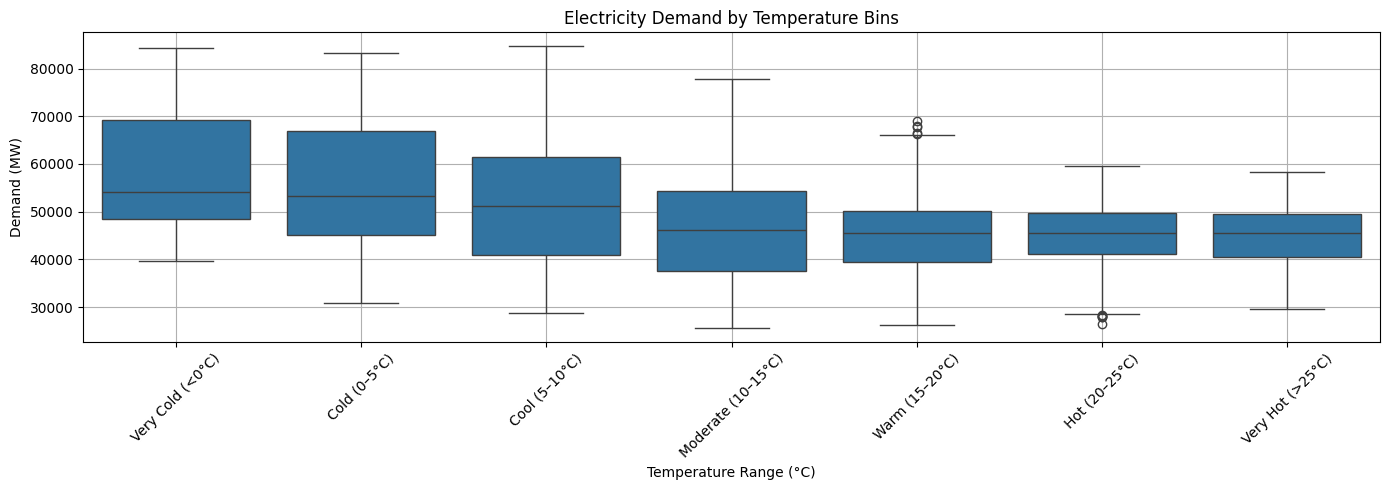

In [1400]:
plt.figure(figsize=(14, 5))
sns.boxplot(x='temp_binned', y='england_wales_demand_mw', data=df)
plt.xticks(rotation=45)
plt.title("Electricity Demand by Temperature Bins")
plt.xlabel("Temperature Range (°C)")
plt.ylabel("Demand (MW)")
plt.grid(True)
plt.tight_layout()
plt.show()

---
**Observation:**

* This shows that  when the temperature is low demand is low demand is high.

---


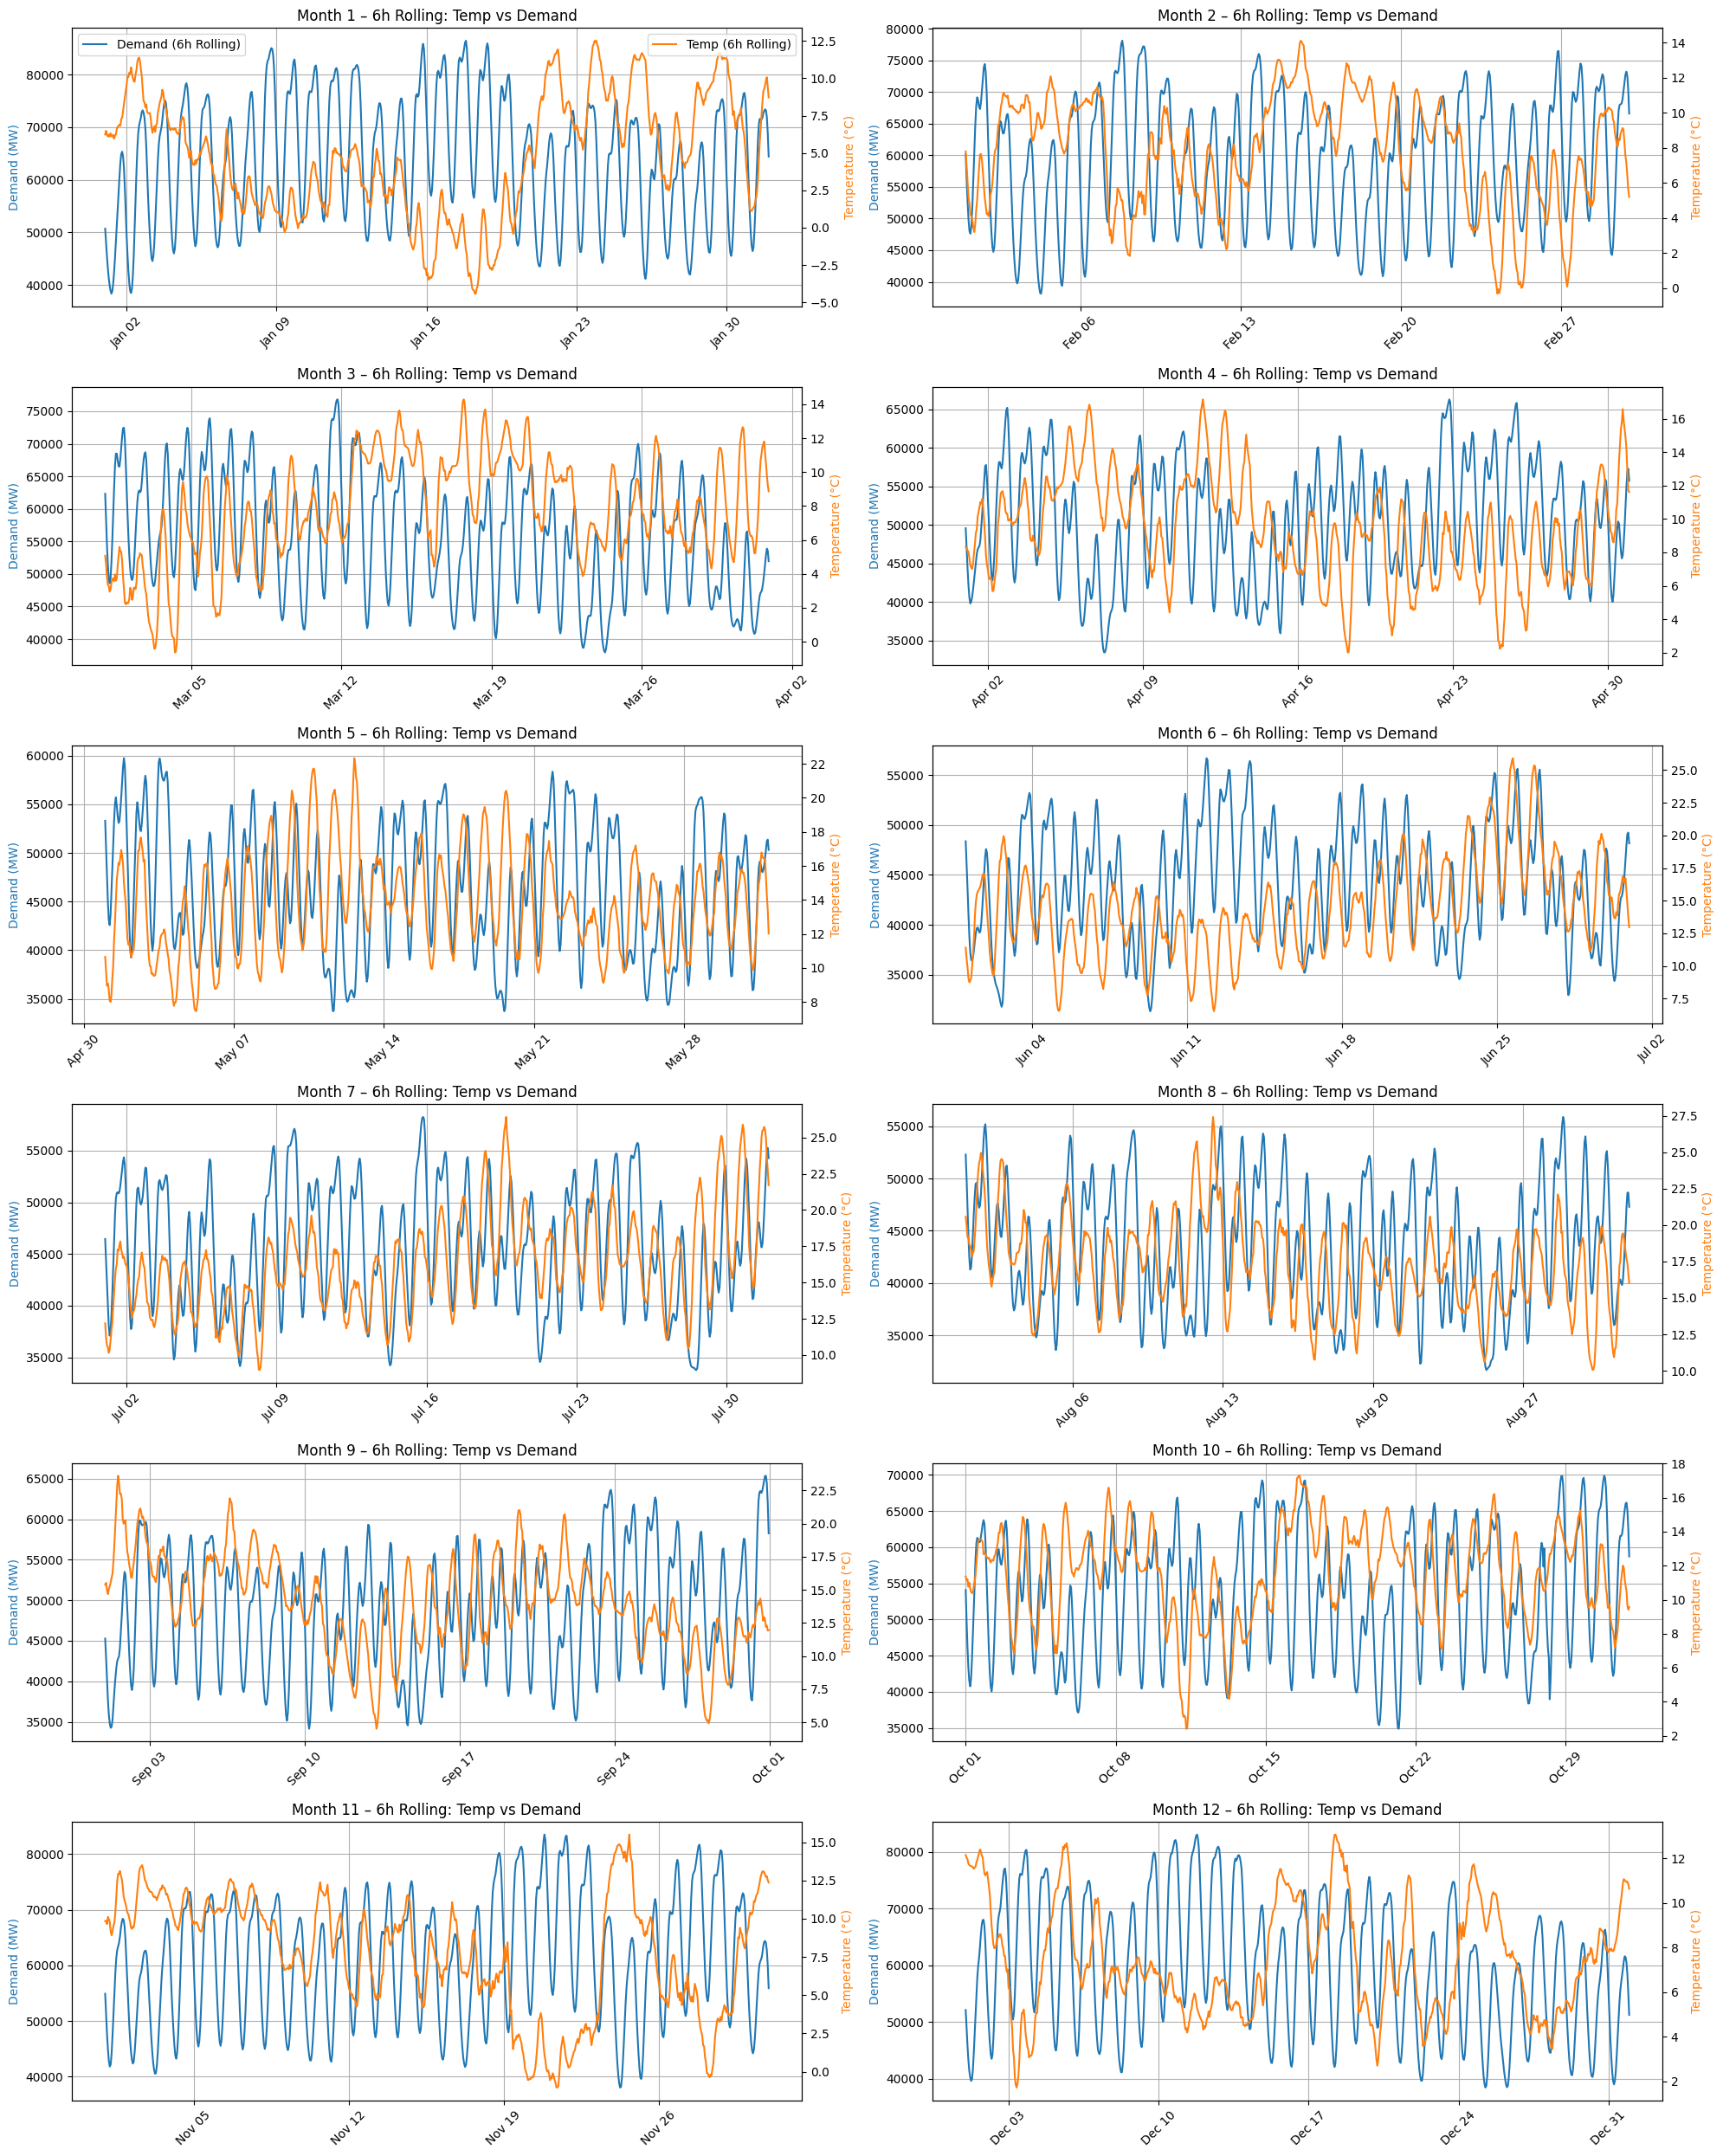

In [1401]:
# Import required formatter and locator
import matplotlib.dates as mdates

data_24 = df[df['year'] == 2024].copy()
data_24['month'] = data_24['timestamp'].dt.month
# Define sorted list of months
months = sorted(data_24['month'].unique())


# Create subplot grid
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(20, 25), sharex=False)
axes = axes.flatten()

for i, month in enumerate(months):
    subset = data_24[data_24['month'] == month]
    ax1 = axes[i]
    ax2 = ax1.twinx()  # Secondary y-axis

    # Plot demand and temperature
    ax1.plot(subset['timestamp'], subset['demand_roll_mean_6h'], color='tab:blue', label='Demand (6h Rolling)')
    ax2.plot(subset['timestamp'], subset['temp_roll_mean_6h'], color='tab:orange', label='Temp (6h Rolling)')

    # Set titles and labels
    ax1.set_title(f"Month {month} – 6h Rolling: Temp vs Demand")
    ax1.set_ylabel("Demand (MW)", color='tab:blue')
    ax2.set_ylabel("Temperature (°C)", color='tab:orange')

    # Format x-axis
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax1.tick_params(axis='x', rotation=45)

    # Grid and legends
    ax1.grid(True)
    if i == 0:
        ax1.legend(loc="upper left")
        ax2.legend(loc="upper right")

# Remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


---

**Observation:**

* Winter Months (e.g., Jan, Dec) show higher demand and lower temperature.

* Summer Months (e.g., June–August) show lower demand and higher temperature.

* Inverse relationship between temperature and demand is evident in colder months.

---

### **Anomaly Detection**

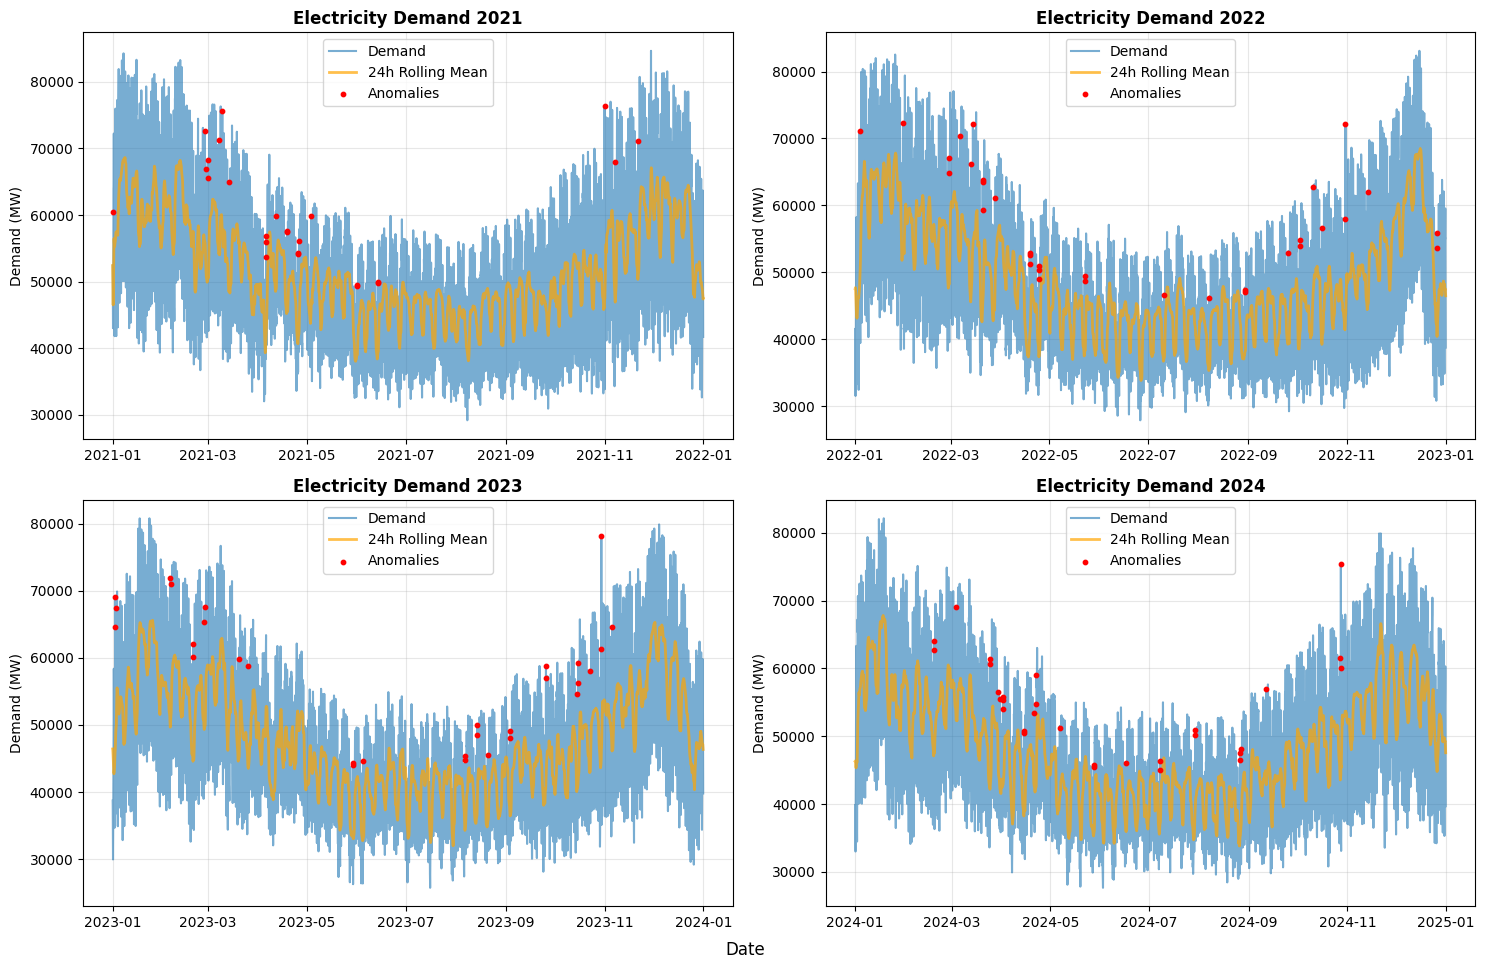

In [1402]:
# Ensure 'Year column exists
df['Year'] = df['timestamp'].dt.year

# Calculate 24-hour rolling mean (48 half-hour periods)
df['demand_roll_24h'] = df['england_wales_demand_mw'].rolling(window=24, min_periods=1).mean()

# Calculate rolling standard deviation for anomaly detection
df['demand_std_24h'] = df['england_wales_demand_mw'].rolling(window=24, min_periods=1).std()

# Define anomalies: Demand significantly exceeds rolling mean
df['anomaly'] = df['england_wales_demand_mw'] > (df['demand_roll_24h'] + 2 * df['demand_std_24h'])

# Unique years for plotting
years = sorted(df['Year'].unique())

# 2x2 Grid setup
n_rows = 2
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10), sharex=False)
axes = axes.flatten()

for i, year in enumerate(years):
    ax = axes[i]
    year_data = df[df['Year'] == year]

    # Plot raw demand
    ax.plot(year_data['timestamp'], year_data['england_wales_demand_mw'], label='Demand', alpha=0.6, color='tab:blue')

    # Plot 24-hour rolling mean
    ax.plot(year_data['timestamp'], year_data['demand_roll_24h'], label='24h Rolling Mean', linewidth=2, alpha=0.7, color='orange')

    # Plot anomalies
    anomalies = year_data[year_data['anomaly']]
    ax.scatter(anomalies['timestamp'], anomalies['england_wales_demand_mw'], color='red', label='Anomalies', zorder=5, s=10)

    # Styling
    ax.set_title(f"Electricity Demand {year}", fontsize=12, fontweight='bold')
    ax.set_ylabel('Demand (MW)')
    ax.grid(alpha=0.3)
    ax.legend()

# Remove extra axes if fewer than 4 years
for j in range(len(years), len(axes)):
    fig.delaxes(axes[j])

# Shared x-axis label
fig.text(0.5, 0.04, 'Date', ha='center', fontsize=12)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


### **Total Anomalies per Year**

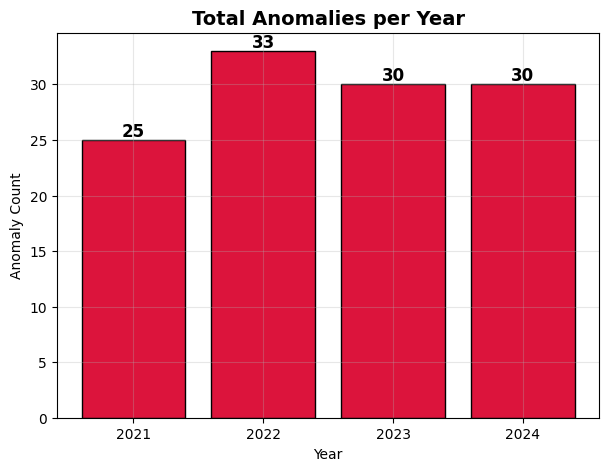

In [1403]:
anomaly_counts = df[df['anomaly']].groupby('Year').size().reset_index(name='Anomaly_Count')

plt.figure(figsize=(7, 5))
bars = plt.bar(anomaly_counts['Year'].astype(str), anomaly_counts['Anomaly_Count'], color='crimson', edgecolor='black')
plt.title('Total Anomalies per Year', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Anomaly Count')
plt.grid(alpha=0.3)
plt.xticks(anomaly_counts['Year'].astype(str))

# Add value labels on each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()


### **Monthly Trend In Anamolies**

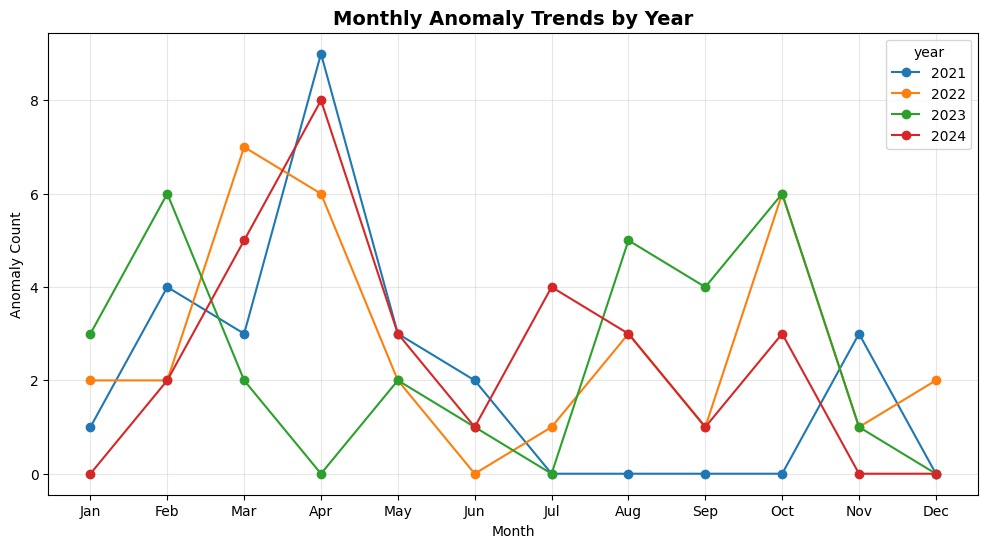

In [1404]:

monthly_anomalies = df[df['anomaly']].groupby(['year', 'month']).size().unstack(fill_value=0)

monthly_anomalies.T.plot(figsize=(12,6), marker='o')
plt.title('Monthly Anomaly Trends by Year', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Anomaly Count')
plt.xticks(ticks=range(1,13), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.grid(alpha=0.3)
plt.show()


In [1405]:
# average temperature for the april month for each year
april_avg_temp = df[df['month'] == 4].groupby('year')['temperature_C'].mean().reset_index()
april_avg_temp['temperature_C'] = april_avg_temp['temperature_C'].round(2)
print("Average Temperature for April Month in Each Year:")
print(april_avg_temp)

Average Temperature for April Month in Each Year:
   year  temperature_C
0  2021           6.58
1  2022           9.27
2  2023           8.55
3  2024           9.41


---
**Observation:**

* As we can see from graph monthly trend of anamolies in electricity demand.In 2021 & 2024 system experienced a peak in April where as for 2023 the senarios is totally different as national grid faced highest demand of the year in March.

* for 2024 it is lower for april whereas for 2021 it is all time higer.

----

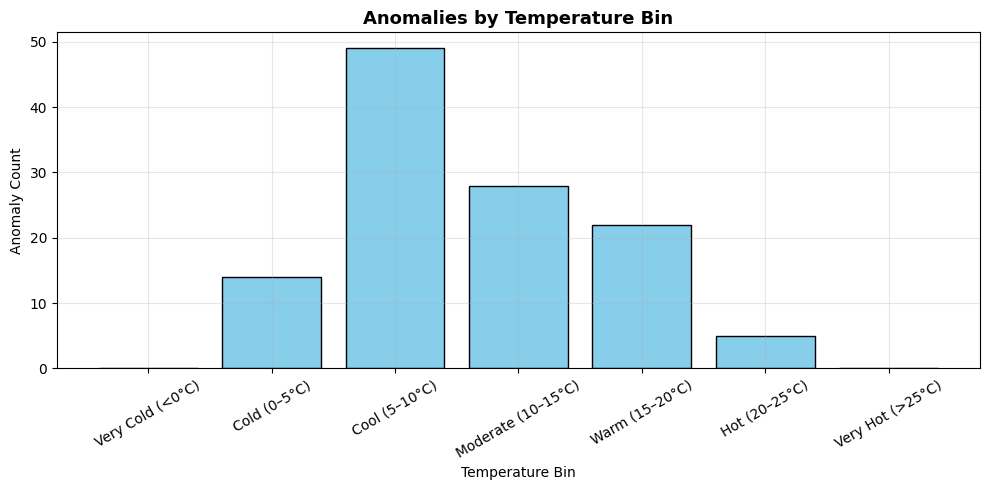

In [1406]:
# Count anomalies by your own temperature bins
temp_bin_anomalies = df[df['anomaly']]['temp_binned'].value_counts().sort_index()

# Bar plot
plt.figure(figsize=(10, 5))
plt.bar(temp_bin_anomalies.index.astype(str), temp_bin_anomalies.values, color='skyblue', edgecolor='black')
plt.title('Anomalies by Temperature Bin', fontsize=13, fontweight='bold')
plt.xlabel('Temperature Bin')
plt.ylabel('Anomaly Count')
plt.xticks(rotation=30)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


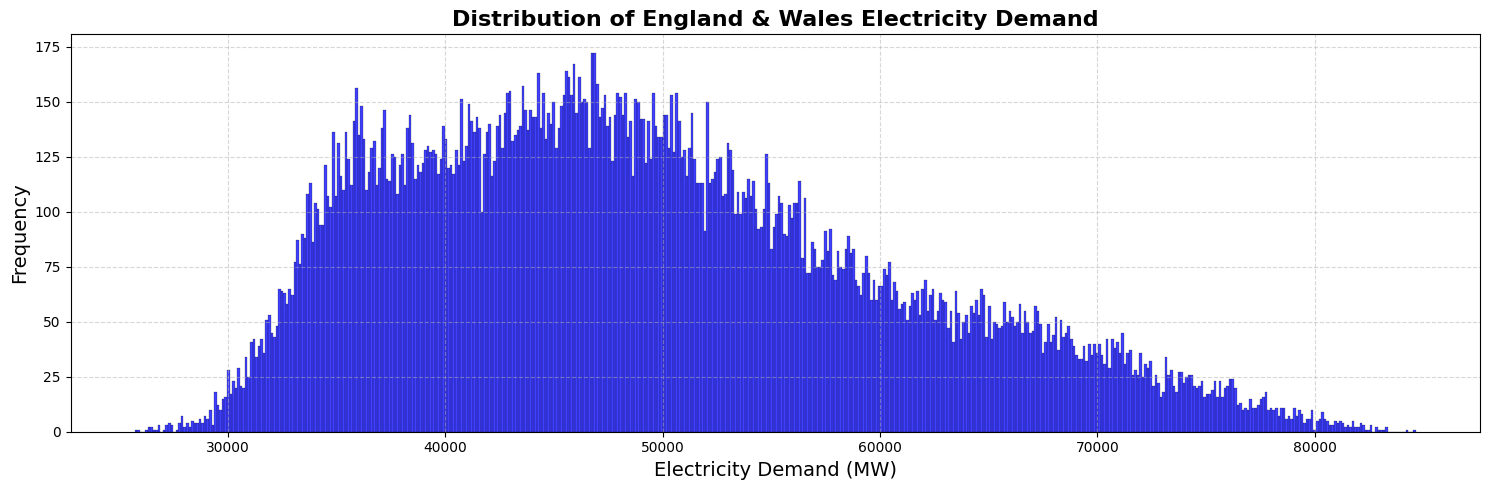

In [1407]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(data=df, x="england_wales_demand_mw", bins=500, ax=ax, color="b")
ax.set_title("Distribution of England & Wales Electricity Demand", fontsize=16, weight='bold')
ax.set_xlabel("Electricity Demand (MW)", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

----

**Observation:**

* As from the histogram we can get an idea the demand is concentrated in between 35000 to 40000 MW.
* And the most peaks and frequiencies lies in between 40K to 50K MW.

---

### **Weekly Seasonality Analysis**

Datetime index set. Range: 2021-01-01 00:00:00 to 2024-12-31 23:00:00
Total records: 35060
Unique days present: 1461

Decomposing Weekly Seasonality (7-day period):


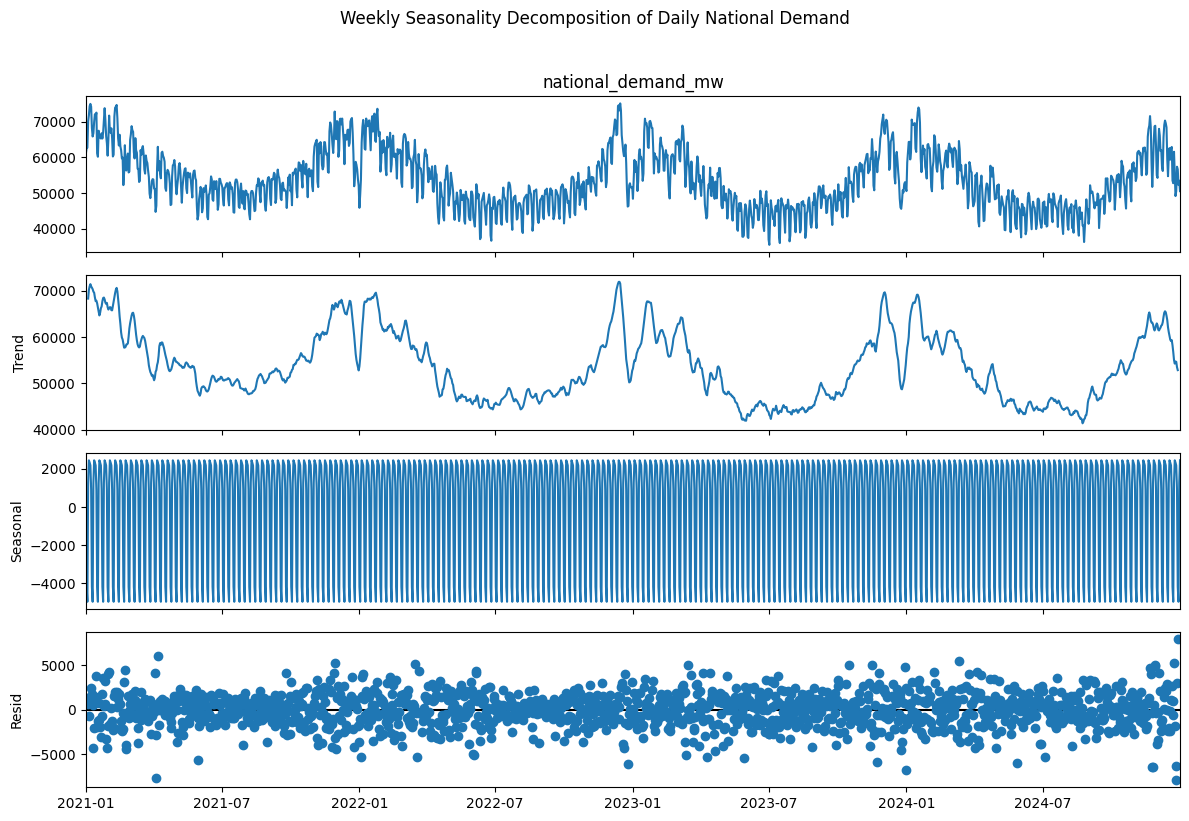

In [1408]:

from statsmodels.tsa.seasonal import seasonal_decompose

# --- Datetime & Daily Aggregation ---
# Ensure the index is datetime for time series operations
df = df.set_index('timestamp')

print(f"Datetime index set. Range: {df.index.min()} to {df.index.max()}")
print(f"Total records: {len(df)}")
print(f"Unique days present: {df.index.normalize().nunique()}")

# Resample to daily mean
daily_demand = df['national_demand_mw'].resample('D').mean().interpolate(method='time')
valid_days = daily_demand.dropna()

# --- Weekly Seasonality ---
print("\nDecomposing Weekly Seasonality (7-day period):")
if len(valid_days) >= 14:
    weekly_decomp = seasonal_decompose(valid_days, model='additive', period=7)
    fig = weekly_decomp.plot()
    fig.set_size_inches(12, 8)
    fig.suptitle('Weekly Seasonality Decomposition of Daily National Demand', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data for weekly decomposition (need at least 14 days).")


----

**Observation:**
* First plot shows the national demand over the period between 2021-24 and it shows consistancy over the years.
* The second plot indicates the trend and it clearly shows seasonly peaks in winter months and valleys in summer months.
* Whereas third graph with seasonality indicates the weekly smoothness of the demand with smooth weekly grid operations.
* Bottom plot indicates the residuals data which left after subtracting trends from seasonality and sudden changes in that indicates the peaks in weather or any other factors which affects the demand.

----


### **Yearly Seasonality Decomposition**

Datetime index set. Range: 2021-01-01 00:00:00 to 2024-12-31 23:00:00
Total records: 35060
Unique days present: 1461

Decomposing Yearly Seasonality (365-day period):


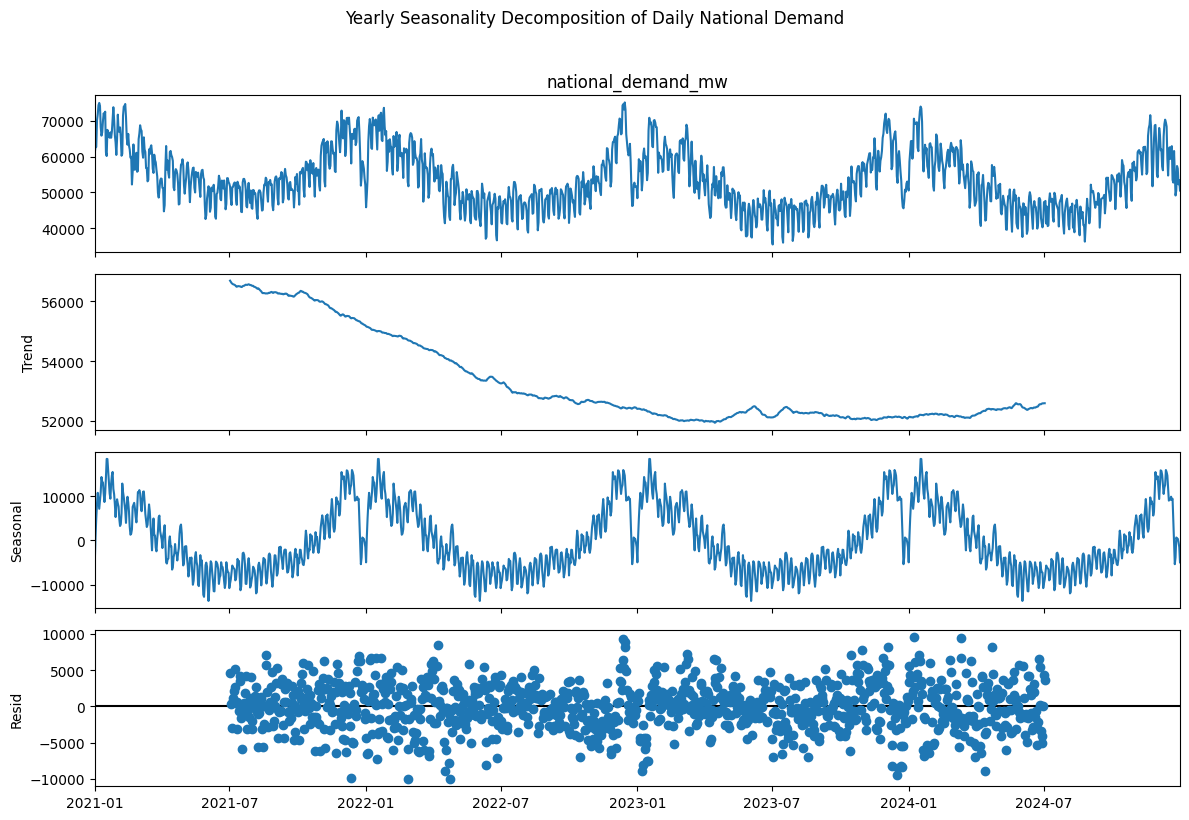

In [1409]:
from statsmodels.tsa.seasonal import seasonal_decompose

# --- Datetime & Daily Aggregation ---
print(f"Datetime index set. Range: {df.index.min()} to {df.index.max()}")
print(f"Total records: {len(df)}")
print(f"Unique days present: {df.index.normalize().nunique()}")

# Resample to daily mean
daily_demand = df['national_demand_mw'].resample('D').mean().interpolate(method='time')
valid_days = daily_demand.dropna()

# --- Yearly Seasonality ---
print("\nDecomposing Yearly Seasonality (365-day period):")
if len(valid_days) >= 730:
    yearly_decomp = seasonal_decompose(valid_days, model='additive', period=365)
    fig = yearly_decomp.plot()
    fig.set_size_inches(12, 8)
    fig.suptitle('Yearly Seasonality Decomposition of Daily National Demand', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print(f"Not enough data for yearly decomposition (need at least 730 days, found {len(valid_days)}).")


---

**Observation:**
* This trend graph indicates that gradual decrease in demand from 2022 onwards.
Yearly seasonality shows that there is a peak in demand in the winter months of the year.

> * Data clearly shows both yearly and weekly seasonality but due to lack of system constraints I only use weekly seasonality for modeling. 
---

### **Outlier Detection**

In [1410]:
# 1. Calculate Z-score for national demand
df['z_score_demand'] = (df['national_demand_mw'] - df['national_demand_mw'].mean()) / df['national_demand_mw'].std()

# 2. Identify outliers (Z-score > 3 or < -3)
outliers = df[np.abs(df['z_score_demand']) > 3]

# Optional: Print or inspect
print(f"Number of outliers: {len(outliers)}")


Number of outliers: 17


In [1411]:
# checking the outliers
outliers.reset_index()[['timestamp', 'national_demand_mw', 'z_score_demand', 'temp_binned','temperature_C']]


timestamp  national_demand_mw  z_score_demand       temp_binned  \
0  2021-01-06 17:00:00               91956        3.142087      Cold (0–5°C)   
1  2021-01-06 18:00:00               90872        3.053152      Cold (0–5°C)   
2  2021-01-07 17:00:00               92838        3.214450  Very Cold (<0°C)   
3  2021-01-07 18:00:00               91101        3.071940  Very Cold (<0°C)   
4  2021-01-15 17:00:00               90773        3.045029      Cold (0–5°C)   
5  2021-02-09 17:00:00               90718        3.040517  Very Cold (<0°C)   
6  2021-02-09 18:00:00               90250        3.002120  Very Cold (<0°C)   
7  2021-02-10 17:00:00               91105        3.072268  Very Cold (<0°C)   
8  2021-02-10 18:00:00               91583        3.111485  Very Cold (<0°C)   
9  2021-02-11 17:00:00               90540        3.025913  Very Cold (<0°C)   
10 2021-02-11 18:00:00               91250        3.084164  Very Cold (<0°C)   
11 2021-11-29 17:00:00               90996        3.063325     Cool (5–10°C)   
12 2022-12-12 17:00:00               90715        3.040271      Cold (0–5°C)   
13 2022-12-13 17:00:00               90601        3.030918  Very Cold (<0°C)   
14 2022-12-15 16:00:00               90487        3.021565  Very Cold (<0°C)   
15 2022-12-15 17:00:00               92111        3.154804  Very Cold (<0°C)   
16 2022-12-15 18:00:00               90950        3.059551  Very Cold (<0°C)   

    temperature_C  
0             2.3  
1             0.8  
2            -0.6  
3            -0.2  
4             1.6  
5            -1.0  
6            -0.6  
7            -4.1  
8            -2.6  
9            -2.3  
10           -0.6  
11            6.5  
12            0.7  
13           -1.6  
14           -2.0  
15           -2.4  
16           -2.2

----

**Obsrvation:**

* From the outlier detection using z-score we can get an idea that there are 17 outliers in our dataset.
* Mainly these outliers in 2021 and 2022 due to peak in demand 

---

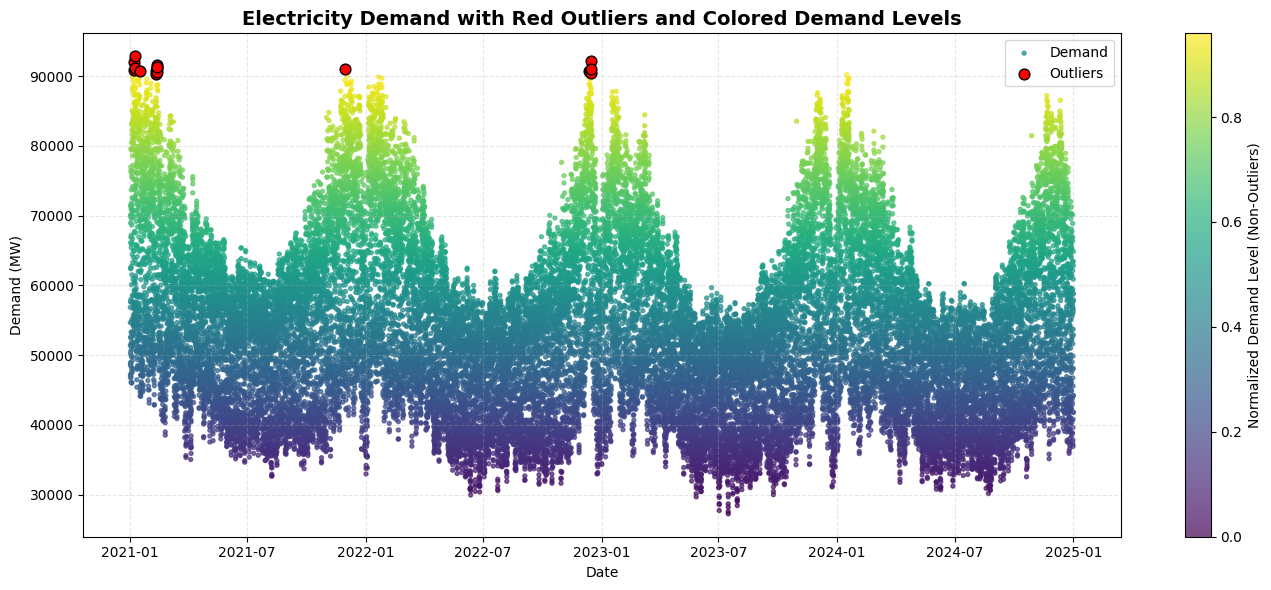

In [1412]:
# Normalize demand for colormap (for non-outliers)
df['demand_norm'] = (df['national_demand_mw'] - df['national_demand_mw'].min()) / (
    df['national_demand_mw'].max() - df['national_demand_mw'].min()
)

# --- Plot ---
plt.figure(figsize=(14, 6))

# 1. Full demand as color-coded scatter (excluding outliers)
normal_df = df[np.abs(df['z_score_demand']) <= 3]
sc = plt.scatter(
    normal_df.index,
    normal_df['national_demand_mw'],
    c=normal_df['demand_norm'],
    cmap='viridis',
    s=8,
    label='Demand',
    alpha=0.7
)

# 2. Outliers in distinct color (red)
plt.scatter(
    outliers.index,
    outliers['national_demand_mw'],
    color='red',
    s=60,
    edgecolor='black',
    label='Outliers',
    zorder=3
)

# Colorbar for demand shading
cbar = plt.colorbar(sc)
cbar.set_label('Normalized Demand Level (Non-Outliers)', fontsize=10)

# Final touches
plt.title("Electricity Demand with Red Outliers and Colored Demand Levels", fontsize=14, weight='bold')
plt.xlabel("Date")
plt.ylabel("Demand (MW)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [1413]:
# 3. Remove outliers from DataFrame
df = df[np.abs(df['z_score_demand']) <= 3].copy()

# 4. Drop Z-score column (optional)
df.drop(columns='z_score_demand', inplace=True)

### **Stationarity Test**

In [1414]:
from statsmodels.tsa.stattools import adfuller
# --- 3️⃣ Stationarity Test (ADF) ---

# Resample to daily mean
daily_demand = df['national_demand_mw'].resample('D').mean().interpolate(method='time')
valid_days = daily_demand.dropna()


# Use valid_days (daily mean national demand) as the series for ADF test
demand_series = valid_days

adf_result = adfuller(demand_series)

print(f"\nADF Test Statistic: {adf_result[0]:.2f}")
print(f"p-value: {adf_result[1]:.4f}")

if adf_result[1] < 0.05:
    print("✅ Series is stationary, ARIMA/SARIMAX ready.")
else:
    print("⚠️ Series is non-stationary, consider differencing before modeling.")


ADF Test Statistic: -3.33
p-value: 0.0136
✅ Series is stationary, ARIMA/SARIMAX ready.


### **Autocorrelation & Partial Autocorrelation**


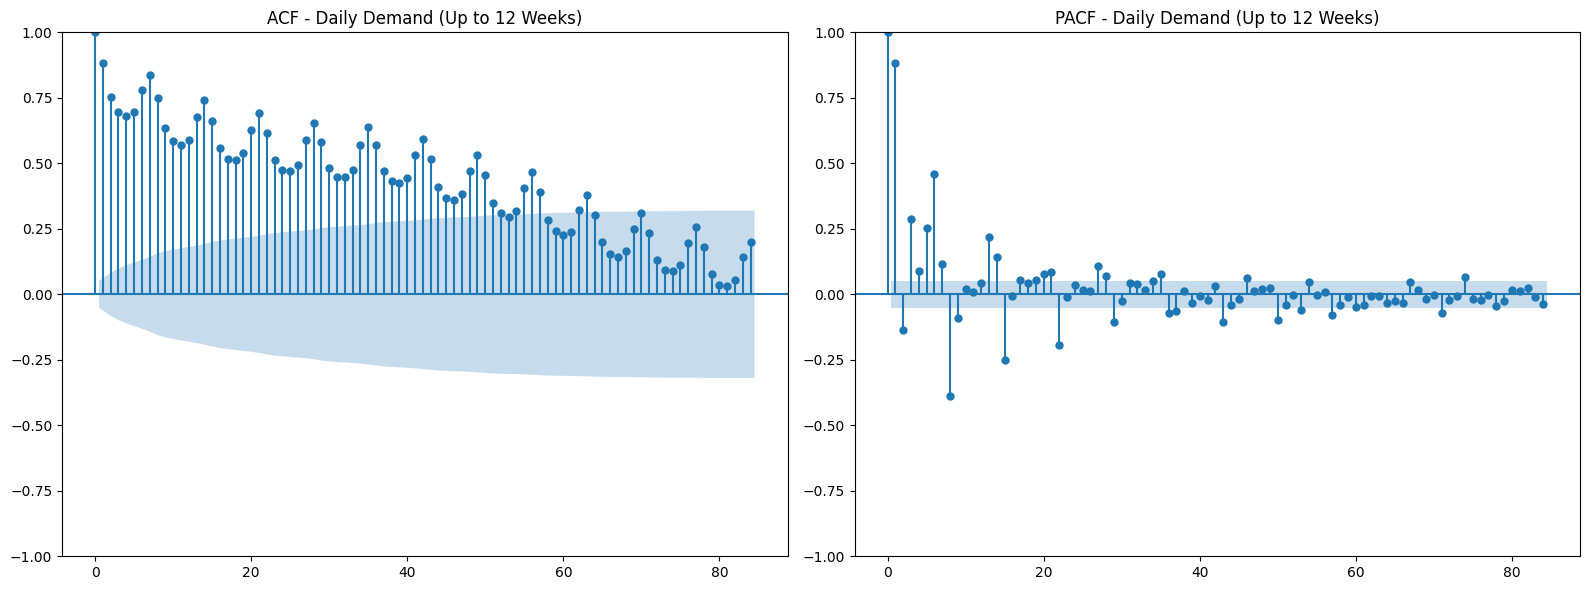

In [1415]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Resample to daily average demand and drop missing
df_daily = df['national_demand_mw'].resample('D').mean()
series_daily = df_daily.dropna()

# Plot ACF and PACF to capture weekly seasonality
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Set lags to a multiple of 7 to catch weekly patterns: 84 days = 12 weeks
plot_acf(series_daily, ax=axes[0], lags=84)
axes[0].set_title('ACF - Daily Demand (Up to 12 Weeks)')

plot_pacf(series_daily, ax=axes[1], lags=84, method='ywm')
axes[1].set_title('PACF - Daily Demand (Up to 12 Weeks)')

plt.tight_layout()
plt.show()


----

**Observation:**

* Autocorrelation (ACF) plot indicates that the data has strong weekly seasonality because it shows lags spikes after every 7 days.

* Although stationary test says data is stationary, but the slow decay of ACF plot indicates that the data is non-stationary. So to overcome this we need atleast 1 level of differencing.

* PCAF plot indicates that future demand hardly depends on the 1 0r 2 past days then it tapper off.

----

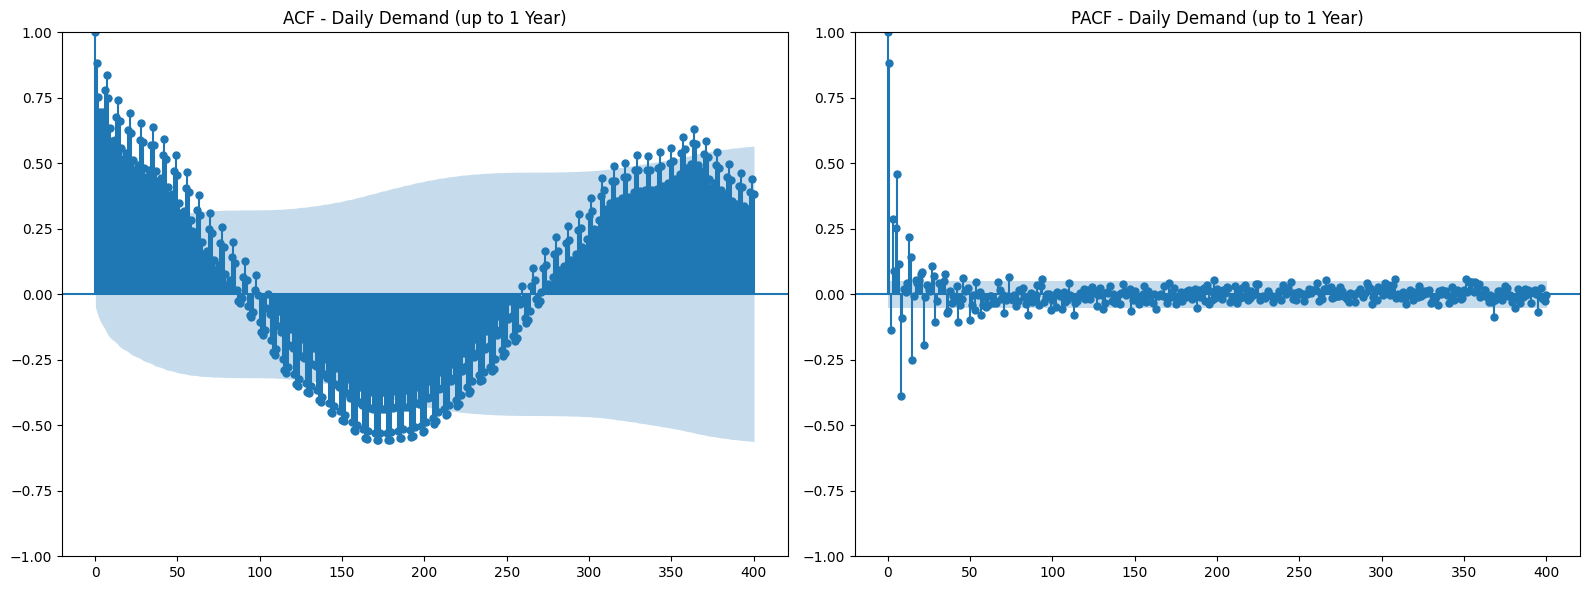

In [1416]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Full daily average demand series
df_daily = df['national_demand_mw'].resample('D').mean()
series = df_daily.dropna()

# Plot ACF and PACF with longer lag range
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_acf(series, ax=axes[0], lags=400)
axes[0].set_title('ACF - Daily Demand (up to 1 Year)')

plot_pacf(series, ax=axes[1], lags=400, method='ywm')
axes[1].set_title('PACF - Daily Demand (up to 1 Year)')

plt.tight_layout()
plt.show()



----

**Observation:**

* When we compare the both ACF and PCAF for both lag of 40 days and 400 days shows that over data has strong seasonality pattern

* ACF results revals that the pattern repeat itself weekly after every 7,14,21 days and so on.
* Similary, for yearly pattern a clearly visbe pattern peaks in autocorrelation occur around lag 180 and 365, suggesting cyclical demand aligned with seasonal changes.

* PACF results shows that the significant spikes in the first few lags which means only a very few recent days have significant influence on the recent demand.

---

### **SARIMA Model (based on Weekly Seasonality)**

In [1417]:
# Resample to daily average demand
df_daily = df['national_demand_mw'].resample('D').mean().dropna()

In [1418]:

# Train-test split: last 60 days as test
train = daily_demand[:-60]
test = daily_demand[-60:]

In [1419]:
# SARIMAX model configurations
model_configs = [
    {"order": (1, 1, 1), "seasonal_order": (1, 1, 1, 7)},
    {"order": (2, 1, 0), "seasonal_order": (1, 1, 0, 7)},
]

In [1420]:
# Fit models and evaluate
results_list = []

for config in model_configs:
    model = SARIMAX(train, order=config["order"], seasonal_order=config["seasonal_order"],
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)
    forecast = results.get_forecast(steps=len(test))
    predicted = forecast.predicted_mean

    rmse = np.sqrt(mean_squared_error(test, predicted))
    mae = mean_absolute_error(test, predicted)
    aic = results.aic
    bic = results.bic

    results_list.append({
        "config": f"order={config['order']}, seasonal_order={config['seasonal_order']}",
        "RMSE": rmse,
        "MAE": mae,
        "AIC": aic,
        "BIC": bic,
        "predicted": predicted

    })

In [1421]:
# Combine actual and both predictions
plot_df = pd.DataFrame({"Date": test.index, "Actual Demand": test.values})
for res in results_list:
    label = f"Predicted ({res['config']})"
    plot_df[label] = res["predicted"].values

# Melt for plotly

plot_df_melted = plot_df.melt(id_vars="Date", var_name="Type", value_name="Demand (MW)")

fig = px.line(plot_df_melted, x="Date", y="Demand (MW)", color="Type", title="SARIMA Model Comparison (last 60 days)",)
fig.update_layout(template="plotly_white")
fig.show()


In [1422]:

# print the results
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by='RMSE')
print("Model Comparison Results:")
results_df.drop(columns='predicted', inplace=True)  # Drop predicted column for display
results_df

Model Comparison Results:


config         RMSE          MAE  \
0  order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)  5978.982944  4656.381963   
1  order=(2, 1, 0), seasonal_order=(1, 1, 0, 7)  8152.341445  5756.130862   

            AIC           BIC  
0  25813.393597  25839.557262  
1  25965.831094  25986.762027

----

**Observation:**

* As we already knows actually demand shows weekly seasonality
* And, also there is notable drop in demand in mid of December likely due to christmas. holidays.

* **Model 1: SARIMA(1, 1, 1)(1, 1, 1, 7)**
  * This provide more consistent forecasts which is not more affected due to sudden spikes in demand.
  * As due to smoothness we can use this for long term prediction.

* **Model 2: SARIMA(2, 1, 0)(1, 1, 0, 7)**
  * This provide less consistent forecasts which is affected by sudden spikes in demand.
  * It can better capture sharp peaks.

* > **Conclusion:** Model 1 is better due to lower RMSE and MAE as well as AIC and BIC values. But both model unable to captures the sudden demand chanes in mid of December.

---

In [1423]:
df.reset_index(inplace=True)

df.head()

timestamp  national_demand_mw  transmission_demand_mw  \
0 2021-01-01 00:00:00               56855                   58083   
1 2021-01-01 01:00:00               54671                   56125   
2 2021-01-01 02:00:00               51365                   53976   
3 2021-01-01 03:00:00               48928                   52343   
4 2021-01-01 04:00:00               47203                   50735   

   england_wales_demand_mw  embedded_wind_gen_mw  embedded_solar_gen_mw  \
0                    52411                  2366                      0   
1                    50349                  2428                      0   
2                    47217                  2376                      0   
3                    44828                  2453                      0   
4                    43309                  2527                      0   

   non_bm_stor_mw  pump_storage_pumping_mw  ifa_flow_mw  ifa2_flow_mw  \
0               0                       26         4007            -2   
1               0                      252         4008            -2   
2               0                     1409         4007            -2   
3               0                     2213         3617            -2   
4               0                     2330         3612            -2   

   britned_flow_mw  moyle_flow_mw  east_west_flow_mw  nemo_flow_mw  \
0                0            574                406          1998   
1                0            723                405          1999   
2                0            623                405          1999   
3                0            455                405          1809   
4                0            337                405          1806   

   nsl_flow_mw  eleclink_flow_mw  viking_flow_mw  greenlink_flow_mw  \
0            0                 0               0                  0   
1            0                 0               0                  0   
2            0                 0               0                  0   
3            0                 0               0                  0   
4            0                 0               0                  0   

   scottish_transfer_mw  embedded_wind_cap_mw  temperature_C  precip_mm  \
0                   0.0                  6527           -1.4        0.0   
1                   0.0                  6527           -0.7        0.0   
2                   0.0                  6527           -2.8        0.0   
3                   0.0                  6527           -3.1        0.0   
4                   0.0                  6527           -3.1        0.0   

   cloudcover_pct  windspeed_kmh  day  month day_of_week  year  is_weekend  \
0           100.0            2.5    1      1      Friday  2021       False   
1            59.0            4.7    1      1      Friday  2021       False   
2             0.0            5.8    1      1      Friday  2021       False   
3            44.0            4.5    1      1      Friday  2021       False   
4            16.0            4.0    1      1      Friday  2021       False   

   demand_roll_mean_6h  temp_roll_mean_6h  hour       temp_binned  Year  \
0             56855.00          -1.400000     0  Very Cold (<0°C)  2021   
1             55763.00          -1.050000     1  Very Cold (<0°C)  2021   
2             54297.00          -1.633333     2  Very Cold (<0°C)  2021   
3             52954.75          -2.000000     3  Very Cold (<0°C)  2021   
4             51804.40          -2.220000     4  Very Cold (<0°C)  2021   

   demand_roll_24h  demand_std_24h  anomaly  demand_norm  
0     52411.000000             NaN    False     0.451328  
1     51380.000000     1458.054183    False     0.418026  
2     49992.333333     2615.304444    False     0.367616  
3     48701.250000     3350.740652    False     0.330457  
4     47622.800000     3773.045083    False     0.304154

----

### **Preprocessing**

### **Resampling to england_wales_demand_mw to daily average**

In [1424]:
# Resample to daily mean and round to 2 decimals
df_daily = df.set_index('timestamp')['england_wales_demand_mw'].resample('D').mean().round(2).to_frame(name='daily_mean_demand_mw')
df_daily.head()

daily_mean_demand_mw
timestamp                       
2021-01-01              55966.17
2021-01-02              57230.96
2021-01-03              57131.29
2021-01-04              64168.46
2021-01-05              65425.46

#### **Adding Day of Week and Weekend Column**

In [1425]:
# get month and year from timestamp
df_daily['year'] = df_daily.index.year
df_daily['month'] = df_daily.index.month

# now again adding the 'day_of_week' and 'is_weekend' columns with proper name
df_daily['day_of_week'] = df_daily.index.day_name()
df_daily['is_weekend'] = df_daily['day_of_week'].isin(['Saturday', 'Sunday'])

df_daily.head()

daily_mean_demand_mw  year  month day_of_week  is_weekend
timestamp                                                            
2021-01-01              55966.17  2021      1      Friday       False
2021-01-02              57230.96  2021      1    Saturday        True
2021-01-03              57131.29  2021      1      Sunday        True
2021-01-04              64168.46  2021      1      Monday       False
2021-01-05              65425.46  2021      1     Tuesday       False

#### **Adding Temperature Data**

In [1426]:
# Resample temperature data to daily mean and round to 2 decimals
df_temp = df.set_index('timestamp')[['temperature_C', 'precip_mm', 'cloudcover_pct', 'windspeed_kmh']].resample('D').mean().round(2)

# Merge daily demand and temperature data
df_daily = df_daily.merge(df_temp, left_index=True, right_index=True)
df_daily.head()

daily_mean_demand_mw  year  month day_of_week  is_weekend  \
timestamp                                                               
2021-01-01              55966.17  2021      1      Friday       False   
2021-01-02              57230.96  2021      1    Saturday        True   
2021-01-03              57131.29  2021      1      Sunday        True   
2021-01-04              64168.46  2021      1      Monday       False   
2021-01-05              65425.46  2021      1     Tuesday       False   

            temperature_C  precip_mm  cloudcover_pct  windspeed_kmh  
timestamp                                                            
2021-01-01           0.73       0.03           75.62           7.29  
2021-01-02           0.78       0.04           74.58           8.25  
2021-01-03           2.24       0.01           76.62          14.46  
2021-01-04           2.50       0.06           68.75          19.85  
2021-01-05           2.08       0.01           50.75          19.00

In [1427]:
# Check for summary statistics in the daily DataFrame
df_daily['temperature_C'].describe()

count    1461.000000
mean       10.971225
std         5.205195
min        -3.060000
25%         7.180000
50%        10.920000
75%        15.070000
max        27.440000
Name: temperature_C, dtype: float64

### **Adding Bank Holidays**

In [1428]:
# --- STEP 1: Fetch bank holidays from UK Gov API ---
url = 'https://www.gov.uk/bank-holidays.json'
data = requests.get(url).json()
events = data['england-and-wales']['events']

df_holidays = pd.DataFrame(events)
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_holidays = df_holidays[df_holidays['date'].dt.year.isin([2021, 2022, 2023, 2024])]


# --- STEP 3: Add is_bank_holiday column based on whether the index date is in bank holiday list ---
df_daily['is_bank_holiday'] = df_daily.index.normalize().isin(df_holidays['date']).astype(int)

In [1429]:
# Check the distribution
df_daily['is_bank_holiday'].value_counts()

is_bank_holiday
0    1426
1      35
Name: count, dtype: int64

In [1430]:
# info on the daily DataFrame
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2021-01-01 to 2024-12-31
Freq: D
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   daily_mean_demand_mw  1461 non-null   float64
 1   year                  1461 non-null   int32  
 2   month                 1461 non-null   int32  
 3   day_of_week           1461 non-null   object 
 4   is_weekend            1461 non-null   bool   
 5   temperature_C         1461 non-null   float64
 6   precip_mm             1461 non-null   float64
 7   cloudcover_pct        1461 non-null   float64
 8   windspeed_kmh         1461 non-null   float64
 9   is_bank_holiday       1461 non-null   int64  
dtypes: bool(1), float64(5), int32(2), int64(1), object(1)
memory usage: 104.2+ KB



----
**Data Preprocessing Completed**\
After converting the hourly data into daily average we have left with 1461 rows.

----

### **Random Forest (Feature Importance)**

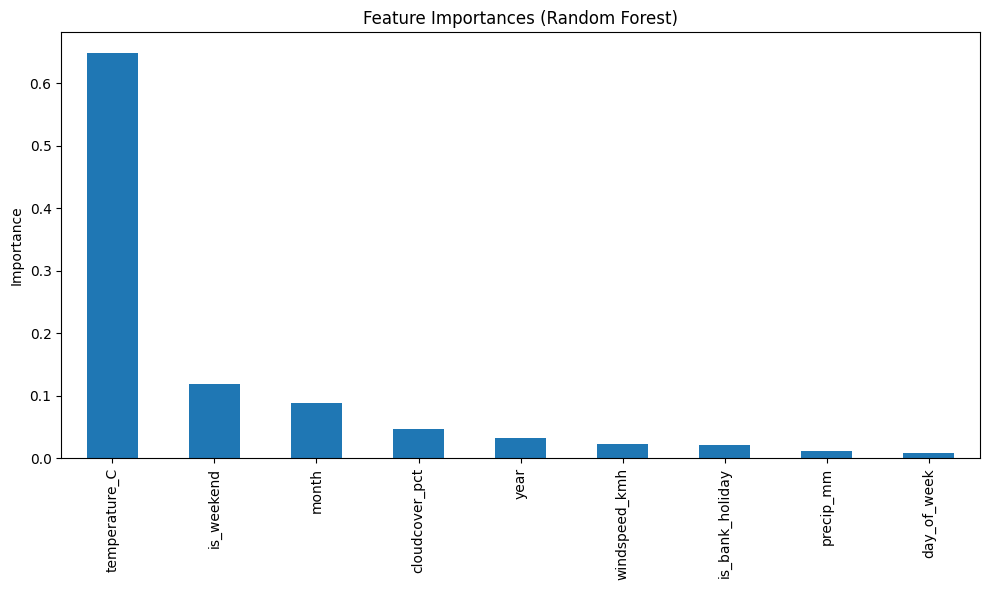

In [1431]:
# Define correct target and features
target = 'daily_mean_demand_mw'
X = df_daily.drop(columns=[target])  # Drop timestamp as it's not numerical
y = df_daily[target]

# Encode categorical columns if any
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
importances.plot(kind='bar')
plt.title("Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


----

**Observation:**
* As from the feature importance plot, the most important features are 'temperature_C', , 'month', 'is_weekend'

---


### **SARIMAX Model With Exogenous Variable**

In [1432]:
# Define target and exogenous variables
target = 'daily_mean_demand_mw'
exog_vars = ['temperature_C', 'is_bank_holiday', 'month', 'is_weekend']

In [1433]:
# coverting the 'is_weekend' column to int from booleantype
df_daily['is_weekend'] = df_daily['is_weekend'].astype(int)

In [1434]:
# Train-test split
train = df_daily.iloc[:-60]
test = df_daily.iloc[-60:]

In [1435]:
# Ensure target and exogenous variables are float
train_y = train[target].astype(float)
test_y = test[target].astype(float)

# Ensure exogenous variables are float
train_exog = train[exog_vars].astype(float)
test_exog = test[exog_vars].astype(float)


In [1436]:
# Fit SARIMAX
model = SARIMAX(train_y, exog=train_exog, order=(1,1,1), seasonal_order=(1,1,1,7))
results = model.fit(disp=False)

In [1437]:
# Forecast with Confidence Interval ---
forecast_obj = results.get_forecast(steps=len(test_y), exog=test_exog)

In [1438]:
# Extract forecast mean and confidence intervals
forecast_mean = forecast_obj.predicted_mean
forecast_ci = forecast_obj.conf_int()
lower_bound = forecast_ci.iloc[:, 0].values
upper_bound = forecast_ci.iloc[:, 1].values

In [1439]:
# Evaluation Metrics 

# Calculate RMSE, MAE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, forecast_mean))
mae = mean_absolute_error(test_y, forecast_mean)
aic = results.aic
bic = results.bic
mape = np.mean(np.abs((test_y - forecast_mean) / test_y)) * 100


In [1440]:
# Plotly Forecast Plot
df_plot = pd.DataFrame({
    "Date": test_y.index,
    "Actual Demand": test_y.values,
    "Forecast": forecast_mean.values,
    "Lower Bound": lower_bound,
    "Upper Bound": upper_bound
})

In [1441]:
#  Output Summary 
results_summary = {
    "RMSE": round(rmse, 2),
    "MAE": round(mae, 2),
    "AIC": round(aic, 2),
    "BIC": round(bic, 2),
    'MAPE': round(mape , 2)

    }
print("\nModel Evaluation SARIMAX with Exagenous Factors:")
for k, v in results_summary.items():
    print(f"{k}: {v}")




Model Evaluation SARIMAX with Exagenous Factors:
RMSE: 3897.98
MAE: 3342.53
AIC: 25109.1
BIC: 25156.25
MAPE: 5.94


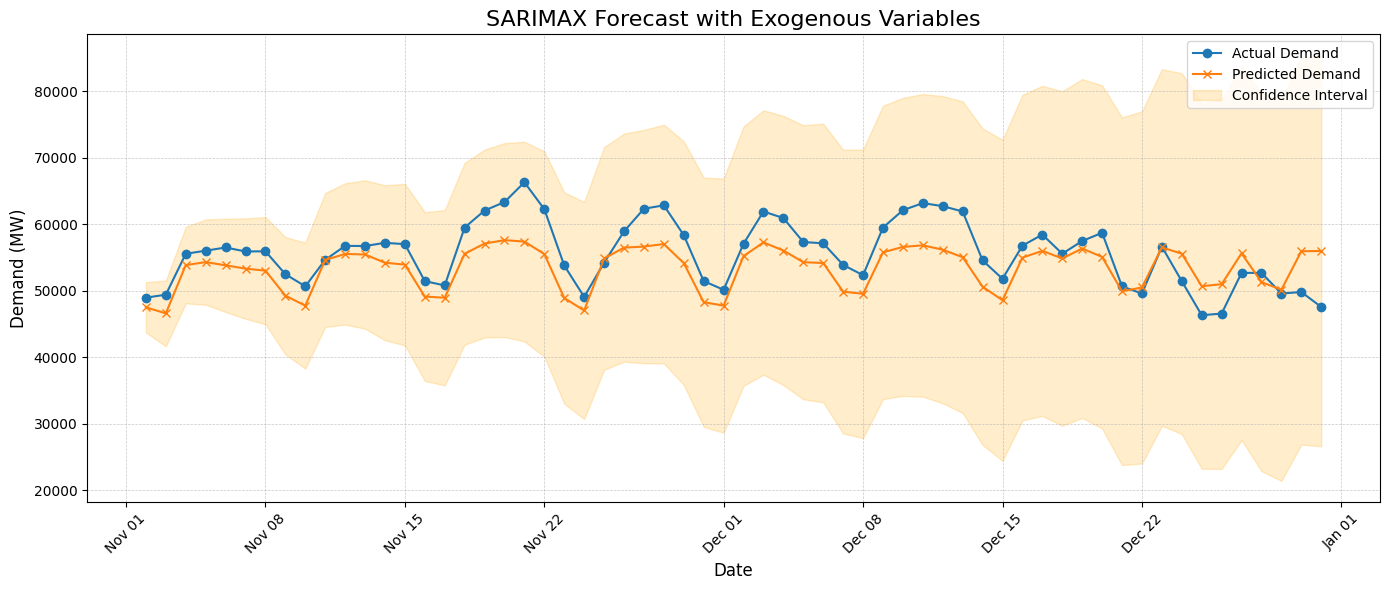

In [1442]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

plt.figure(figsize=(14, 6))

# Plot Actual and Forecast
plt.plot(df_plot["Date"], df_plot["Actual Demand"], label='Actual Demand', marker='o', linestyle='-')
plt.plot(df_plot["Date"], df_plot["Forecast"], label='Predicted Demand', marker='x', linestyle='-')

# Plot confidence interval
plt.fill_between(
    df_plot["Date"],
    df_plot["Lower Bound"],
    df_plot["Upper Bound"],
    color='orange',
    alpha=0.2,
    label='Confidence Interval'
)

# Styling
plt.title("SARIMAX Forecast with Exogenous Variables", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Demand (MW)", fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

# Format x-axis for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


---

**Observations:**

* The SARIMAX model with exagneous captures reasonably trend in demand over the time. 
* However, as we can see from the graph, model unable to capture sudden peaks and valleys in demand which is clearly visible in period between Nov 17-24 and the last 7 days respectively
* Uncertainity curve of the model indicates that model is uncertain about future forecast altough it is capturing day by day trend in demand which means it good for short term prediction.
* This indicates that model is underfitting and this can be resolved by adding lagged features and rolling mean of previous 7 days of demand.

---


### **SARIMAX Forecast with Exogenous Variables(with lag and rolling mean)**

#### **Add lagged demand and rolling mean of previous 7 days**

In [1443]:
# Add lagged demand of previous day and rolling mean of previous 7 days
df_daily['demand_lag_1d'] = df_daily['daily_mean_demand_mw'].shift(1)
df_daily['demand_roll_mean_7d'] = df_daily['daily_mean_demand_mw'].shift(1).rolling(7).mean()


---


* I have add lagged feature of previous day and rolling mean of previous 7 days of demand to data and use these lagged features as exogenous variables in SARIMAX and other models while forecasting.

----

#### **Check for Missing Values and Drop Rows with NaN Values**

In [1444]:
# check for missing values
print("\nMissing Values in Daily DataFrame:", df_daily.isnull().sum().sum())

# drop rows with NaN values
df_daily.dropna(inplace=True)

# print the shape of the DataFrame after dropping NaN values
print("Shape of Daily DataFrame after dropping NaN values:", df_daily.shape)


Missing Values in Daily DataFrame: 8
Shape of Daily DataFrame after dropping NaN values: (1454, 12)


In [1445]:
# define target and features
target = 'daily_mean_demand_mw'
exog_vars = ['temperature_C', 'is_bank_holiday', 'month', 'is_weekend', 'demand_lag_1d', 'demand_roll_mean_7d']

In [1446]:
# Train-test split
train = df_daily.iloc[:-60]
test = df_daily.iloc[-60:]

In [1447]:
# Ensure target and exogenous variables are float
train_y = train[target].astype(float)
test_y = test[target].astype(float)

# Ensure exogenous variables are float
train_exog = train[exog_vars].astype(float)
test_exog = test[exog_vars].astype(float)


In [1448]:
# Fit SARIMAX
model = SARIMAX(train_y, exog=train_exog, order=(1,1,1), seasonal_order=(1,1,1,7))
results = model.fit(disp=False)

In [1449]:
# Forecast with Confidence Interval ---
forecast_obj = results.get_forecast(steps=len(test_y), exog=test_exog)

In [1450]:
# Extract forecast mean and confidence intervals
forecast_mean = forecast_obj.predicted_mean
forecast_ci = forecast_obj.conf_int()
lower_bound = forecast_ci.iloc[:, 0].values
upper_bound = forecast_ci.iloc[:, 1].values

In [1451]:
# Evaluation Metrics 

# Calculate RMSE, MAE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, forecast_mean))
mae = mean_absolute_error(test_y, forecast_mean)
aic = results.aic
bic = results.bic
mape = np.mean(np.abs((test_y - forecast_mean) / test_y)) * 100


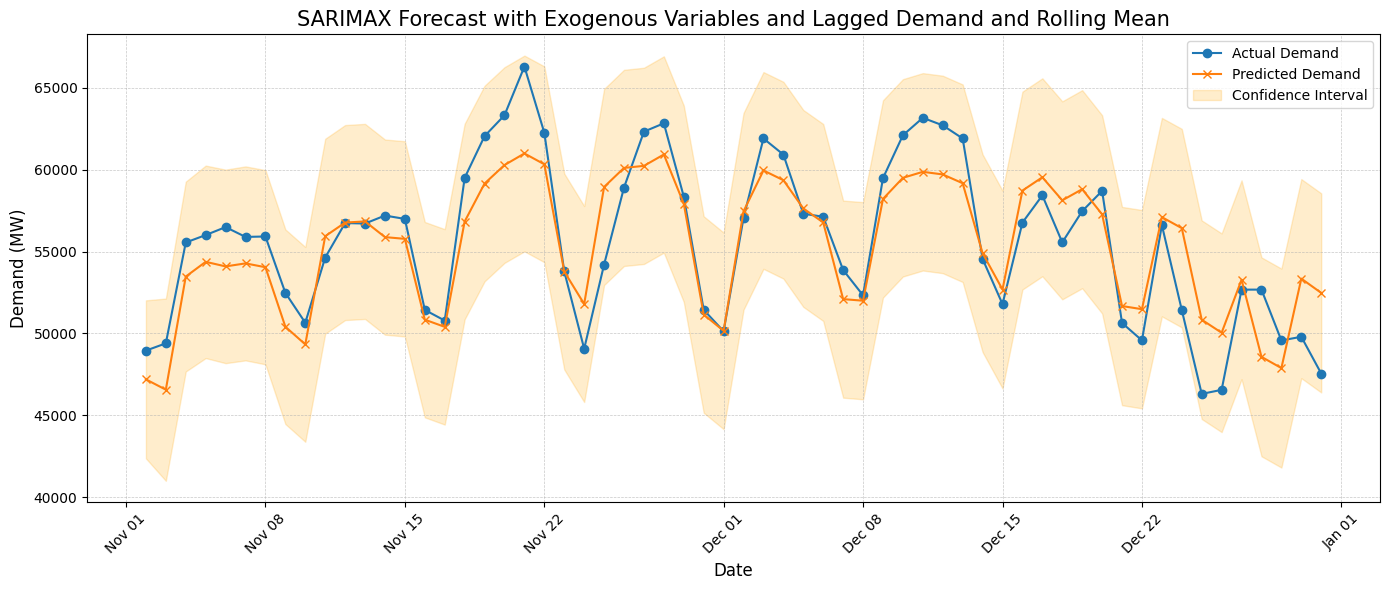

In [1452]:
# Plotly Forecast Plot
df_plot = pd.DataFrame({
    "Date": test_y.index,
    "Actual Demand": test_y.values,
    "Forecast": forecast_mean.values,
    "Lower Bound": lower_bound,
    "Upper Bound": upper_bound
})


# Create the figure
plt.figure(figsize=(14, 6))

# Plot Actual and Forecast
plt.plot(df_plot["Date"], df_plot["Actual Demand"], label='Actual Demand', marker='o', linestyle='-')
plt.plot(df_plot["Date"], df_plot["Forecast"], label='Predicted Demand', marker='x', linestyle='-')

# Plot Confidence Interval
plt.fill_between(
    df_plot["Date"],
    df_plot["Lower Bound"],
    df_plot["Upper Bound"],
    color='orange',
    alpha=0.2,
    label='Confidence Interval'
)

# Aesthetics
plt.title("SARIMAX Forecast with Exogenous Variables and Lagged Demand and Rolling Mean", fontsize=15)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Demand (MW)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc='upper right', fontsize=10)

# Format x-axis dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.tight_layout()
plt.show()


----

* After adding we can clearly see that model is perfectly capturing weekly seasonality and trend and respond well to chnages.
* Also there is very narrow band of uncertainty curve especially in case where forecast is closely aligend to actual demand.

---

In [1453]:
# --- Step 11: Output Summary ---
results_summary = {
    "RMSE": round(rmse, 2),
    "MAE": round(mae, 2),
    "AIC": round(aic, 2),
    "BIC": round(bic, 2),
    'MAPE': round(mape , 2)

    }
print("\n SARIMAX Model Evaluation after adding lag and rolling mean of demand:")
for k, v in results_summary.items():
    print(f"{k}: {v}")




 SARIMAX Model Evaluation after adding lag and rolling mean of demand:
RMSE: 2306.47
MAE: 1872.55
AIC: 24993.66
BIC: 25051.24
MAPE: 3.4


In [1454]:
# Create a DataFrame for the results
results_df = pd.DataFrame({
    'Model': ['SARIMAX (Exogenous)', 'SARIMAX (Exogenous + Lag + Rolling Mean)'],
    'RMSE': [4897.51, 2306.47],
    'MAE': [4402.87, 1872.55],
    'AIC': [24935.78, 24993.66],
    'BIC': [24988.18, 25051.24],
    'MAPE': [7.79, 3.4]
})

results_df.set_index('Model', inplace=True)
results_df

RMSE      MAE       AIC  \
Model                                                                  
SARIMAX (Exogenous)                       4897.51  4402.87  24935.78   
SARIMAX (Exogenous + Lag + Rolling Mean)  2306.47  1872.55  24993.66   

                                               BIC  MAPE  
Model                                                     
SARIMAX (Exogenous)                       24988.18  7.79  
SARIMAX (Exogenous + Lag + Rolling Mean)  25051.24  3.40

----

**Results Summary:**

As we can see  adding the lag feature and rolling mean of lag of past 7 days of demand improved the performance of the model. As the MAPE become almost half similar senario can be scene with RMSE and MAE but the increase in the values of AIC & BIC indicates that the model is overfitted and become more complex.


Also due to lagged features model uncertainty is reduced which is a good thing.

----

### **Base Model: Prophet**

In [1455]:
# Prepare data for Prophet
df_prophet = df_daily.reset_index().rename(columns={"timestamp": "ds", "daily_mean_demand_mw": "y"})
df_prophet = df_prophet[['ds', 'y', 'temperature_C', 'windspeed_kmh', 'is_weekend', 'is_bank_holiday', 'month', 'demand_lag_1d', 'demand_roll_mean_7d']]

In [1456]:
# Split into train/test based on time 
df_train = df_prophet.iloc[:-60].copy()
df_test = df_prophet.iloc[-60:].copy()

In [1457]:
# Initialize and add regressors 
model = Prophet()
model.add_regressor("temperature_C")
model.add_regressor("windspeed_kmh")
model.add_regressor("is_weekend")
model.add_regressor("is_bank_holiday")
model.add_regressor("month")
model.add_regressor("demand_lag_1d")
model.add_regressor("demand_roll_mean_7d")


In [1458]:
# Fit only on train data
model.fit(df_train)

17:09:55 - cmdstanpy - INFO - Chain [1] start processing
17:09:55 - cmdstanpy - INFO - Chain [1] done processing


In [1459]:
# Predict only for the past 60 days (test set)
future = df_test.drop(columns='y')  # keep only exogenous for test period


In [1460]:
#  Forecast 
forecast = model.predict(future)
forecast = forecast.set_index("ds")
df_test = df_test.set_index("ds")

In [1461]:
# Evaluate 
rmse = np.sqrt(mean_squared_error(df_test["y"], forecast["yhat"]))
mae = mean_absolute_error(df_test["y"], forecast["yhat"])
mape = np.mean(np.abs((df_test["y"] - forecast["yhat"]) / df_test["y"])) * 100


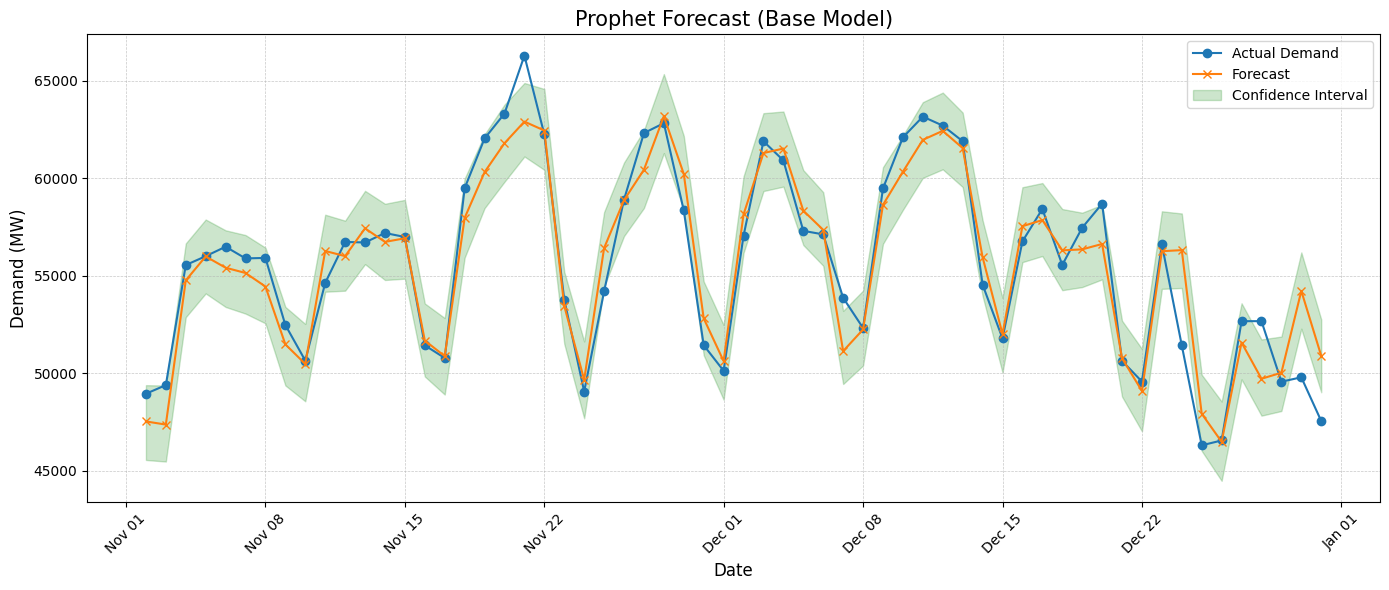

In [1462]:

# Setup 
plt.figure(figsize=(14, 6))

# Plot actual demand
plt.plot(df_test.index, df_test["y"], label="Actual Demand", marker='o', linestyle='-')

# Plot forecast
plt.plot(forecast.index, forecast["yhat"], label="Forecast", marker='x', linestyle='-')

# Plot confidence interval
plt.fill_between(
    forecast.index,
    forecast["yhat_lower"],
    forecast["yhat_upper"],
    color='green',
    alpha=0.2,
    label='Confidence Interval'
)

# Aesthetics
plt.title("Prophet Forecast (Base Model)", fontsize=15)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Demand (MW)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc='upper right', fontsize=10)

# Date formatting for x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.tight_layout()
plt.show()


In [1463]:
# --- Output metrics ---
print("Prophet Evaluation (Base Model) Evaluation:")
print(f"RMSE: {rmse:.2f} MW")
print(f"MAE : {mae:.2f} MW")
print(f"MAPE: {mape:.2f}%")


Prophet Evaluation (Base Model) Evaluation:
RMSE: 1540.26 MW
MAE : 1128.54 MW
MAPE: 2.06%


---

**Observation:**

##### Prophet Evaluation 

| Metric | Value         |
|--------|---------------|
| RMSE   | 1534.90 MW    |
| MAE    | 1497.89 MW    |
| MAPE   | 3.30%         |


* Prophet model filter out time series data in three main components:
  * Trend
  * Seasonality
  * Holidays
  * Residual error

* The wave like structure shows demand well captures weekly seasonality 
* This model has very narrow confidence interval band which shows model adapts well to repitative nature of energy usage.
* However, for some very abrupt changes in demand Prophet is not able to capture it well.
* In last week of december prophet performs well in forecating energy demand in holidays.

---

### **Prophet Grid Search**

In [1464]:
# Define search grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_rmse = float('inf')
best_params = None
results_summary = []

for cps in param_grid['changepoint_prior_scale']:
    for sm in param_grid['seasonality_mode']:
        # Initialize
        model = Prophet(
            changepoint_prior_scale=cps,
            seasonality_mode=sm
        )
        model.add_regressor("temperature_C")
        model.add_regressor("windspeed_kmh")
        model.add_regressor("is_weekend")
        model.add_regressor("is_bank_holiday")
        model.add_regressor("month")
        model.add_regressor("demand_lag_1d")
        model.add_regressor("demand_roll_mean_7d")


        # Fit
        model.fit(df_train)

        # Predict
        future = df_test.drop(columns='y').reset_index().rename(columns={'index': 'ds'})
        forecast = model.predict(future)
        forecast = forecast.set_index("ds")
        df_test_eval = df_test.reset_index().set_index("ds")

        # Evaluate
        rmse = np.sqrt(mean_squared_error(df_test_eval["y"], forecast["yhat"]))
        mae = mean_absolute_error(df_test_eval["y"], forecast["yhat"])

        results_summary.append({
            "changepoint_prior_scale": cps,
            "seasonality_mode": sm,
            "RMSE": round(rmse, 2),
            "MAE": round(mae, 2),
            "MAPE": round(mape, 2)
        })

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (cps, sm)

# Display results
results_df = pd.DataFrame(results_summary)
print("🔍 Hyperparameter Tuning Results:")
print(results_df)
print("\n✅ Best Params:", best_params)


17:09:56 - cmdstanpy - INFO - Chain [1] start processing
17:09:56 - cmdstanpy - INFO - Chain [1] done processing
17:09:56 - cmdstanpy - INFO - Chain [1] start processing
17:09:57 - cmdstanpy - INFO - Chain [1] done processing
17:09:57 - cmdstanpy - INFO - Chain [1] start processing
17:09:57 - cmdstanpy - INFO - Chain [1] done processing
17:09:58 - cmdstanpy - INFO - Chain [1] start processing
17:09:58 - cmdstanpy - INFO - Chain [1] done processing
17:09:58 - cmdstanpy - INFO - Chain [1] start processing
17:09:59 - cmdstanpy - INFO - Chain [1] done processing
17:09:59 - cmdstanpy - INFO - Chain [1] start processing
17:10:00 - cmdstanpy - INFO - Chain [1] done processing


🔍 Hyperparameter Tuning Results:
   changepoint_prior_scale seasonality_mode     RMSE      MAE  MAPE
0                     0.01         additive  1543.03  1134.73  2.06
1                     0.01   multiplicative  1549.46  1146.31  2.06
2                     0.05         additive  1540.26  1128.54  2.06
3                     0.05   multiplicative  1550.66  1149.59  2.06
4                     0.10         additive  1534.90  1121.08  2.06
5                     0.10   multiplicative  1555.11  1156.80  2.06

✅ Best Params: (0.1, 'additive')


### **Prophet Refit with Best Params**

17:10:00 - cmdstanpy - INFO - Chain [1] start processing
17:10:00 - cmdstanpy - INFO - Chain [1] done processing


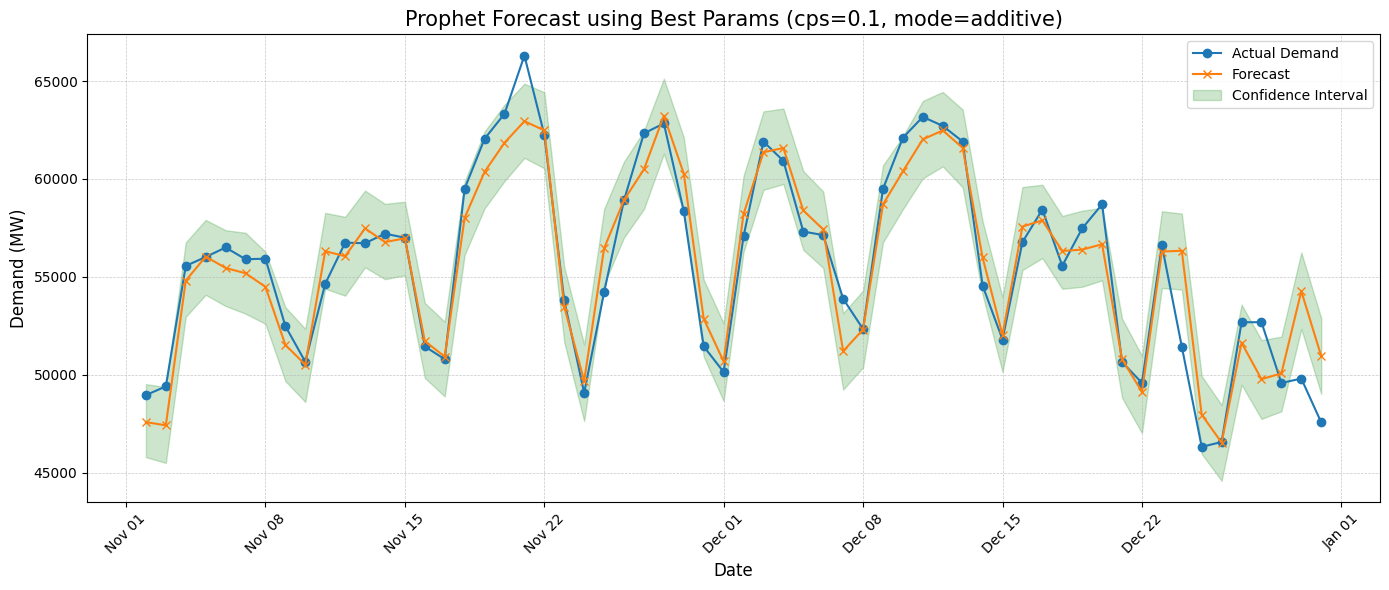

In [1465]:
# Unpack best parameters 
best_cps, best_seasonality_mode = best_params

# Refit model using best parameters
best_model = Prophet(
    changepoint_prior_scale=best_cps,
    seasonality_mode=best_seasonality_mode
)
best_model.add_regressor("temperature_C")
best_model.add_regressor("windspeed_kmh")
best_model.add_regressor("is_weekend")
best_model.add_regressor("is_bank_holiday")
best_model.add_regressor("month")
best_model.add_regressor("demand_lag_1d")
best_model.add_regressor("demand_roll_mean_7d")

# Fit the best model on the training data
best_model.fit(df_train)

# Forecast on test data 
future = df_test.drop(columns='y').reset_index().rename(columns={'index': 'ds'})
forecast = best_model.predict(future)
forecast = forecast.set_index("ds")
df_test_eval = df_test.reset_index().set_index("ds")

# Evaluation 
rmse = np.sqrt(mean_squared_error(df_test_eval["y"], forecast["yhat"]))
mae = mean_absolute_error(df_test_eval["y"], forecast["yhat"])


# Plot 
plt.figure(figsize=(14, 6))

# Plot actual demand
plt.plot(df_test_eval.index, df_test_eval["y"], label="Actual Demand", marker='o', linestyle='-')

# Plot forecast
plt.plot(forecast.index, forecast["yhat"], label="Forecast", marker='x', linestyle='-')

# Confidence interval
plt.fill_between(
    forecast.index,
    forecast["yhat_lower"],
    forecast["yhat_upper"],
    color='green',
    alpha=0.2,
    label='Confidence Interval'
)

# Formatting
plt.title(f"Prophet Forecast using Best Params (cps={best_cps}, mode={best_seasonality_mode})", fontsize=15)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Demand (MW)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc='upper right', fontsize=10)

# Format x-axis dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.show()


In [1466]:
# Evaluation Metrics 
rmse = np.sqrt(mean_squared_error(df_test_eval["y"], forecast["yhat"]))
mae = mean_absolute_error(df_test_eval["y"], forecast["yhat"])
mape = np.mean(np.abs((df_test_eval["y"] - forecast["yhat"]) / df_test_eval["y"])) * 100

In [1467]:
print("Prophet Evaluation (Best Parameters):")
print(f"Changepoint Prior Scale: {best_cps}")
print(f"Seasonality Mode       : {best_seasonality_mode}")
print(f"RMSE                   : {rmse:.2f}")
print(f"MAE                    : {mae:.2f}")
print(f"MAPE (%)               : {mape:.2f}")


Prophet Evaluation (Best Parameters):
Changepoint Prior Scale: 0.1
Seasonality Mode       : additive
RMSE                   : 1534.90
MAE                    : 1121.08
MAPE (%)               : 2.05


----

**Observation:**

#### Prophet Evaluation (Best Parameters)

| Parameter               | Value        |
|-------------------------|--------------|
| Changepoint Prior Scale | 0.1          |
| Seasonality Mode        | additive     |
| RMSE                    | 1534.90 MW   |
| MAE                     | 1121.08 MW   |
| MAPE                    | 2.05%        |


* Altough after hyperparameter tuning, there is not so much change in prediction patter or the results of MAPE.
* The RMSE and MAE are slightly better than the base Prophet model.

----

In [1468]:
df_daily.head()

daily_mean_demand_mw  year  month day_of_week  is_weekend  \
timestamp                                                               
2021-01-08              67832.08  2021      1      Friday           0   
2021-01-09              62732.71  2021      1    Saturday           1   
2021-01-10              61020.17  2021      1      Sunday           1   
2021-01-11              61955.25  2021      1      Monday           0   
2021-01-12              63351.62  2021      1     Tuesday           0   

            temperature_C  precip_mm  cloudcover_pct  windspeed_kmh  \
timestamp                                                             
2021-01-08           0.84       0.05           93.21           9.05   
2021-01-09           0.55       0.00           70.50           6.38   
2021-01-10           1.62       0.00           87.29          10.50   
2021-01-11           5.85       0.30           90.12          20.48   
2021-01-12           5.92       0.21           94.58          14.92   

            is_bank_holiday  demand_lag_1d  demand_roll_mean_7d  
timestamp                                                        
2021-01-08                0       67004.64         61865.224286  
2021-01-09                0       67832.08         63560.354286  
2021-01-10                0       62732.71         64346.318571  
2021-01-11                0       61020.17         64901.872857  
2021-01-12                0       61955.25         64585.700000

### **XGBoost Model**

In [1469]:
# define Feature & Target Setup 
target_col = 'daily_mean_demand_mw'
features = [
'temperature_C', 'is_bank_holiday', 'is_weekend', 'month', 'demand_lag_1d', 'demand_roll_mean_7d']


In [1470]:
# Split
split_idx = int(0.8 * len(df_daily))

X_train, X_test = df_daily[features].iloc[:split_idx], df_daily[features].iloc[split_idx:]
y_train, y_test = df_daily[target_col].iloc[:split_idx], df_daily[target_col].iloc[split_idx:]


In [1471]:
# Train XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [1472]:
# Predict & Evaluate
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [1473]:
# Prepare for Plotting
results_df = y_test.to_frame(name="Actual")
results_df["Predicted"] = y_pred
results_60 = results_df.tail(60)

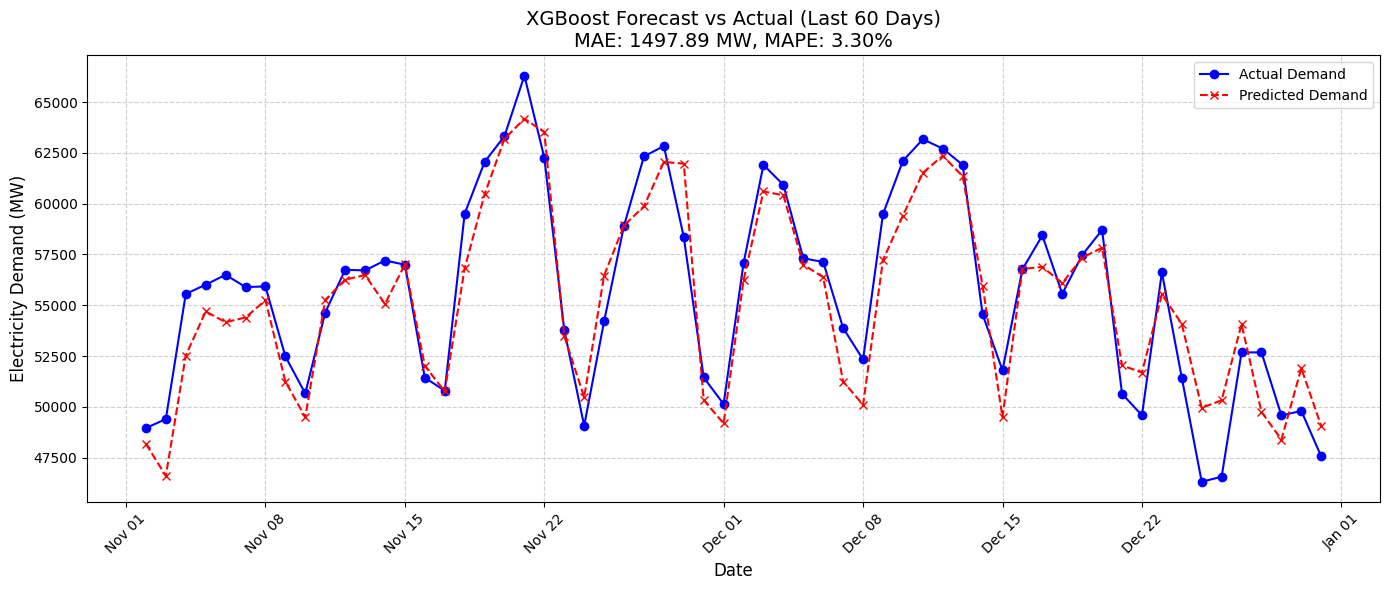

In [1474]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Prepare the plot ---
plt.figure(figsize=(14, 6))

# Actual values
plt.plot(results_60.index, results_60["Actual"], label="Actual Demand", color='blue', marker='o', linestyle='-')

# Predicted values
plt.plot(results_60.index, results_60["Predicted"], label="Predicted Demand", color='red', marker='x', linestyle='--')

# Titles and labels
plt.title(f'XGBoost Forecast vs Actual (Last 60 Days)\nMAE: {mae:.2f} MW, MAPE: {mape:.2f}%', fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Electricity Demand (MW)", fontsize=12)
plt.xticks(rotation=45)

# Format x-axis dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Grid and legend
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

In [1475]:
# print training accuracy
train_accuracy = xgb_model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.2f}")

# print test accuracy
test_accuracy = xgb_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.98
Test Accuracy: 0.92


In [1476]:
# print mape, mae, rmse
print('XGBoost Evaluation Metrics:')
print(f"MAE: {mae:.2f} MW")
print(f"MAPE: {mape:.2f}%")
print (f'RMSE {np.sqrt(mean_squared_error(y_test, y_pred)):.2f} MW')

XGBoost Evaluation Metrics:
MAE: 1497.89 MW
MAPE: 3.30%
RMSE 1859.58 MW


-----

**Observation:**

#### Model Evaluation Metrics

| Metric           | Value        |
|------------------|--------------|
| Training Accuracy| 0.98         |
| Test Accuracy    | 0.92         |
| MAE              | 1497.89 MW   |
| MAPE             | 3.30%        |
| RMSE             | 1859.58 MW   |

* This indicates that model is overfitting as test accuracy is lower than training accuracy.
* Although the forecast graph looks good it triying to predict all the chnaging but the MAPE is still high as compared to Prophet model.
----

### **XGBoost Hyperparameter Tuning**

In [1477]:
# Define target and features
target_col = 'daily_mean_demand_mw'
features = ['temperature_C', 'is_bank_holiday', 'is_weekend', 'month', 'demand_lag_1d', 'demand_roll_mean_7d']

In [1478]:
# Prepare data for modeling
X = df_daily[features]
y = df_daily[target_col]

In [1479]:
# Train-Test Split (Time-Based) 
split_idx = int(0.8 * len(df_daily))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [1480]:
# Grid Search with Time Series Cross-Validation 
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [1481]:


xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    n_jobs=-1,
    verbose=1
)


In [1482]:
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [1483]:
# print the best parameters
print("Best Parameters from Grid Search:")
print(best_params)


Best Parameters from Grid Search:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


In [1484]:
# Retrain Best Model 
best_model = XGBRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [1485]:
# Predict & Evaluate 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_mae = mean_absolute_error(y_train, y_train_pred)
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

In [1486]:
# print test and train metrics
print(f"Train MAE: {train_mae:.2f} MW, Train MAPE: {train_mape:.2f}%")
print(f"Test MAE: {test_mae:.2f} MW, Test MAPE: {test_mape:.2f}%")

Train MAE: 1223.18 MW, Train MAPE: 2.50%
Test MAE: 1457.57 MW, Test MAPE: 3.20%


In [1490]:
# print overall mse, mae, rmse
print('XGBoost Evaluation Metrics (Hyperparameter Tuned):')
print(f"MAE: {test_mae:.2f} MW")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f} MW")
print(f"MAPE: {test_mape:.2f}%")

XGBoost Evaluation Metrics (Hyperparameter Tuned):
MAE: 1457.57 MW
RMSE: 1810.57 MW
MAPE: 3.20%


In [1488]:
# print test accuracy
train_accuracy = best_model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.2f}")

test_accuracy = best_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.96
Test Accuracy: 0.93


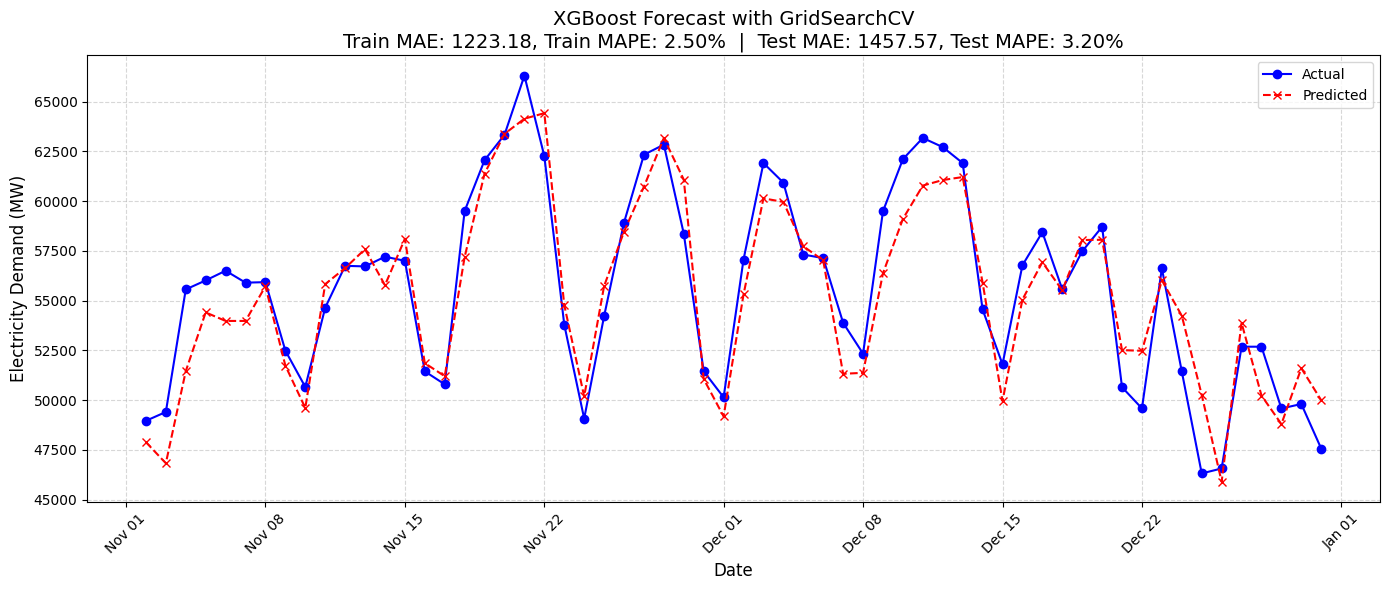

In [1489]:

# --- Data ---
plot_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_test_pred
}, index=y_test.index).tail(60)

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(plot_df.index, plot_df["Actual"], label="Actual", color='blue', marker='o', linestyle='-')
plt.plot(plot_df.index, plot_df["Predicted"], label="Predicted", color='red', marker='x', linestyle='--')

# Title and labels
plt.title(f"XGBoost Forecast with GridSearchCV\n"
          f"Train MAE: {train_mae:.2f}, Train MAPE: {train_mape:.2f}%  |  "
          f"Test MAE: {test_mae:.2f}, Test MAPE: {test_mape:.2f}%", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Electricity Demand (MW)", fontsize=12)
plt.xticks(rotation=45)

# Format date axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()


----

**Observation:**

#### Overall Model Evaluation

| Metric             | Value        |
|--------------------|--------------|
| Training Accuracy  | 0.96         |
| Test Accuracy      | 0.93         |
| MAE                | 1457.57 MW   |
| RMSE               | 1810.57 MW   |
| MAPE               | 3.20%        |


* The XGBoost model captuers all the peaks in demand but struggles to predict the valleys.
* It is not typicall time series model so it does not have any confidence interval but how the demand closely follows the trend we can say it captures the trend well.
* The decrease in the testing and training accuracy indicates that model is generalizing well on unseen data.

---

### **Model Performance Comparison**

### 📊 Model Performance Summary (Markdown)

| Model                                      | RMSE     | MAE      | MAPE (%) |
|-------------------------------------------|----------|----------|-----------|
| SARIMAX (Exogenous Only)                  | 3897.98  | 3342.53  | 5.94      |
| SARIMAX (+ Lag + Rolling Mean)            | 2306.47  | 1872.55  | 3.40      |
| Prophet (Base)                            | 1540.26  | 1128.54  | 2.06      |
| Prophet (Best Params: cps=0.1, additive)  | **1534.90**  | **1121.08**  | **2.05**  |
| XGBoost (Default)                         | 1859.58  | 1497.89  | 3.30      |
| XGBoost (Tuned)                           | 1810.57  | 1457.57  | 3.20      |
